In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# Here's several helpful packages to load


import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os  # use OS dependent functions like reading or writing files
os.environ['NUMEXPR_MAX_THREADS'] = '10' # default is 8, Mac Book M1 Pro has 10 can support 10, which may slow down the computer
import re  # regular expressions in Python for searching patterns

import math

import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torch.nn as nn  # base class for all neural network modules in PyTorch
from glob import glob  # find all the pathnames matching a specified pattern according to the rules used by the Unix shell
from matplotlib import pyplot as plt # plot libary
import matplotlib.pyplot as plt # plot multiple sources on the same plot
import collections # build-in types
from tqdm import tqdm # provides a progress bar for loops and iterators
from itertools import chain # provides iterations 
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction # Natural Language Toolkit (nltk)

import matplotlib.pyplot as plt # for analyze dataset

import spacy # determine if a sentence is grammatically correct.

# MI related dependence
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.feature_selection import mutual_info_regression

# utils
from torch.utils.data import Dataset

# generate vocab.json
import collections
from collections import Counter

# Config

In [2]:
class Config:
    train_test_ratio = 0.9 # the proportion of data that will be used for training versus testing
    E = 128
    V = 128
    L = None
    N = None
    # use the content of the decoder's first dimension (=V) as three transformer decoder's first part of input
    # channel: AWGN
    sigma = 0.1  #standard deviation of the Additive White Gaussian Noise (AWGN)
    loss_lambda = 1 # a weighting factor for the loss function
    clipping_max = 1.  # a threshold for clipping the gradients during training
    num_steps = 40 # number of steps for the training process
CONFIG = Config()

# Preprocess

# vocab

In [3]:
'''
class Vocab:  
#   text vocabulary
    # __init__ sorts the tokens by frequency in descending order, and assigns an index to each token
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None): 
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = tokens
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],  
                                   reverse=True)            # A list of tokens sorted by frequency
        # Unknown tokens have an index of 0
        self.idx_to_token = ['<unk>'] + reserved_tokens  # List, idx corresponds to the position of token
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self): # returns the length of the vocabulary
        return len(self.idx_to_token)

    def __getitem__(self, tokens): # returns the index of a given token
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices): # returns the token corresponding to a given index
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    
    def to_indices(self, tokens): # returns the index corresponding to a given token
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.token_to_idx.get(token, self.unk) for token in tokens]

    @property
    def unk(self):  # Unknown tokens have an index of 0
        return 0

    @property
    def token_freqs(self): # returns the list of token frequencies that was sorted in descending order during initialization of the Vocab class.
        return self._token_freqs
'''

class Vocab:  
    # __init__ sorts the tokens by frequency in descending order, and assigns an index to each token
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None): 
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = tokens
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],  
                                   reverse=True)            # A list of tokens sorted by frequency
        # Unknown tokens have an index of 0
        self.idx_to_token = ['<unk>'] + reserved_tokens  # List, idx corresponds to the position of token
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
        self.stoi = self.token_to_idx
        self.itos = self.idx_to_token
        self.tokens = self.idx_to_token[1:]

    def __len__(self): # returns the length of the vocabulary
        return len(self.idx_to_token)

    def __getitem__(self, tokens): # returns the index of a given token
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices): # returns the token corresponding to a given index
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    
    def to_indices(self, tokens): # returns the index corresponding to a given token
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.token_to_idx.get(token, self.unk) for token in tokens]

    @property
    def unk(self):  # Unknown tokens have an index of 0
        return 0

    @property
    def token_freqs(self): # returns the list of token frequencies that was sorted in descending order during initialization of the Vocab class.
        return self._token_freqs
    
class MyVocab(Vocab):
    # define your own constructor and/or methods here
    pass

def count_corpus(tokens):  
    """Count the frequency of words"""
    # The tokens here are 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flattens a list of tokens into a list
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [4]:
#vocab_list = open('./corpus_train_vocab.txt').readlines() 
#vocab_dict = {}  # create an empty dictionary
#for key_value_pair in vocab_list:
#    key_value_pair = key_value_pair.strip().split()
#    vocab_dict[key_value_pair[0]] = int(key_value_pair[1]) # in the vocabulary list, key is token and value is the frequency
#source_vocab = Vocab(collections.Counter(vocab_dict), reserved_tokens=['<pad>', '<eos>', '<bos>'])
#torch.save(source_vocab, './source_vocab.pth')


vocab_list = open('./corpus_train_vocab.txt').readlines() 
vocab_dict = {}  # create an empty dictionary
for key_value_pair in vocab_list:
    key_value_pair = key_value_pair.strip().split()
    vocab_dict[key_value_pair[0]] = int(key_value_pair[1]) # in the vocabulary list, key is token and value is the frequency
source_vocab = Vocab(collections.Counter(vocab_dict), reserved_tokens=['<pad>', '<eos>', '<bos>'])
source_vocab.stoi['<unk>'] = len(source_vocab.stoi)
source_vocab.itos.append('<unk>')

# Save the source vocab object to a file
torch.save(source_vocab, './source_vocab.pth')

# dataset

In [5]:
train_corpus = open('./corpus_train_split.txt', 'r').readlines()  # the special "\n" has not been processed

class EuroParlDataset(torch.utils.data.Dataset):  # define Pytorch data set
    def __init__(self, vocab=source_vocab, corpus=train_corpus):
        self.vocab = vocab
        self.corpus = corpus
        
    def __len__(self):
        return len(self.corpus)
    
    def __getitem__(self, index):
        sentence = self.corpus[index].strip().split() + ['<eos>']
        return self.vocab[sentence], len(sentence)
    
# collate_fn combines a list of samples into a single batch：
# sorts the batch data by the length of the sentence, in descending order;
# extracts the length of the sentences, and converts the sentences into tensors;
# pads the tensors to the maximum length of the sentences in the batch.
def collate_fn(batch_data): 
    batch_data.sort(key=lambda xi: len(xi[0]), reverse=True)
    data_length = [xi[1] for xi in batch_data]
    data = [torch.tensor(xi[0]) for xi in batch_data]
    padded_data = nn.utils.rnn.pad_sequence(data, batch_first=True, padding_value=1)
    return padded_data, torch.tensor(data_length)

# loads the text data from corpus_train_split.txt and converts it into numerical representations using the vocabulary, with the <eos> token appended to each sentence. 
# Then the dataset is loaded in batches of 32, shuffled, and padded to the maximum length of the sentence in each batch.
data_loader = torch.utils.data.DataLoader(dataset=EuroParlDataset(), batch_size=32, shuffle=True, collate_fn=collate_fn)

# pipeline

In [6]:
# The system  uses nn.embedding
# L E V N setup: E=128， V=128

# backbone

In [7]:
torch.set_printoptions(threshold=np.inf)
# MI needs to be masked; mask first and then sample
# decoder needs to be masked
# the training needs chain
class PositionalEncoding(nn.Module):
    """position encoding"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

class MyEmbedding(nn.Module):
    def __init__(self, vocab=source_vocab):
        super(MyEmbedding, self).__init__()
        self.embedding = nn.Embedding(len(vocab), CONFIG.E, padding_idx=vocab['<pad>'])
        
    def forward(self, X):
        return self.embedding(X)

# with batch normalization
class Encoder(nn.Module):
    def __init__(self, vocab=source_vocab):
        super(Encoder, self).__init__()
        self.position_encoding = PositionalEncoding(CONFIG.V, dropout=0.1)
        self.norm1 = nn.BatchNorm1d(CONFIG.V)
        self.transformer_encoder1 = nn.TransformerEncoderLayer(d_model=CONFIG.V, nhead=8, dim_feedforward=512,  # other's parameter
                                                              batch_first=True)
        self.norm2 = nn.BatchNorm1d(CONFIG.V)
        self.transformer_encoder2 = nn.TransformerEncoderLayer(d_model=CONFIG.V, nhead=8, dim_feedforward=512,  # other's parameter
                                                              batch_first=True)
        self.norm3 = nn.BatchNorm1d(CONFIG.V)
        self.transformer_encoder3 = nn.TransformerEncoderLayer(d_model=CONFIG.V, nhead=8, dim_feedforward=512,  # other's parameter
                                                              batch_first=True)
        self.linear1 = nn.Linear(CONFIG.V, 2 * CONFIG.V)
        self.norm4 = nn.BatchNorm1d(2 * CONFIG.V)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(2 * CONFIG.V, 16)
        self.norm5 = nn.BatchNorm1d(16)
        self.relu2 = nn.ReLU()
        
    def forward(self, X, valid_lens):
        mask = (torch.arange((X.shape[1]), device=device).unsqueeze(0) >= valid_lens.unsqueeze(1)).to(device)
        X2 = self.position_encoding(X)
        X2_norm = self.norm1(X2.transpose(1, 2)).transpose(1, 2)
        X3 = self.transformer_encoder1(X2_norm, src_key_padding_mask=mask)
        X3_norm = self.norm2(X3.transpose(1, 2)).transpose(1, 2)
        X4 = self.transformer_encoder2(X3_norm, src_key_padding_mask=mask)
        X4_norm = self.norm3(X4.transpose(1, 2)).transpose(1, 2)
        X5 = self.transformer_encoder3(X4_norm, src_key_padding_mask=mask)
        X6 = self.linear1(X5)
        X6_norm = self.norm4(X6.transpose(1, 2)).transpose(1, 2)
        X7 = self.relu1(X6_norm)
        X8 = self.linear2(X7)
        X8_norm = self.norm5(X8.transpose(1, 2)).transpose(1, 2)
        X9 = self.relu2(X8_norm)
        return X9
        
def Channel(X):  # AWGN
    return X + torch.normal(0, CONFIG.sigma, size=X.shape).to(device)


class Decoder(nn.Module):
    def __init__(self, vocab=source_vocab):
        super(Decoder, self).__init__()
        # reshape
        self.position_encoding = PositionalEncoding(CONFIG.V, dropout=0.1)
        self.linear1 = nn.Linear(16, 2 * CONFIG.V)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(2 * CONFIG.V, CONFIG.V)
        self.relu2 = nn.ReLU()
        self.transformer_decoder1 = nn.TransformerDecoderLayer(d_model=CONFIG.V, nhead=8, dim_feedforward=512,  # other's parameter
                                                              batch_first=True)
        self.transformer_decoder2 = nn.TransformerDecoderLayer(d_model=CONFIG.V, nhead=8, dim_feedforward=512,  # other's parameter
                                                              batch_first=True)
        self.transformer_decoder3 = nn.TransformerDecoderLayer(d_model=CONFIG.V, nhead=8, dim_feedforward=512,  # other's parameter
                                                              batch_first=True)
        self.linear3 = nn.Linear(CONFIG.V, len(source_vocab))
        
    def forward(self, emb_decoder_input, channel_output, origin_len, tgt_mask=None, mode='train'):
        memory_mask = (torch.arange((channel_output.shape[1]), dtype=torch.float32,
                            device=device)[None, :] >= origin_len[:, None]).to(device)
        channel_output = self.linear1(channel_output)
        channel_output = self.relu1(channel_output)
        channel_output = self.linear2(channel_output)
        memory = self.relu2(channel_output)
        emb_decoder_input = self.position_encoding(emb_decoder_input)
        X6 = self.transformer_decoder1(emb_decoder_input, memory, tgt_mask=tgt_mask, memory_key_padding_mask=memory_mask, tgt_key_padding_mask=memory_mask if mode == 'train' else None)
        X7 = self.transformer_decoder2(X6, memory, tgt_mask=tgt_mask, memory_key_padding_mask=memory_mask, tgt_key_padding_mask=memory_mask if mode == 'train' else None)
        X8 = self.transformer_decoder3(X7, memory, tgt_mask=tgt_mask, memory_key_padding_mask=memory_mask, tgt_key_padding_mask=memory_mask if mode == 'train' else None)
        X9 = self.linear3(X8)
        return X9


class GlorotFanInInitializer(nn.Module):
    def __init__(self):
        super().__init__()

    def reset_parameters(self, module):
        for name, param in module.named_parameters():
            if 'weight' in name and len(param.shape) > 1:
                nn.init.xavier_uniform_(param, gain=nn.init.calculate_gain('relu') * math.sqrt(2.0 / (param.shape[0] + param.shape[1])))
                


class VAE(nn.Module):
    def __init__(self, in_dim=16, out_dim=64, latent_dim=8):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, out_dim),
            nn.ReLU()
        )

        self.mu = nn.Linear(out_dim, latent_dim)
        self.logvar = nn.Linear(out_dim, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, in_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        x_hat = self.decoder(z)
        return x_hat

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, x.shape[-1]))
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

class DeepST(nn.Module):
    def __init__(self):
        super(DeepST, self).__init__()
        self.encoder = Encoder()
        self.channel = Channel
        self.decoder = Decoder()
        self.vae = VAE(in_dim=16, out_dim=64) # change out_dim 16 to 64 for example
    

    def forward(self, emb_encoder_input, valid_lens, emb_decoder_input=None, embedding=None, phase=1):
        encode_result = self.encoder(emb_encoder_input, valid_lens)

        # VAE encoding and decoding
        vae_encoded = self.vae.encode(encode_result)
        vae_sampled = self.vae.reparameterize(*vae_encoded)
        vae_decoded = self.vae.decode(vae_sampled)

        channel_outputs = self.channel(encode_result)

        
        if phase == None:
            mask = (torch.triu(torch.ones(emb_decoder_input.shape[1], emb_decoder_input.shape[1])) == 1).transpose(0, 1)
            mask = (mask.masked_fill(mask == 0, True).masked_fill(mask == 1, False)).to(device)
            return encode_result, self.channel(encode_result), \
                   self.decoder(torch.cat([embedding(torch.full([emb_decoder_input.shape[0], 1], source_vocab['<bos>'], dtype=torch.long, device=device)), 
                                        emb_decoder_input[:, :-1, :]], dim=1).to(device), 
                                channel_outputs,
                                valid_lens, 
                                mask)
        else:
            return encode_result, self.channel(encode_result)


In [8]:
class MI(nn.Module):
    def __init__(self): #6 layers
        super(MI, self).__init__()
        self.linear1 = nn.Linear(16 * 2, 8 * CONFIG.V)
        self.relu1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(p=0.5)
        self.linear2 = nn.Linear(8 * CONFIG.V, 4 * CONFIG.V)
        self.relu2 = nn.ReLU()
        #self.dropout2 = nn.Dropout(p=0.5)
        self.linear3 = nn.Linear(4 * CONFIG.V, 2 * CONFIG.V)
        self.relu3 = nn.ReLU()
        #self.dropout3 = nn.Dropout(p=0.5)
        self.linear4 = nn.Linear(2 * CONFIG.V, 2 * CONFIG.V)
        self.relu4 = nn.ReLU()
        #self.dropout4 = nn.Dropout(p=0.5)
        self.linear5 = nn.Linear(2 * CONFIG.V, 2 * CONFIG.V)
        self.relu5 = nn.ReLU()
        #self.dropout5 = nn.Dropout(p=0.5)
        self.linear6 = nn.Linear(2 * CONFIG.V, 1)
        self.relu6 = nn.ReLU()
        
    def network(self, X, Y):
        x = self.relu1(self.linear1(torch.cat([X, Y], dim=1)))
        #x = self.dropout1(x)
        x = self.relu2(self.linear2(x))
        #x = self.dropout2(x)
        x = self.relu3(self.linear3(x))
        #x = self.dropout3(x)
        x = self.relu4(self.linear4(x))
        #x = self.dropout4(x)
        x = self.relu5(self.linear5(x))
        #x = self.dropout5(x)
        x = self.relu6(self.linear6(x))
        return x
        
    def forward(self, X, Y, valid_lens): 
        
        mask = (torch.arange((X.shape[1]), dtype=torch.long,
                            device=X.device)[None, :] >= valid_lens[:, None]).reshape(-1)
        # Reshape X and Y first, then take them out
        X = X.reshape(-1, 16)
        Y = Y.reshape(-1, 16)
        
        X = X[mask == False]
        Y = Y[mask == False]
        
        # sample
        sample_size = X.shape[0]
        idx = list(range(sample_size))
        random.shuffle(idx)
        idx = torch.tensor(idx).to(device)
        X = X[idx]
        Y = Y[idx]
        idx_shuffle = list(range(sample_size))
        random.shuffle(idx_shuffle)
        idx_shuffle = torch.tensor(idx_shuffle).to(device)
        shuffle_Y = Y[idx_shuffle]
        
        output_joint = self.network(X, Y)
        output_marginal = self.network(X, shuffle_Y)
        
        return output_joint, output_marginal



# loss

In [9]:

def mi_criterion(x, y):
    max_y = torch.max(y)
    return torch.mean(x) - (max_y + torch.log(torch.mean(torch.exp(y - max_y))))

class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
    def sequence_mask(self, X, valid_len, value=0):
        """
        Mask out irrelevant items in a sequence
        X: (batch_size, maxlen)
        """
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X
    
    """Softmax cross-entropy loss function with masking"""
    # pred's shape：(batch_size,num_steps,vocab_size)
    # label's shape：(batch_size,num_steps)
    # valid_len's shape：(batch_size,)
    def forward(self, pred, label, valid_len):
        weights = torch.ones_like(label)
        weights = self.sequence_mask(weights, valid_len)
        self.reduction='mean'
        unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
            pred.permute(0, 2, 1), label)
        weighted_loss = (unweighted_loss * weights).sum(dim=1) / weights.sum(dim=1)
        return weighted_loss


In [10]:
embedding = MyEmbedding()
embedding.to(device)
model = DeepST()
initializer = GlorotFanInInitializer()
model.apply(initializer.reset_parameters)
model.to(device)
mi_model = MI()
mi_model.to(device)

MI(
  (linear1): Linear(in_features=32, out_features=1024, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=1024, out_features=512, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=512, out_features=256, bias=True)
  (relu3): ReLU()
  (linear4): Linear(in_features=256, out_features=256, bias=True)
  (relu4): ReLU()
  (linear5): Linear(in_features=256, out_features=256, bias=True)
  (relu5): ReLU()
  (linear6): Linear(in_features=256, out_features=1, bias=True)
  (relu6): ReLU()
)

# train

In [11]:
batch_total_loss_list, batch_mi_loss_list = [], []
epoch_total_loss_list, epoch_mi_loss_list = [], []
epoch_avg_mi_list = []
avg_mi_list = []

In [12]:
'''
This is a training script for the DeepST model. The script initializes two different optimizers for the model and the embedding layer. 
It also sets the model to train mode. It then trains the model for 60 epochs, where in each epoch it iterates 
through the data loader and calculates the transceiver loss using the criterion and passing the input through 
the model and the embedding layer. The gradients are then calculated, clipped to a certain value using 
torch.nn.utils.clip_grad_norm_ and the optimizer steps to update the model's parameters and the embedding 
layer's parameters. It also keeps track of the running total loss, and the batch and epoch total loss, 
which are plotted at various points during training to visualize the loss.

It is also worth noting that the script is using the MaskedSoftmaxCELoss as the criterion, this loss is a 
variation of the softmax cross-entropy loss, but it takes into account the padding of the input sequence 
and masks the loss for the padded values so that they do not contribute to the loss calculation.
'''

def train(model=model, clipping_max=CONFIG.clipping_max, num_steps=CONFIG.num_steps, phase=1):
    
    # with normalization
    def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
    
    # Define the loss function
    criterion = MaskedSoftmaxCELoss()
    
    # Set up number of epochs for training
    num_epochs = 20
    
    # Define empty lists to compute input to encoder output ratio
    source_bits_list = []
    total_bits_list = []
    ratio = []
    
    # Define optimizers for different parts of the model
    transceiver_optimizer = torch.optim.Adam(chain(embedding.parameters(), model.parameters()), lr=5e-4)
    mi_optimizer = torch.optim.SGD(chain(embedding.parameters(), model.parameters()), lr=5e-4)
    embedding_optimizer = torch.optim.Adam(embedding.parameters(), lr=5e-4)
        
    # Measure the mutual information between the source signal and channel characteristics
    mi_sum = 0.
    mi_count = 0
        
    # Apply initialization weights to the model
    model.apply(init_weights)
    val_bleus = []
        
    # Loop through epochs
    for epoch in range(num_epochs):
        # Initialize loss
        running_total_loss, running_mi_loss = 0., 0.
        
        # Set model to training mode
        model.train()
        embedding.train()
        
        # Count batches
        batch_cnt = 0
        batch_num = len(data_loader)
            
        # Enable the dynamic learning rate
        transceiver_lr = 5e-4 * (0.1 ** (epoch // 10))
        mi_lr = 1e-3 * (0.1 ** (epoch // 10))
        #embedding_lr = 5e-4 * (0.1 ** (epoch // 10))
        for param_group in transceiver_optimizer.param_groups:
            param_group['lr'] = transceiver_lr
        for param_group in mi_optimizer.param_groups:
            param_group['lr'] = mi_lr
        #for param_group in embedding_optimizer.param_groups:
        #    param_group['lr'] = embedding_lr
            
        # Initialize a list to store average mutual information per epoch
        epoch_avg_mi_list = []
        
        # Loop through data loader
        for index, data in enumerate(tqdm(data_loader), 0):
            
            # Computation of the number of bits used to represent the source symbols divided by the total number of transmitted bits
            total_bits = 0.
            source_bits = 0.
                
            # Set optimizer gradients to zero
            transceiver_optimizer.zero_grad()
            mi_optimizer.zero_grad()
            embedding_optimizer.zero_grad()
            
            # Load data onto GPU or CPU
            inputs, valid_lens = data
            inputs, valid_lens = inputs.to(device), valid_lens.to(device)
            
            # Encode the input sentence
            emb_inputs = embedding(inputs)
            encode_outputs, channel_outputs, outputs = model(emb_inputs, valid_lens, emb_inputs, embedding, phase=None)

            # Measure mutual information
            x, y = mi_model(encode_outputs, channel_outputs, valid_lens)
            mi_loss = -mi_criterion(x, y)
                
            # Calculate total loss
            transceiver_loss = criterion(outputs, inputs, valid_lens).mean()
            total_loss = transceiver_loss + CONFIG.loss_lambda * mi_loss

            # Calculate gradients
            transceiver_loss.backward(retain_graph=True)
            mi_loss.backward()
            torch.nn.utils.clip_grad_norm_(mi_model.parameters(), clipping_max)
            torch.nn.utils.clip_grad_norm_(chain(embedding.parameters(), model.parameters()), clipping_max)
            
            # Update the optimizer for the transceiver network
            transceiver_optimizer.step()
            # Update the optimizer for the mutual information estimator network
            mi_optimizer.step()
            # Update the optimizer for the embedding network
            embedding_optimizer.step()

            # Add the current batch's total loss to the running total loss
            running_total_loss += float(total_loss.data)
            # Add the current batch's mutual information loss to the running MI loss
            running_mi_loss += mi_loss.item()

            # Compute the mutual information between the source signal and channel characteristics for this batch
            mi_sum += float(mi_loss.data)
            # Increment the number of batches used to compute the average mutual information
            mi_count += 1

            # Compute the average mutual information over the entire training so far and add it to the list
            avg_mi = mi_sum / mi_count
            avg_mi_list.append(avg_mi)
            #print(f'epoch {epoch}, avg mi: {avg_mi}')

            
            # Compute the number of bits used to represent the source symbols
            # Divided by the total number of transmitted bits (source and channel-coded bits)
            total_bits = sum(valid_lens * torch.log2(torch.Tensor([outputs.size(1)])).to(device))
            source_bits = sum(valid_lens * torch.log2(torch.Tensor([len(source_vocab)]).to(device))) - (CONFIG.loss_lambda * mi_loss).item()

            # Calculate the compression ratio and add it to the list
            ratio.append(float(source_bits / total_bits))
            source_bits_list.append(float(source_bits.cpu().item()))
            total_bits_list.append(float(total_bits.cpu().item()))

            # Add the current batch's total loss to the list
            batch_total_loss_list.append(float(total_loss.data))
            # Add the current batch's mutual information loss to the list
            batch_mi_loss_list.append(mi_loss.item())
            #print(f'Batch {index}, MI loss: {mi_loss.item()}')
            
            
           # Increment the batch count and show batch MI and total loss graphs for every fifth batch
            batch_cnt += 1
            if batch_cnt > batch_num / 5:
                print(f'now batch:{index} in epoch {epoch}')
                batch_cnt = 0
                min_loss = min(batch_mi_loss_list)
                max_loss = max(batch_mi_loss_list)
                padding = 0.1 * abs(max_loss - min_loss)
                plt.ylim(min_loss - padding, max_loss + padding)
                plt.plot(batch_mi_loss_list)
                plt.title('batch_mi_loss_list')
                plt.show()
                plt.plot(batch_total_loss_list)
                plt.title('batch_total_loss_list')
                plt.show()

        # Print epoch number, total loss for epoch, and 5 sample inputs and outputs for the training set
        print('===' * 10, 'epoch:', epoch, 'loss:', running_total_loss)
        print('train sample:')
        for i in range(5):
            print('********************\n',source_vocab.to_tokens(list(inputs[i].cpu().numpy())), '\n->\n', source_vocab.to_tokens(list(outputs[i, :].detach().cpu().argmax(dim=1).numpy())))

        # Add the epoch's total loss and mutual information loss to their respective lists
        epoch_total_loss_list.append(running_total_loss)
        epoch_mi_loss_list.append(running_mi_loss)

        # Plot the epoch total loss graph
        plt.plot(epoch_total_loss_list)
        plt.title('epoch_total_loss_list')
        plt.show()

        # Plot the batch MI loss graph
        min_loss = min(batch_mi_loss_list)
        max_loss = max(batch_mi_loss_list)
        padding = 0.1 * abs(max_loss - min_loss)
        plt.ylim(min_loss - padding, max_loss + padding)
        plt.plot(batch_mi_loss_list)
        plt.title('batch_mi_loss_list')
        plt.show()
        
        if epoch <= 1 or epoch_total_loss_list[-1] < epoch_total_loss_list[-2]:
            # Save model and optimizer state dictionary
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': transceiver_optimizer.state_dict(),
                'embedding_state_dict': embedding.state_dict(),
                'source_vocab': source_vocab,
                'model_architecture': {
                    'encoder': {
                        'position_encoding': model.encoder.position_encoding.state_dict(),
                        'transformer_encoder1': model.encoder.transformer_encoder1.state_dict(),
                        'transformer_encoder2': model.encoder.transformer_encoder2.state_dict(),
                        'transformer_encoder3': model.encoder.transformer_encoder3.state_dict(),
                        'linear1': model.encoder.linear1.state_dict(),
                        'linear2': model.encoder.linear2.state_dict(),
                        'norm1': model.encoder.norm1.state_dict(),
                        'norm2': model.encoder.norm2.state_dict(),
                        'norm3': model.encoder.norm3.state_dict(),
                        'norm4': model.encoder.norm4.state_dict(),
                        'norm5': model.encoder.norm5.state_dict(),
                        'relu1': model.encoder.relu1.state_dict(),
                        'relu2': model.encoder.relu2.state_dict()
                    },
                    'decoder': {
                        'position_encoding': model.decoder.position_encoding.state_dict(),
                        'transformer_decoder1': model.decoder.transformer_decoder1.state_dict(),
                        'transformer_decoder2': model.decoder.transformer_decoder2.state_dict(),
                        'transformer_decoder3': model.decoder.transformer_decoder3.state_dict(),
                        'linear1': model.decoder.linear1.state_dict(),
                        'linear2': model.decoder.linear2.state_dict(),
                        'linear3': model.decoder.linear3.state_dict(),
                        'relu1': model.decoder.relu1.state_dict(),
                        'relu2': model.decoder.relu2.state_dict()
                    }
                },
                'epoch_total_loss_list': epoch_total_loss_list,
                'batch_total_loss_list': batch_total_loss_list,
                'source_bits_list': source_bits_list,
                'total_bits_list': total_bits_list
            }
            torch.save(checkpoint, 'model_checkpoint.pth')
        
        
        if epoch <= 1 or epoch_total_loss_list[-1] < epoch_total_loss_list[-2]:
            # Save model and embedding state_dict if either it is the first epoch or if the current epoch's total loss is lower than the previous epoch's total loss
            torch.save(model.state_dict(), 'model-test.pth')
            torch.save({'embedding_matrix': embedding.state_dict()}, 'embedding-test.pth')

        # Set model to evaluation mode and compute BLEU scores on the validation set
        with torch.no_grad():
            model.eval()
            bleus = []
            val_corpus = open('./corpus_val_split.txt', 'r').readlines()
            val_data_loader = torch.utils.data.DataLoader(dataset=EuroParlDataset(corpus=val_corpus), batch_size=32, shuffle=True, collate_fn=collate_fn)
            for index, data in enumerate(tqdm(val_data_loader), 0):
                inputs, valid_lens = data
                inputs, valid_lens = inputs.to(device), valid_lens.to(device)
                emb_inputs = embedding(inputs)
                _, channel_outputs = model(emb_inputs, valid_lens, phase=1)
                # decoder's first one is <bos>
                outputs = torch.cat([torch.full([inputs.shape[0], 1], source_vocab['<bos>'], dtype=torch.long, device=device), 
                                    torch.full([inputs.shape[0], num_steps - 1], source_vocab['<pad>'], dtype=torch.long, device=device)], 
                                    dim=1).to(device)

                # continue_idx marks which sentences can continue to be generated
                continue_idx = torch.arange(inputs.shape[0], device=device)
                num_step = 0
                while not len(continue_idx) == 0 and num_step < num_steps - 1:
                    emb_outputs = embedding(outputs[continue_idx, :num_step + 1])
                    pred_words = model.decoder(emb_outputs, channel_outputs[continue_idx], valid_lens[continue_idx], mode='validate').argmax(dim=2)[:, -1:]
                    outputs[continue_idx, num_step + 1] = pred_words.squeeze(1)
                    continue_idx = continue_idx[(pred_words != source_vocab['<eos>']).squeeze(1)]
                    num_step += 1
                # Compute BLEU scores for each generated sentence
                for i in range(inputs.shape[0]):
                    bleus.append(sentence_bleu([list(inputs[i].cpu().numpy())], list(outputs[i, 1:].cpu().numpy()), smoothing_function=SmoothingFunction().method1))

            # Print sample translations and compute average mutual information for the epoch
            print('val sample:')
            for i in range(5):
                print('********************\n',source_vocab.to_tokens(list(inputs[i].cpu().numpy())), '\n->\n', source_vocab.to_tokens(list(outputs[i, 1:].cpu().numpy())))

            # measure the mutual information between the source signal and channel characteristics
            avg_mi = mi_sum / mi_count
            epoch_avg_mi_list.append(avg_mi)
            print(f'epoch {epoch}, avg mi: {avg_mi}')
                
            # measure the mutual information between the source signal and channel characteristics
            mi_sum += float(mi_loss.data)
            mi_count += 1
            
            # Compute the number of bits used to represent the source symbols divided by the total number of transmitted bits
            total_bits += sum(valid_lens * torch.log2(torch.Tensor([len(source_vocab)])).to(device))
            source_bits += sum(valid_lens * torch.log2(torch.Tensor([len(source_vocab)]).to(device))) - mi_loss.item()
                     
            print(f'val bleu mean:{sum(bleus) / len(bleus)}')
            val_bleus.append(sum(bleus) / len(bleus))
            plt.plot(val_bleus)
            plt.title('val_bleus')
            plt.show()
             
    # Compute the average mutual information over the entire training
    plt.plot(range(len(avg_mi_list)), avg_mi_list)
    plt.xlabel('Epochs')
    plt.ylabel('Average Mutual Information')
    plt.title('Average Mutual Information over Training')
    plt.show()
        
        
    # compute the ratio of the number of bits used to represent the source symbols divided by the total number of transmitted bits for each epoch
    # move tensors to cpu and convert to numpy arrays for plotting
    ratio = np.array(ratio)
    source_bits_list = np.array(source_bits_list)
    total_bits_list = np.array(total_bits_list)
    plt.plot(ratio, label="Ratio")
    plt.legend()
    plt.show()
        
        
    # Assuming source_bits_list and total_bits_list are lists containing the data to be plotted
    plt.plot(source_bits_list, label='Source bits')
    plt.xlabel('Iteration')
    plt.ylabel('Number of bits')
    plt.title('Ratio of bits used to represent source symbols to total bits')
    plt.legend()
    plt.show()
        
    # Assuming source_bits_list and total_bits_list are lists containing the data to be plotted
    plt.plot(total_bits_list, label='Total bits')
    plt.xlabel('Iteration')
    plt.ylabel('Number of bits')
    plt.title('Ratio of bits used to represent source symbols to total bits')
    plt.legend()
    plt.show()
    
    # Compute the average of source_bits_list and total_bits_list
    avg_source_bits = np.mean(source_bits_list)
    avg_total_bits = np.mean(total_bits_list)

    # Print the averages
    print(f'Average source bits: {avg_source_bits}')
    print(f'Average total bits: {avg_total_bits}')

    # Compute the distribution of source_bits_list and total_bits_list
    source_bits_hist, source_bits_bins = np.histogram(source_bits_list, bins=20)
    total_bits_hist, total_bits_bins = np.histogram(total_bits_list, bins=20)

    # Plot the distribution of source_bits_list
    plt.hist(source_bits_list, bins=source_bits_bins)
    plt.axvline(x=avg_source_bits, color='r', label=f'Average source bits: {avg_source_bits:.2f}')
    plt.xlabel('Number of bits')
    plt.ylabel('Frequency')
    plt.title('Distribution of source bits')
    plt.legend()
    plt.show()

    # Plot the distribution of total_bits_list
    plt.hist(total_bits_list, bins=total_bits_bins)
    plt.axvline(x=avg_total_bits, color='r', label=f'Average total bits: {avg_total_bits:.2f}')
    plt.xlabel('Number of bits')
    plt.ylabel('Frequency')
    plt.title('Distribution of total bits')
    plt.legend()
    plt.show()
    

 20%|████████                                | 825/4125 [04:03<15:47,  3.48it/s]

now batch:825 in epoch 0


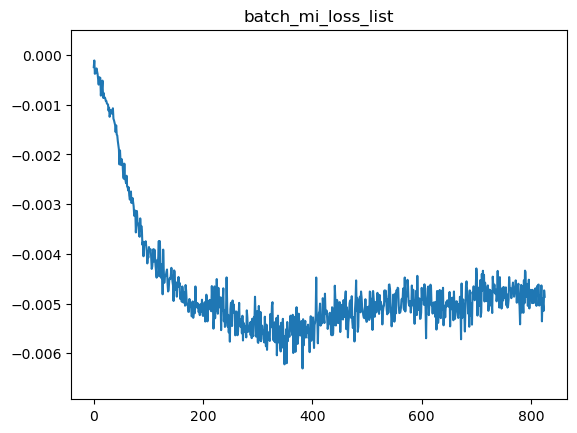

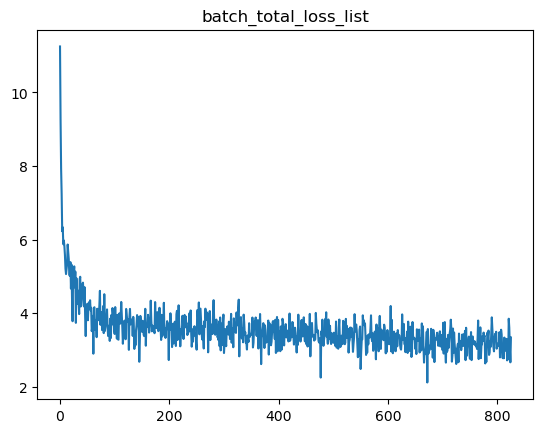

 40%|███████████████▌                       | 1651/4125 [08:03<14:12,  2.90it/s]

now batch:1651 in epoch 0


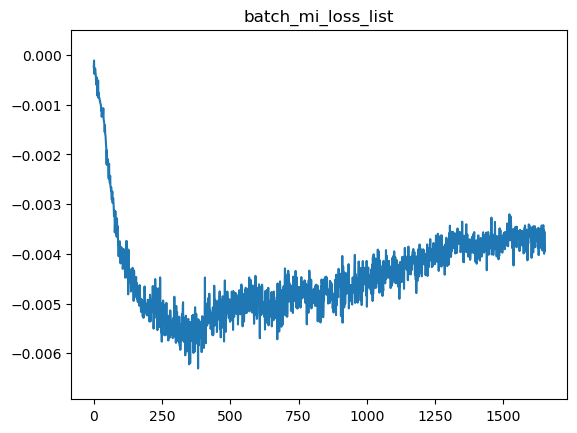

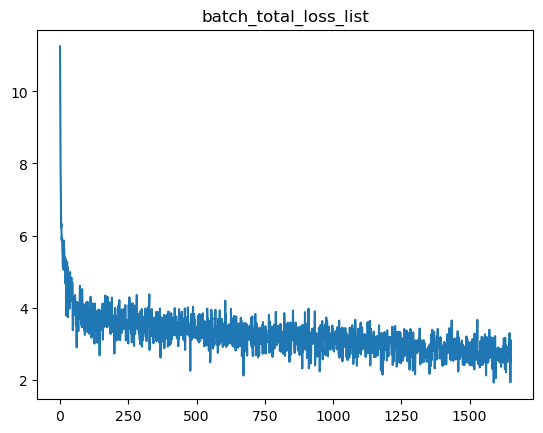

 60%|███████████████████████▍               | 2477/4125 [12:03<08:04,  3.40it/s]

now batch:2477 in epoch 0


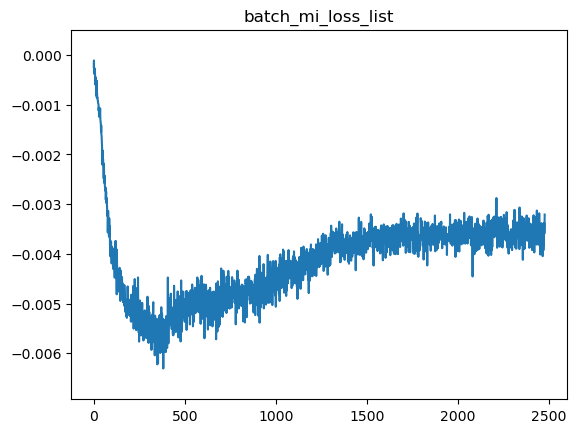

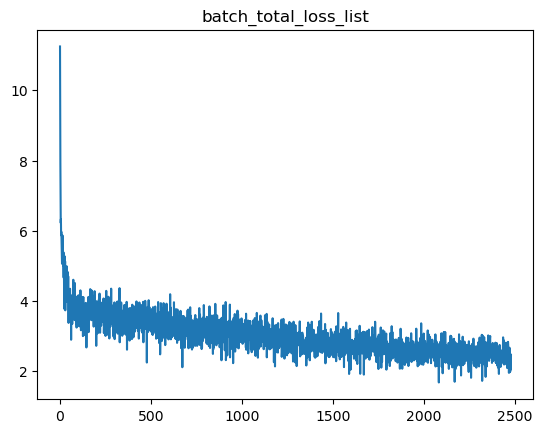

 80%|███████████████████████████████▏       | 3303/4125 [16:14<04:34,  2.99it/s]

now batch:3303 in epoch 0


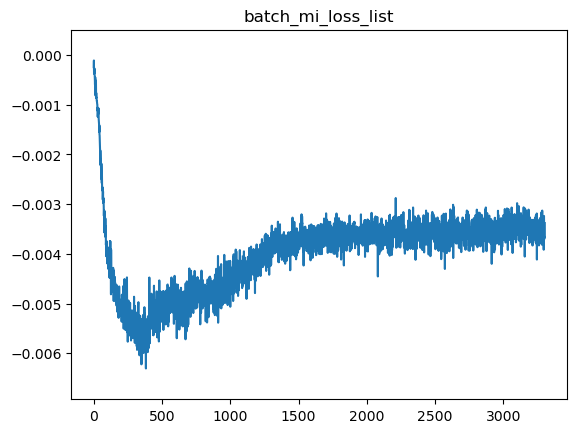

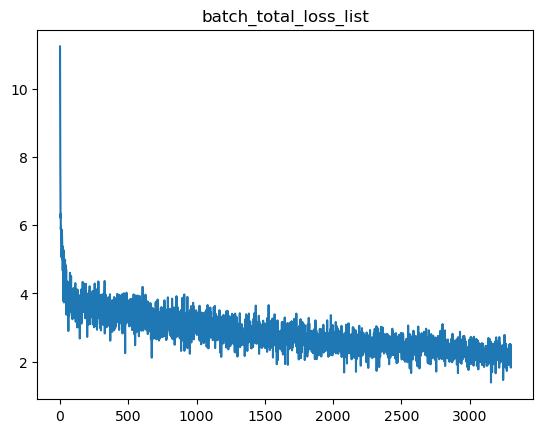

100%|███████████████████████████████████████| 4125/4125 [20:35<00:00,  3.34it/s]

============================== epoch: 0 loss: 11132.551600456238
train sample:
********************
 ['Perhaps', 'you', 'are', 'right', 'to', 'attack', 'us', ',', 'Mr', 'Pirker', ',', 'when', 'we', 'think', 'slightly', 'beyond', 'what', 'is', 'planned', 'here', 'in', 'this', 'document', '<eos>'] 
->
 ['He', 'you', 'are', 'so', 'to', 'be', ',', ',', 'Mr', 'President', ',', 'but', 'we', 'think', 'which', 'is', 'its', 'is', 'what', 'in', 'in', 'the', 'matter', '<eos>']
********************
 ['I', 'sort', 'of', 'realized', 'at', 'some', 'point', 'that', 'this', 'was', 'mostly', 'in', 'my', 'head', ',', 'it', 'wasnt', 'ac@@', 'ta@@', 'ul@@', 'ly', 'true', '<eos>', '<pad>'] 
->
 ['I', 'love', 'of', 'every', 'at', 'any', 'at', 'that', 'was', 'was', 'going', 'in', 'my', 'time', ',', 'it', 'makes', 'my', 'over', 'and', 'and', '<eos>', '<eos>', '<pad>']
********************
 ['We', 'have', 'achieved', 'successes', 'in', 'combating', 'trafficking', 'in', 'human', 'beings', ',', 'which', 'is', 'a'

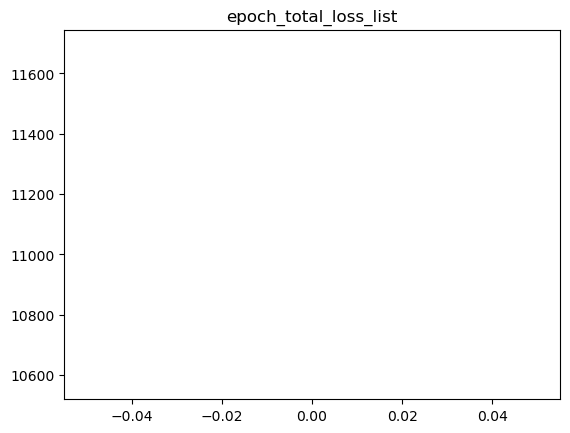

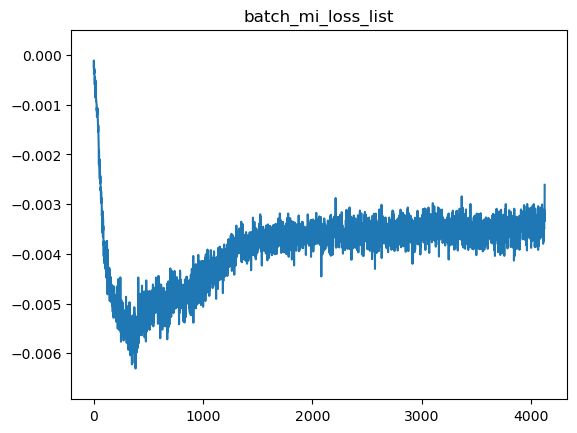

100%|█████████████████████████████████████████| 459/459 [01:58<00:00,  3.88it/s]

val sample:
********************
 ['The', 'fact', 'that', 'this', 'proposal', 'has', 'been', 'brought', 'forward', 'by', 'the', 'Commission', 'represents', 'a', 'remarkable', 'achievement', 'in', 'action', 'taken', 'to', 'control', 'rab@@', 'ies', '<eos>'] 
->
 ['The', 'fact', 'that', 'this', 'report', 'has', 'been', 'removed', 'by', 'the', 'future', 'in', 'their', 'own', 'to', 'move', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ['Mrs', 'Van', 'den', 'Burg', ',', 'in', 'order', 'to', 'reach', 'a', 'workable', 'compromise', ',', 'we', 'will', 'agree', 'on', 'Amendment', 'Nos', '4', 'and', '5', '<eos>', '<pad>'] 
->
 ['For', 'many', 'days', ',', 'in', 'order', 'to', 'make', 'a', 'banned', 'topic', 'will', 'on', 'the', 'other', 'and', 'more', 'and', 'all', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>

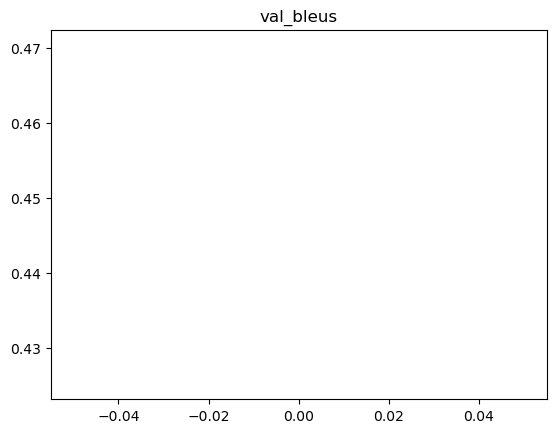

 20%|████████                                | 825/4125 [04:14<16:10,  3.40it/s]

now batch:825 in epoch 1


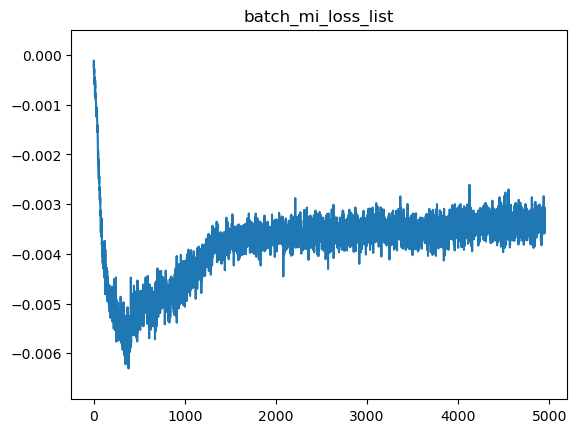

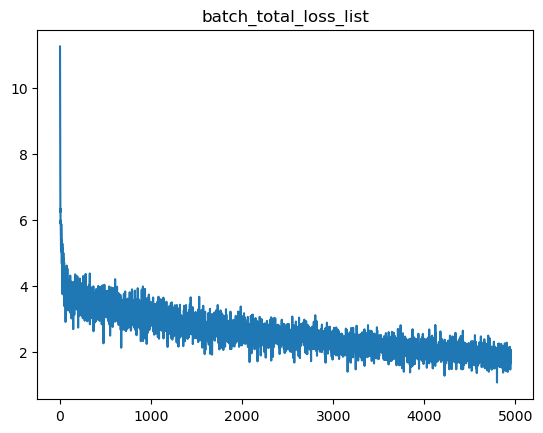

 40%|███████████████▌                       | 1651/4125 [08:17<13:41,  3.01it/s]

now batch:1651 in epoch 1


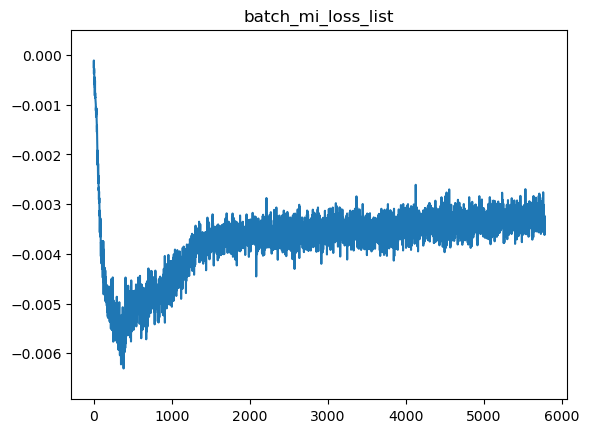

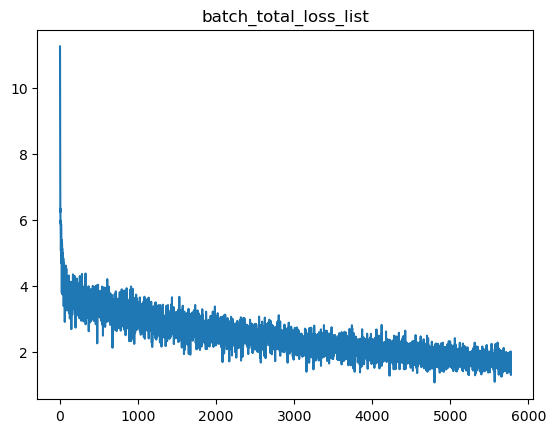

 60%|███████████████████████▍               | 2477/4125 [12:18<08:59,  3.06it/s]

now batch:2477 in epoch 1


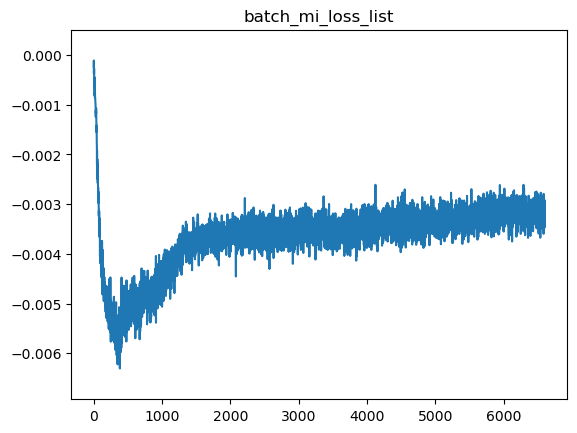

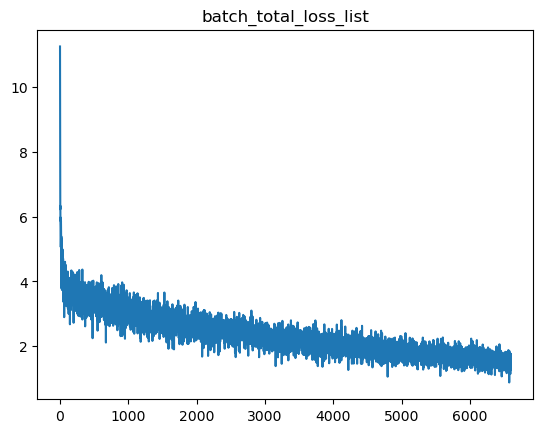

 80%|███████████████████████████████▏       | 3303/4125 [16:15<03:44,  3.66it/s]

now batch:3303 in epoch 1


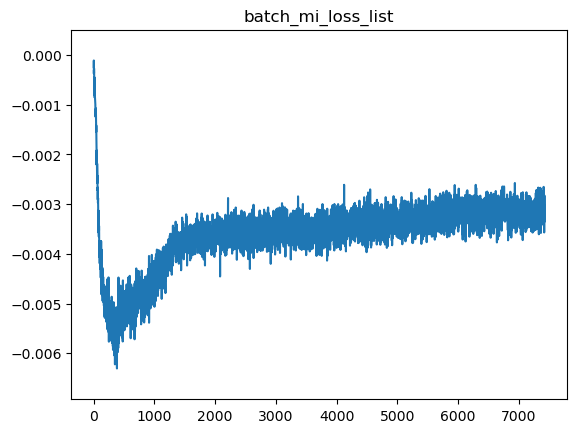

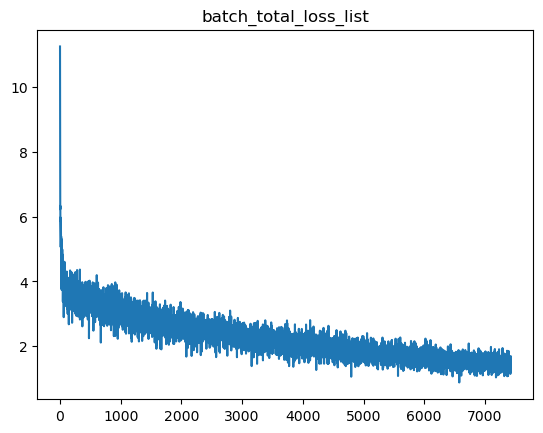

100%|███████████████████████████████████████| 4125/4125 [20:08<00:00,  3.41it/s]

============================== epoch: 1 loss: 6691.521433055401
train sample:
********************
 ['Let', 'me', 'point', 'out', 'that', 'the', 'General', 'Affairs', 'Council', 'of', '11', 'June', 'approved', 'a', 'progress', 'report', 'on', 'the', 'Stabilisation', 'and', 'Association', 'Process', ',', 'including', 'an', 'assessment', 'of', 'Croatia', '<eos>'] 
->
 ['Let', 'me', 'point', 'out', 'that', 'the', 'Stability', 'industry', 'Council', 'of', 'EUR', 'carrying', 'a', 'a', 'report', 'report', 'on', 'the', 'following', 'and', 'social', ',', ',', 'including', 'our', 'important', '<eos>', 'our', '<eos>']
********************
 ['Indeed', ',', 'it', 'was', 'originally', 'a', 'quite', 'rude', 'thing', 'to', 'say', 'to', 'someone', 'who', 'had', 'put', 'a', 'lot', 'of', 'work', 'into', 'a', 'lengthy', 'post', 'or', 'a', 'rant', '<eos>', '<pad>'] 
->
 ['Indeed', ',', 'it', 'was', 'let', 'a', 'particularly', 'option', 'thing', 'to', 'say', 'to', 'ask', 'who', 'had', 'a', 'a', 'lot', 'of'

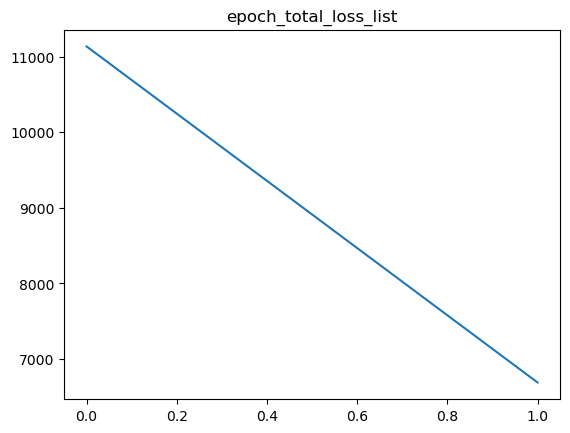

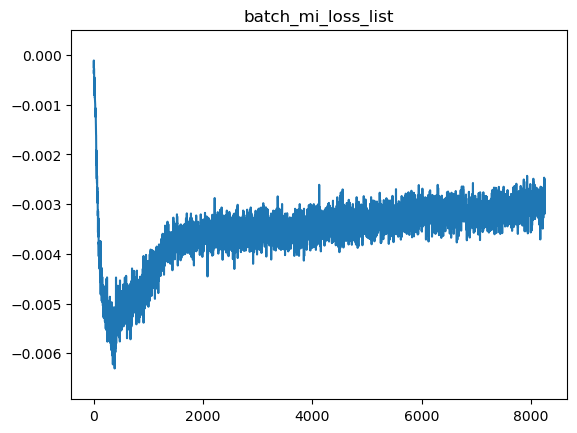

100%|█████████████████████████████████████████| 459/459 [02:00<00:00,  3.82it/s]

val sample:
********************
 ['As', 'for', 'planning', 'i', 'had', 'a', 'vague', 'idea', 'of', 'what', 'i', 'wanted', 'to', 'do', 'in', 'life', 'until', 'my', 'plans', 'were', 'ruined', 'by', 'the', 'presidency', 'and', 'his', 'administration', '<eos>'] 
->
 ['As', 'for', 'fear', 'i', 'had', 'a', 'idea', 'of', 'what', 'who', 'do', 'to', 'do', 'in', 'my', 'group', 'and', 'the', 'main', 'policy', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ['The', 'OECD', 'countries', 'spend', 'USD', '350', 'billion', 'a', 'year', 'on', 'subsidies', 'compared', 'to', 'USD', '50', 'billion', 'a', 'year', 'for', 'development', 'cooperation', 'purposes', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->
 ['The', 'original', 'Mr', 'Van', 'es', 'ched', 'a', 'year', 'on', 'relation', 'compared', 'to', 'develop', 'a', 'year', '<eos>', '<pad>', '<pad>',

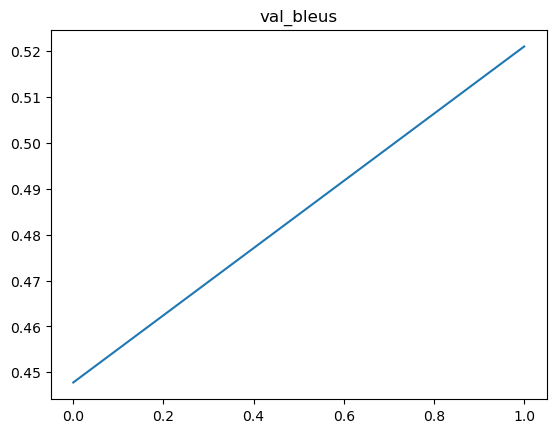

 20%|████████                                | 825/4125 [03:56<15:50,  3.47it/s]

now batch:825 in epoch 2


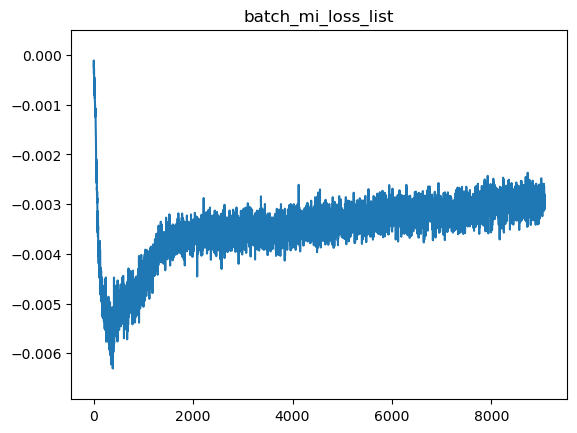

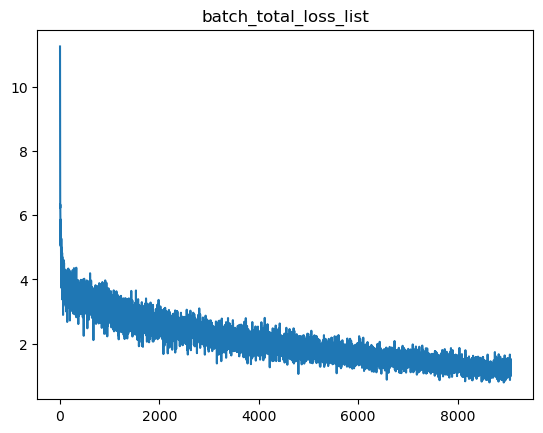

 40%|███████████████▌                       | 1651/4125 [07:50<11:47,  3.50it/s]

now batch:1651 in epoch 2


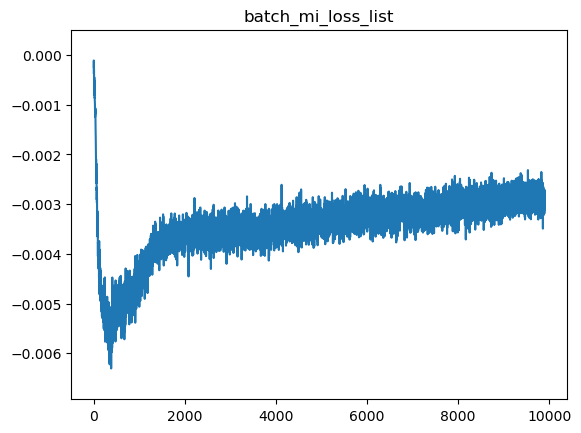

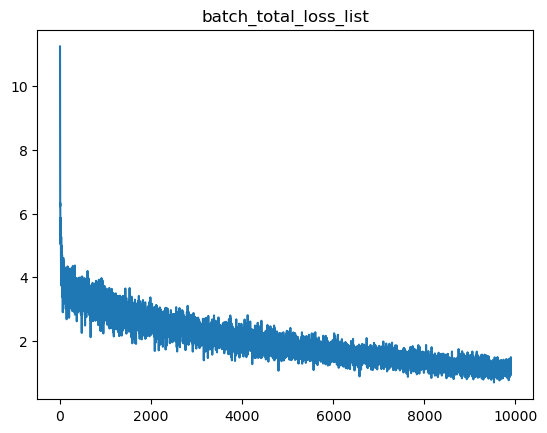

 60%|███████████████████████▍               | 2477/4125 [11:41<07:40,  3.58it/s]

now batch:2477 in epoch 2


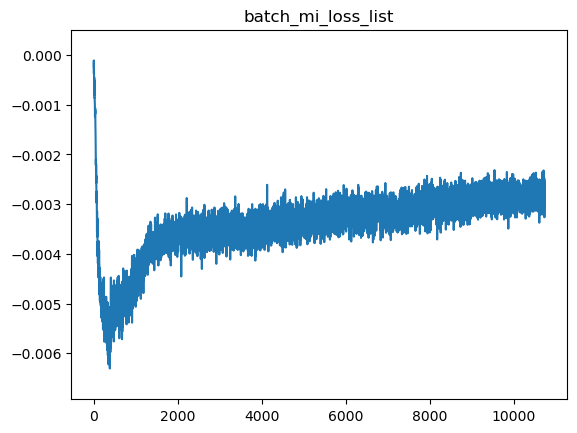

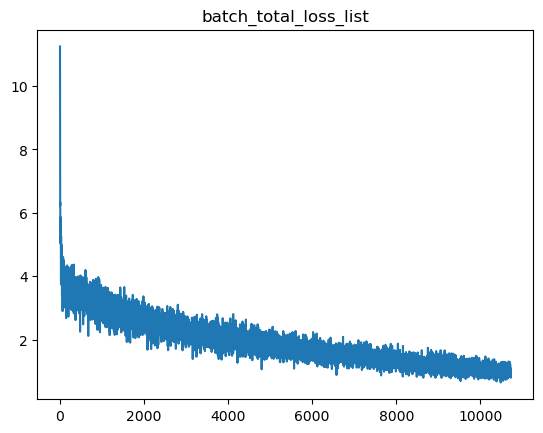

 80%|███████████████████████████████▏       | 3303/4125 [15:33<03:32,  3.87it/s]

now batch:3303 in epoch 2


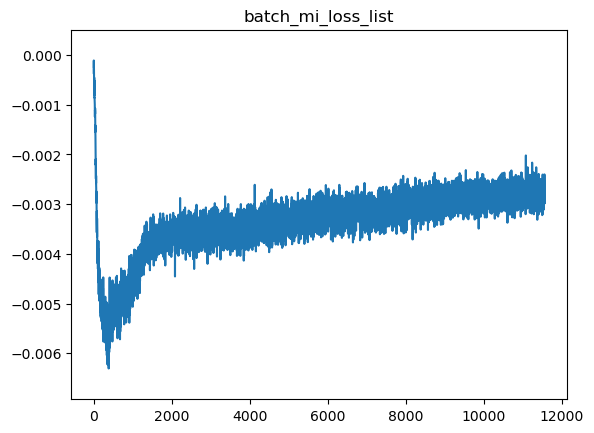

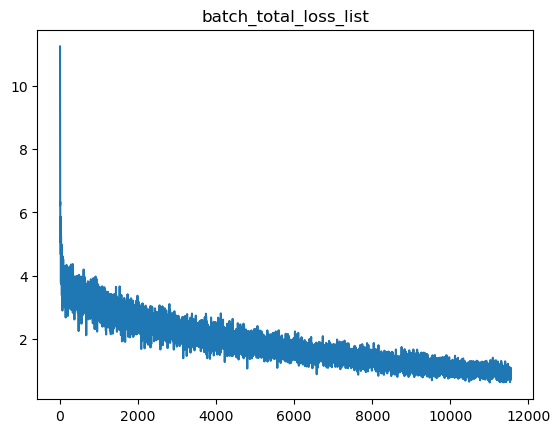

100%|███████████████████████████████████████| 4125/4125 [19:26<00:00,  3.54it/s]

============================== epoch: 2 loss: 4312.566708505154
train sample:
********************
 ['These', 'are', ',', 'in', 'my', 'opinion', ',', 'the', 'areas', 'we', 'must', 'address', 'if', 'we', 'are', 'to', 'achieve', 'proper', ',', 'sound', 'implementation', 'of', 'the', 'budget', 'in', 'the', 'coming', 'years', '<eos>'] 
->
 ['These', 'are', ',', 'in', 'my', 'opinion', ',', 'the', 'areas', 'we', 'must', 'address', 'if', 'we', 'are', 'to', 'achieve', 'direct', ',', 'obviously', 'approved', 'of', 'the', 'start', 'in', 'the', 'end', 'years', '<eos>']
********************
 ['Some', 'of', 'my', 'favorite', 'things', 'to', 'do', 'are', 'watch', 'movies', ',', 'documentaries', ',', 'tv', 'shows', ',', 'and', 'listen', 'to', 'music', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->
 ['Some', 'of', 'my', 'favorite', 'things', 'to', 'do', 'are', 'horrible', 'big', ',', 'hey', ',', 'Spotify', 'information', ',', 'and', 'listen', 'to', 'music', '<eos>

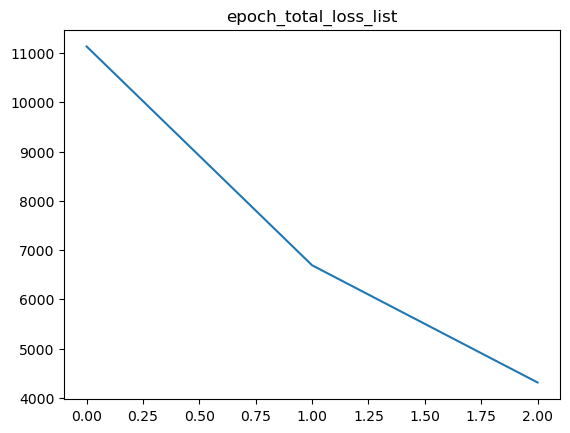

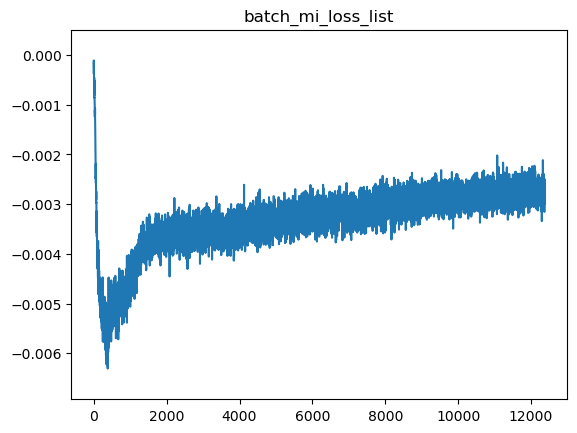

100%|█████████████████████████████████████████| 459/459 [01:58<00:00,  3.88it/s]

val sample:
********************
 ['Before', 'any', 'substance', 'may', 'be', 'authorised', 'for', 'use', 'as', 'a', 'food', 'addi@@', 'tive', ',', 'it', 'must', ',', 'in', 'principle', ',', 'be', 'subjected', 'to', 'tox@@', 'ic@@', 'ological', 'assessment', '<eos>'] 
->
 ["They're", 'any', 'ability', 'may', 'be', 'brought', 'for', 'use', 'as', 'a', 'strong', 'scope', ',', 'it', ',', 'in', 'principle', ',', 'be', 'drawn', 'to', 'function', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ['This', 'would', 'allow', 'us', 'to', 'move', 'ahead', 'constructively', 'for', 'the', 'sake', 'of', 'European', 'investors', ',', 'European', 'industry', 'and', 'the', 'European', 'economy', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->
 ['This', 'would', 'allow', 'us', 'to', 'fight', 'requirements', 'for', 'the', 'sake', 'of', 'European', 'institutions', 

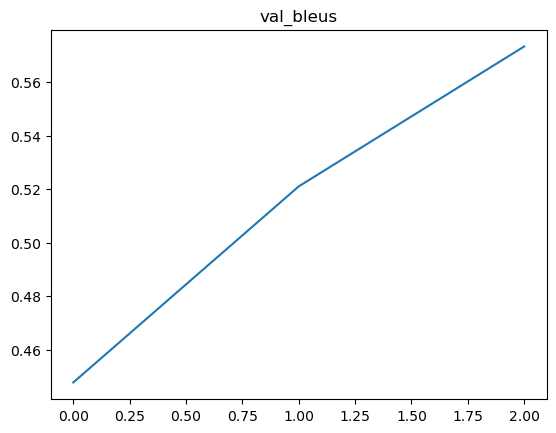

 20%|████████                                | 825/4125 [03:59<15:33,  3.54it/s]

now batch:825 in epoch 3


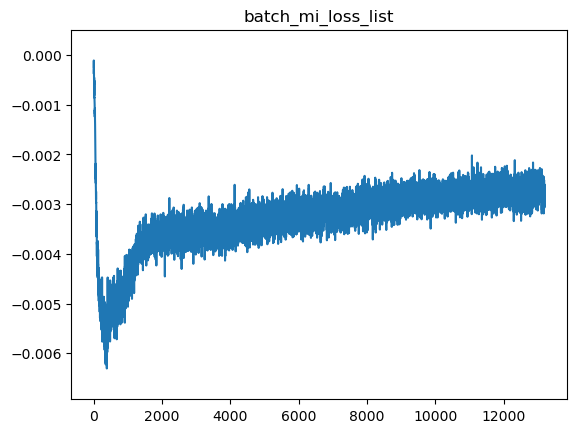

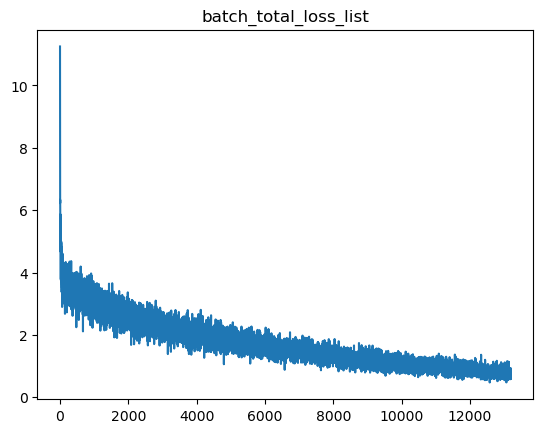

 40%|███████████████▌                       | 1651/4125 [07:51<11:18,  3.64it/s]

now batch:1651 in epoch 3


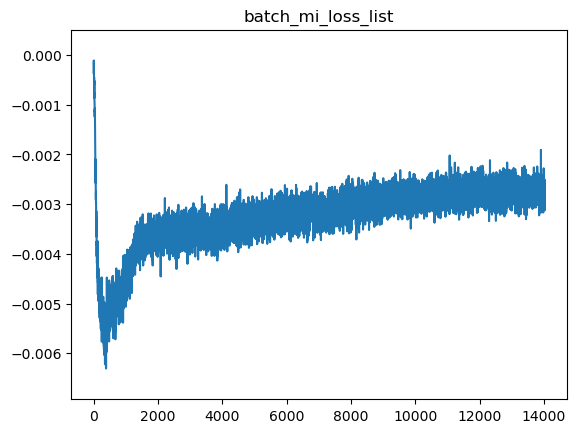

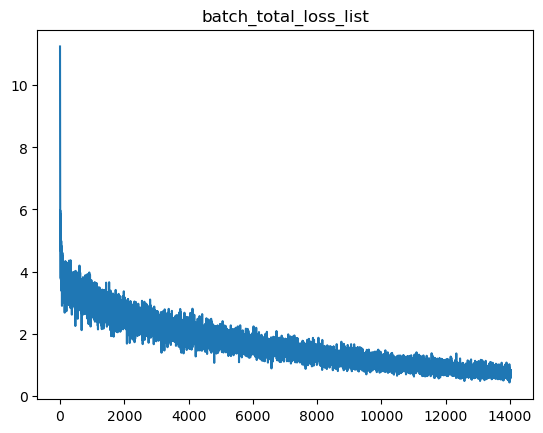

 60%|███████████████████████▍               | 2477/4125 [11:45<08:00,  3.43it/s]

now batch:2477 in epoch 3


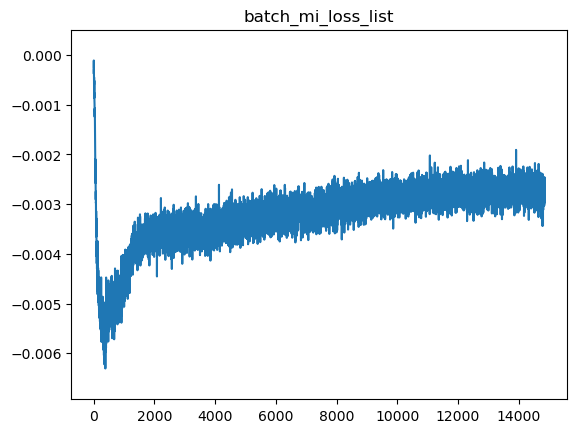

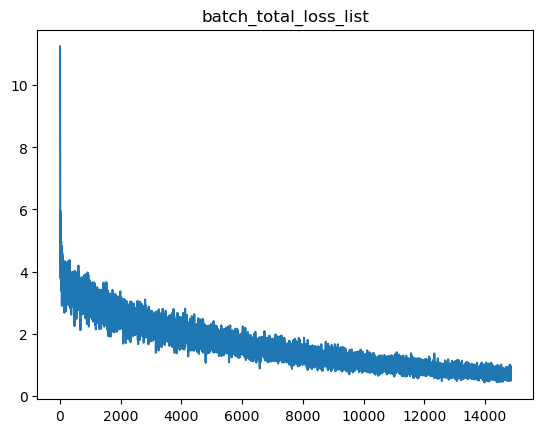

 80%|███████████████████████████████▏       | 3303/4125 [15:38<03:44,  3.66it/s]

now batch:3303 in epoch 3


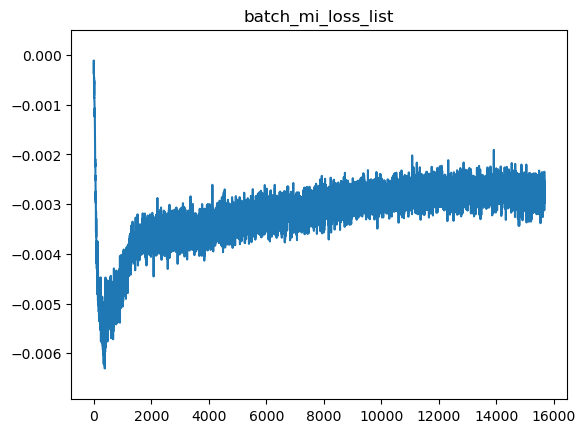

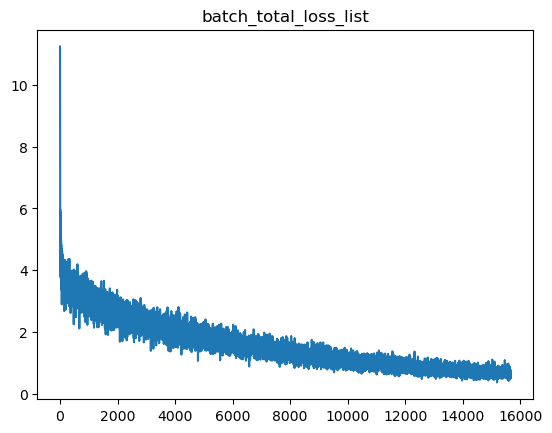

100%|███████████████████████████████████████| 4125/4125 [19:28<00:00,  3.53it/s]

============================== epoch: 3 loss: 2950.6598702669144
train sample:
********************
 ['Of', 'course', 'the', 'Member', 'States', 'cannot', 'shake', 'off', 'their', 'own', 'responsibilities', ',', 'if', 'there', 'are', 'irregularities', 'or', 'fraud', 'in', 'the', 'Member', 'States', ',', 'the', 'Commission', 'must', 'act', 'accordingly', '<eos>'] 
->
 ['Of', 'course', 'the', 'Member', 'States', 'cannot', 'prohibit', 'off', 'their', 'own', 'waste', ',', 'if', 'there', 'are', 'justified', 'or', 'addressed', 'in', 'the', 'Member', 'States', ',', 'the', 'Commission', 'must', 'act', '<eos>', '<eos>']
********************
 ['If', 'that', 'is', 'enough', 'to', 'be', 'considered', 'severe', 'trauma', 'I', 'am', 'the', 'most', 'well', 'adjusted', '25', 'year', 'old', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->
 ['If', 'that', 'is', 'trying', 'to', 'be', 'huge', 'yet', 'I', 'I', 'am', 'the', 'most', 'going', 'adjusted', '

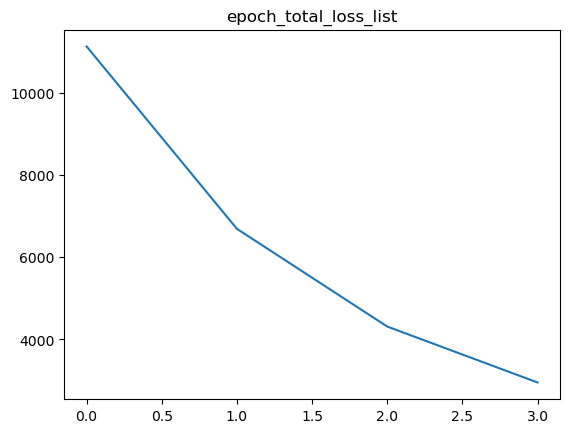

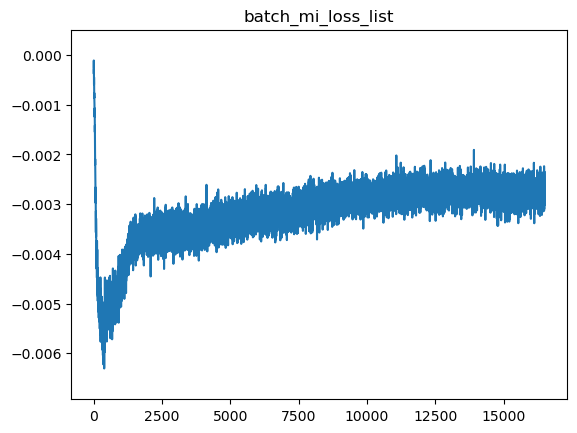

100%|█████████████████████████████████████████| 459/459 [02:10<00:00,  3.51it/s]

val sample:
********************
 ['Such', 'respect', ',', 'combined', 'with', 'a', 'ban', 'on', 'discrimination', ',', 'creates', 'a', 'basis', 'for', 'securing', 'the', 'position', 'of', 'minorities', 'in', 'the', 'future', '<eos>'] 
->
 ['Such', 'respect', ',', 'combined', 'with', 'a', 'ban', 'on', 'civilisation', ',', 'a', 'basis', 'for', 'guidelines', 'for', 'the', 'position', 'of', 'exercise', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ['Weird', 'question:', 'is', 'your', 'new', 'username', 'a', 'reference', 'to', 'a', 'D&D', 'game', 'at', 'a', 'university', 'in', 'Illinois', '?', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->
 ['Weird', 'boys', 'is', 'your', 'new', 'username', 'a', 'reference', 'to', 'a', 'Christmas', 'game', 'at', 'a', 'university', 'in', 'Strasbourg', '?', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '

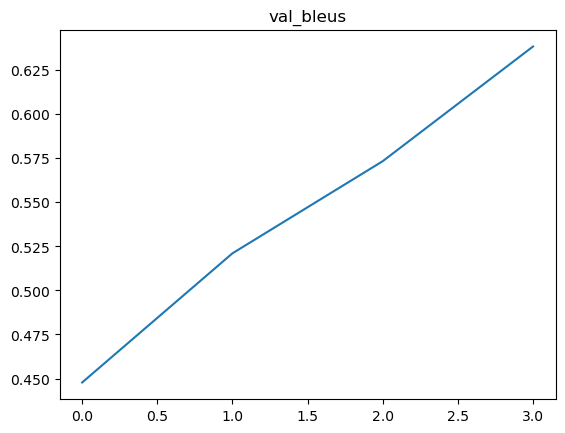

 20%|████████                                | 825/4125 [03:55<15:04,  3.65it/s]

now batch:825 in epoch 4


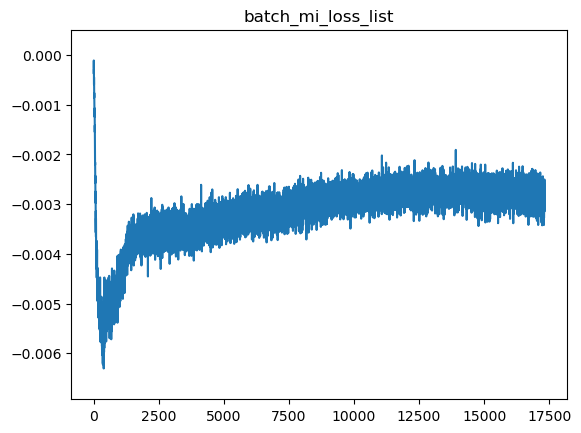

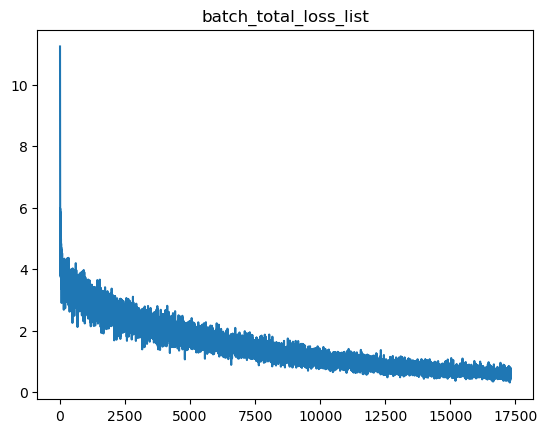

 40%|███████████████▌                       | 1651/4125 [07:53<10:39,  3.87it/s]

now batch:1651 in epoch 4


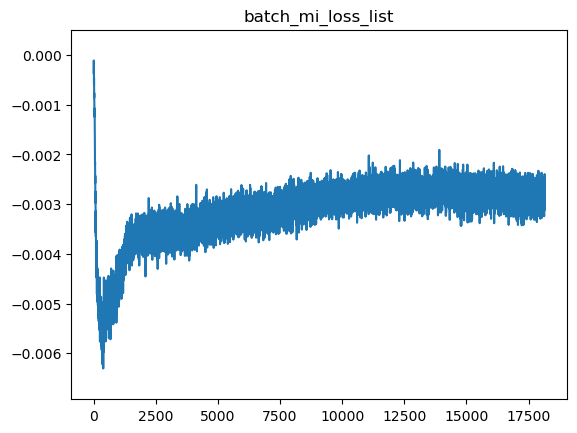

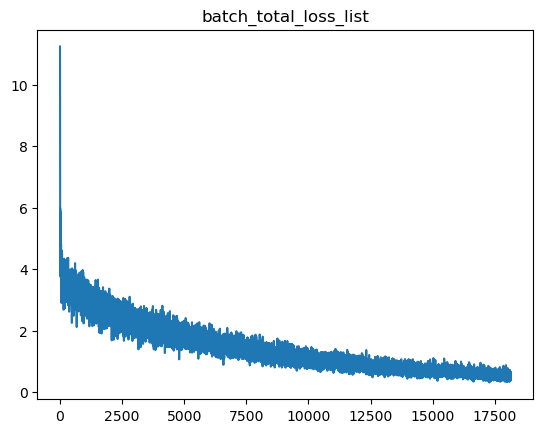

 60%|███████████████████████▍               | 2477/4125 [11:43<07:28,  3.67it/s]

now batch:2477 in epoch 4


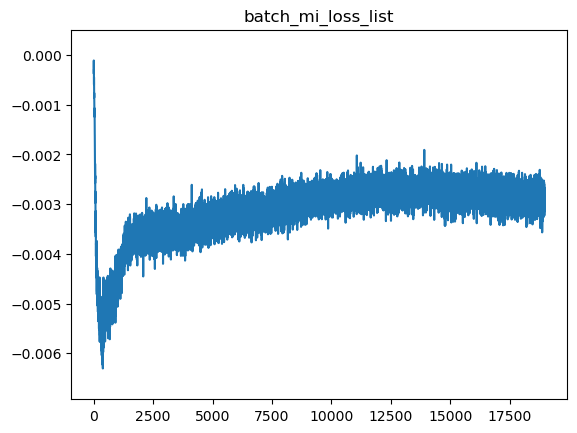

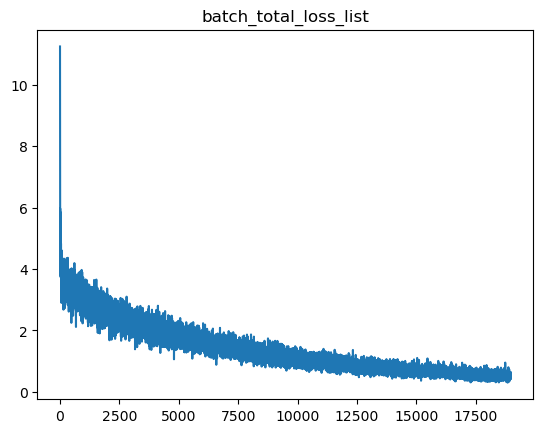

 80%|███████████████████████████████▏       | 3303/4125 [15:34<03:45,  3.65it/s]

now batch:3303 in epoch 4


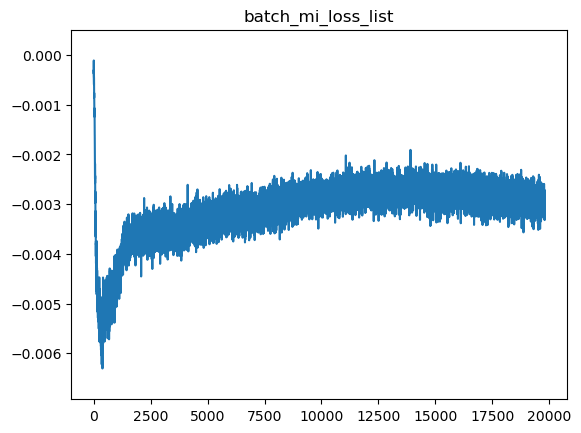

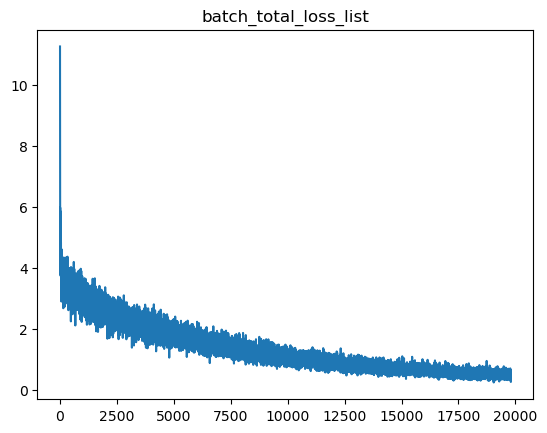

100%|███████████████████████████████████████| 4125/4125 [19:23<00:00,  3.54it/s]


============================== epoch: 4 loss: 2163.541488289833
train sample:
********************
 ['I', 'really', 'like', 'the', 'stories', 'of', 'people', 'who@@', "'re", 'initially', 'friends', ',', 'but', 'then', 'they', 'develop', 'feelings', 'for', 'each', 'other', '<eos>'] 
->
 ['I', 'really', 'like', 'the', 'piece', 'of', 'people', 'marry', 's;', 'p@@', 'friends', ',', 'but', 'then', 'they', 'develop', 'act', 'for', 'each', 'other', '<eos>']
********************
 ['It', 'is', 'not', 'possible', 'for', 'all', 'farmers', 'to', 'pay', 'in', 'equal', 'measure', 'for', 'the', 'reduction', 'in', 'the', 'budget', 'for', 'agriculture', '<eos>'] 
->
 ['It', 'is', 'not', 'possible', 'for', 'all', 'rapporteur', 'to', 'pay', 'in', 'public', 'measure', 'for', 'the', 'reduction', 'in', 'the', 'budget', 'for', 'agriculture', '<eos>']
********************
 ['Its', 'helped', 'a', 'lot', ':)', 'people', 'who', 'dont', 'click', 'with', 'me', 'arent', 'something', 'to', 'bat', 'an', 'eye', 'at', 

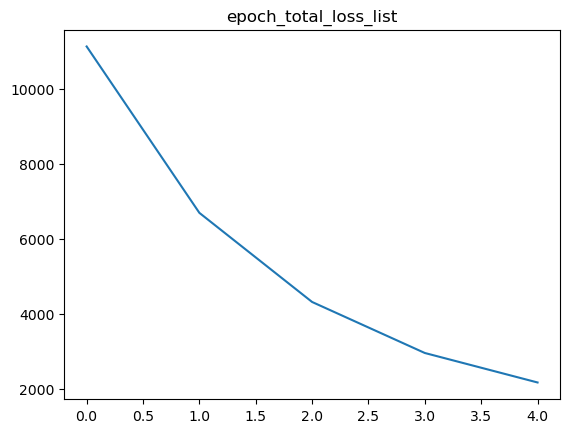

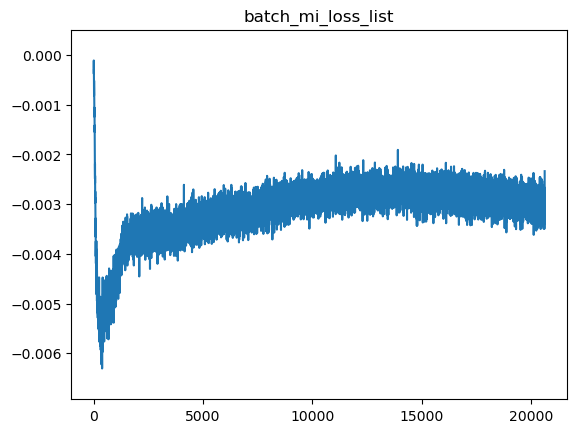

100%|█████████████████████████████████████████| 459/459 [02:24<00:00,  3.17it/s]

val sample:
********************
 ['Because', 'if', 'it', "wasn't", 'the', 'latter', 'I', 'suppose', 'an', 'apo@@', 'logy', 'could', 'just', 'solve', 'that', ',', 'and', 'if', 'it', 'was', 'some', 'weird', 'Shit', ',', 'time', 'he@@', 'als', 'that', 'too', '<eos>'] 
->
 ['Because', 'if', 'it', "wasn't", 'the', 'latter', 'I', 'suppose', 'an', 'approximation', 'could', 'just', 'definitely', 'that', ',', 'and', 'if', 'it', 'was', 'a', 'weird', ',', 'busy', ',', 'time', 'itll', 'that', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ['I', 'miss', 'having', 'coffee', 'and', 'a', 'rehab', 'every', 'day', 'but', 'its', 'great', 'to', 'be', 'able', 'to', 'use', 'them', 'to', 'stay', 'awake', 'on', 'long', 'trips', 'and', 'such', '<eos>', '<pad>', '<pad>', '<pad>'] 
->
 ['I', 'miss', 'having', 'coffee', 'and', 'a', 'rehab', 'every', 'day', 'but', 'its', 'great', 'to', 'be', 'able', 'to', 'them', 'to', 'stay', 'in'

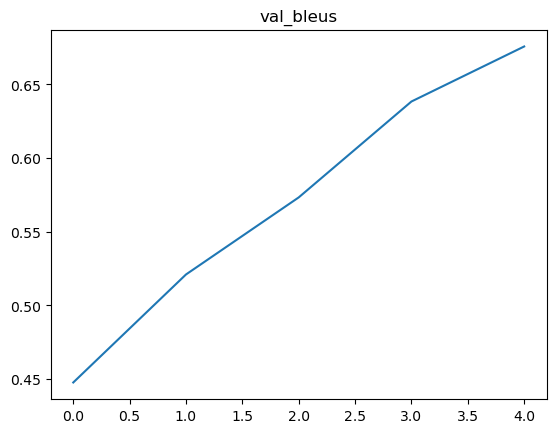

 20%|████████                                | 825/4125 [03:58<14:34,  3.78it/s]

now batch:825 in epoch 5


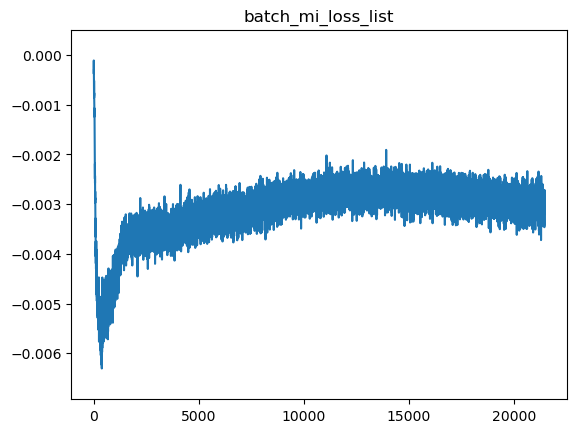

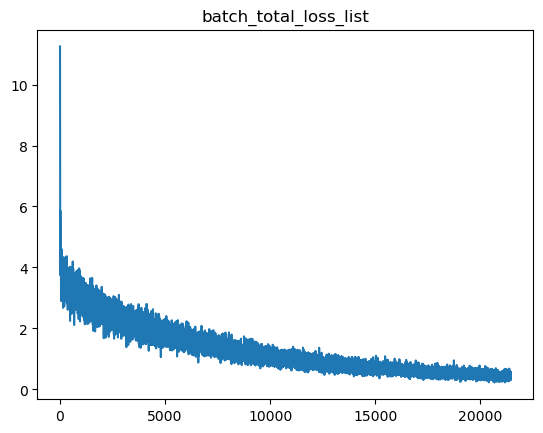

 40%|███████████████▌                       | 1651/4125 [07:51<10:56,  3.77it/s]

now batch:1651 in epoch 5


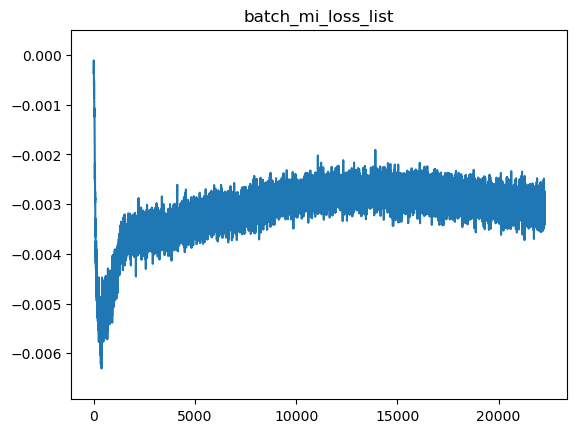

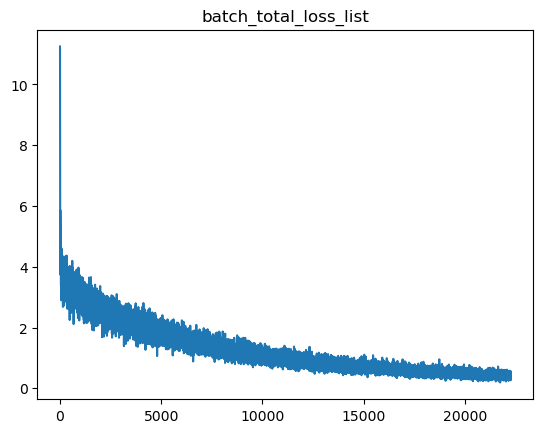

 60%|███████████████████████▍               | 2477/4125 [11:49<07:28,  3.68it/s]

now batch:2477 in epoch 5


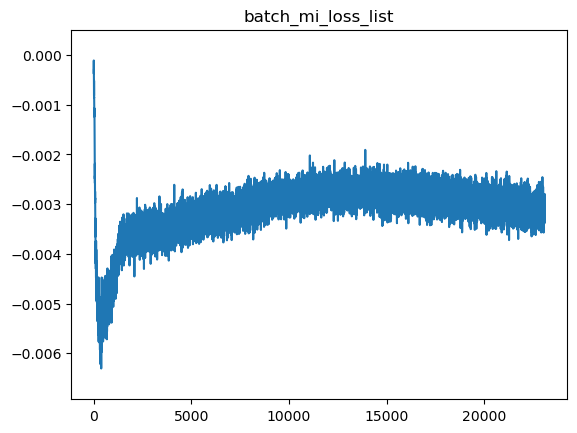

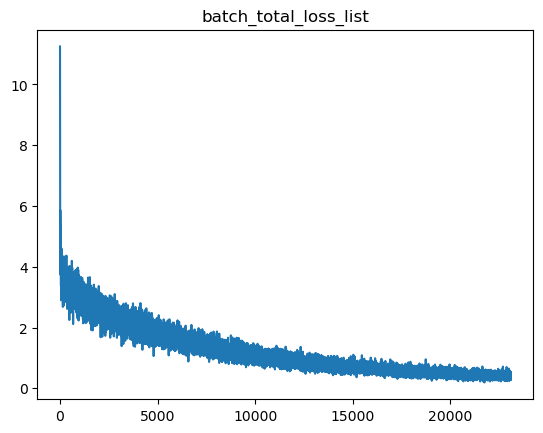

 80%|███████████████████████████████▏       | 3303/4125 [15:44<03:32,  3.87it/s]

now batch:3303 in epoch 5


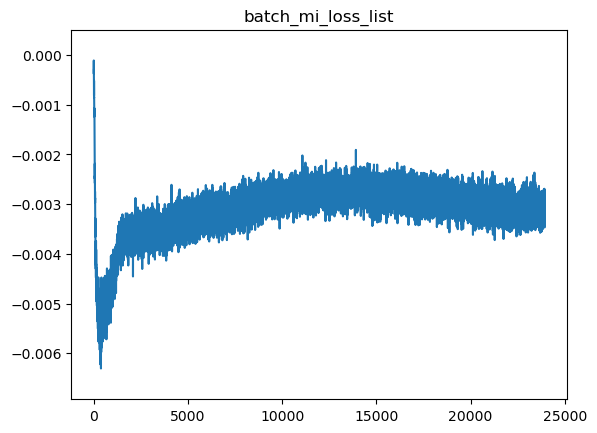

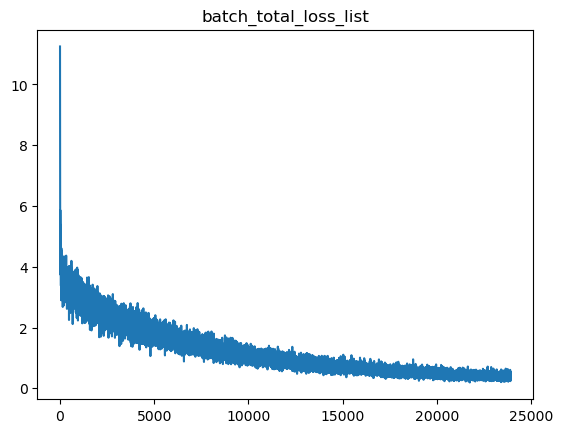

100%|███████████████████████████████████████| 4125/4125 [19:44<00:00,  3.48it/s]

============================== epoch: 5 loss: 1663.2329776883125
train sample:
********************
 ['No', 'shower', 'should', 'last', 'longer', 'than', '30', 'seconds', ',', 'I', 'bathe', 'in', 'fire', 'and', 'my', 'skin', 'is', 'bright', 'red', ',', 'AMA', '<eos>'] 
->
 ['No', 'mine', 'should', 'last', 'longer', 'than', '30', 'ks', ',', 'I', 'read)', 'in', 'fire', 'and', 'my', 'unqualified', 'is', 'ign@@', 'red', ',', 'enjoyable', '<eos>']
********************
 ['Most', 'people', 'these', 'days', "don't", 'seem', 'to', 'know', 'that', 'tl;dr', 'was', 'originally', 'used', 'as', 'a', 'response', 'to', 'a', 'long', 'post', '<eos>', '<pad>'] 
->
 ['Most', 'people', 'these', 'days', "don't", 'seem', 'to', 'know', 'that', 'tl;dr', 'was', 'originally', 'used', 'as', 'a', 'response', 'to', 'a', 'nice', 'post', '<eos>', '<pad>']
********************
 ['I', 'try', 'to', 'comfort', 'myself', 'by', 'thinking', "it's", 'my', 'choice', ',', 'it', "doesn't", 'help', 'all', 'that', 'much', 'tho', 

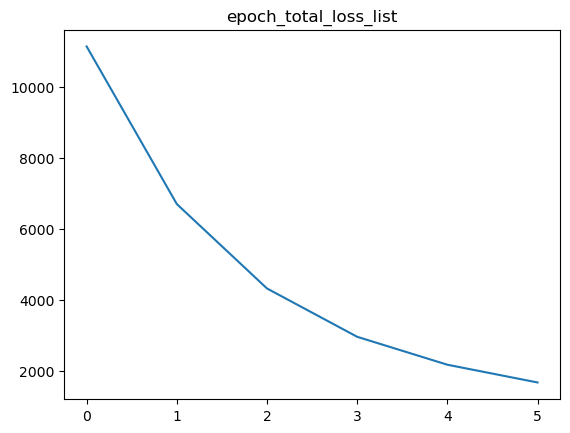

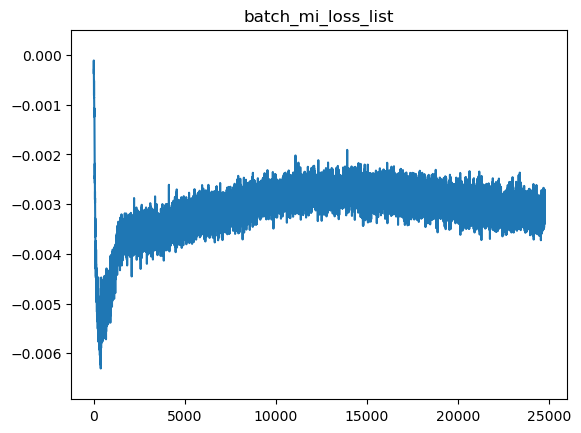

100%|█████████████████████████████████████████| 459/459 [02:36<00:00,  2.94it/s]

val sample:
********************
 ['I', 'am', 'quite', 'aware', 'that', 'this', 'has', 'caused', 'concern', 'and', 'I', 'take', 'full', 'responsibility', ',', 'but', 'there', 'was', 'no', 'other', 'option', '<eos>'] 
->
 ['I', 'am', 'quite', 'aware', 'that', 'this', 'has', 'sent', 'concern', 'and', 'I', 'take', 'full', 'responsibility', ',', 'but', 'there', 'was', 'no', 'other', 'option', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ["I've", 'seen', '5@@', 'F@@', 'DP', 'live', '3', 'times', 'and', 'all', 'at', 'different', 'times', 'of', 'my', 'life', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->
 ["I've", 'seen', '5@@', 'F@@', 'bl@@', 'live', '3', 'times', 'and', 'all', 'at', 'different', 'times', 'of', 'my', 'life', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pa

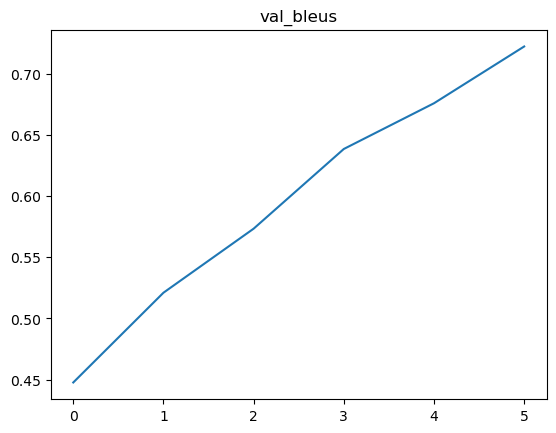

 20%|████████                                | 825/4125 [03:59<17:48,  3.09it/s]

now batch:825 in epoch 6


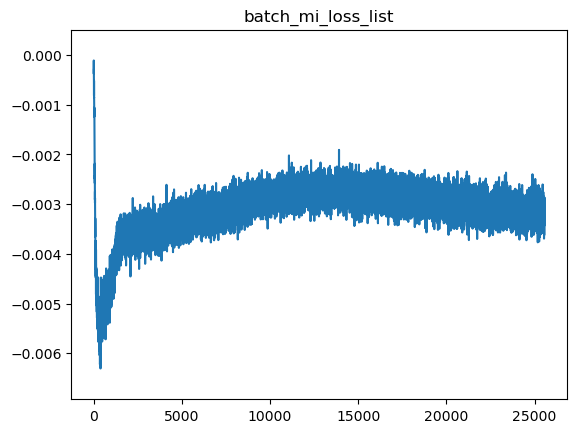

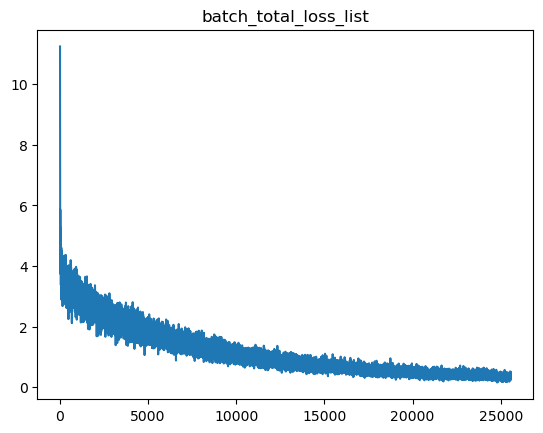

 40%|███████████████▌                       | 1651/4125 [07:59<11:59,  3.44it/s]

now batch:1651 in epoch 6


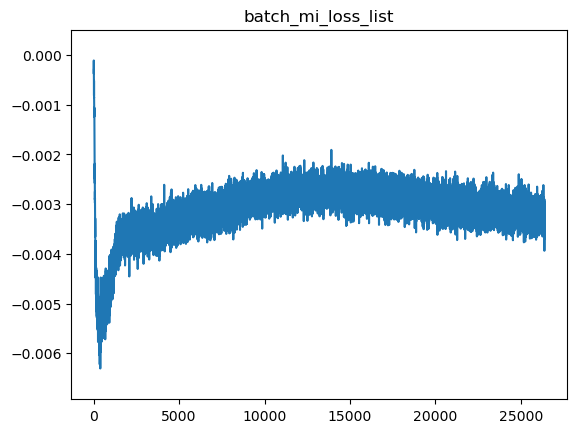

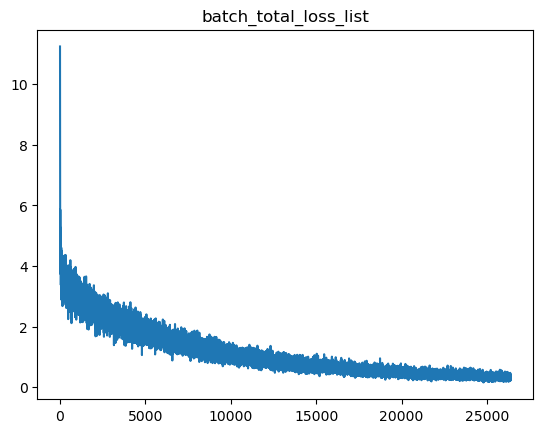

 60%|███████████████████████▍               | 2477/4125 [11:52<07:19,  3.75it/s]

now batch:2477 in epoch 6


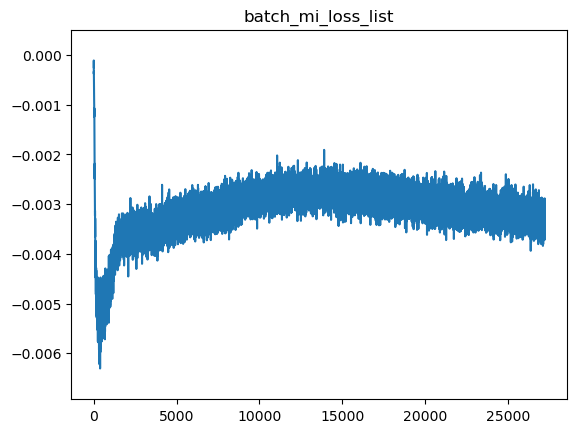

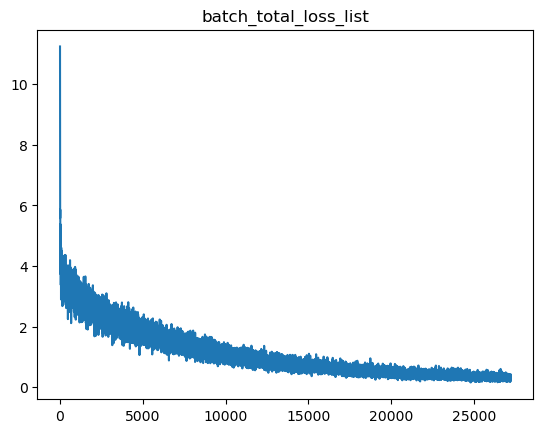

 80%|███████████████████████████████▏       | 3303/4125 [15:41<04:14,  3.23it/s]

now batch:3303 in epoch 6


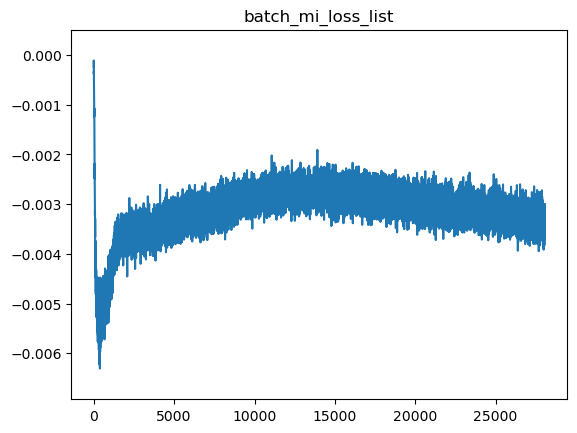

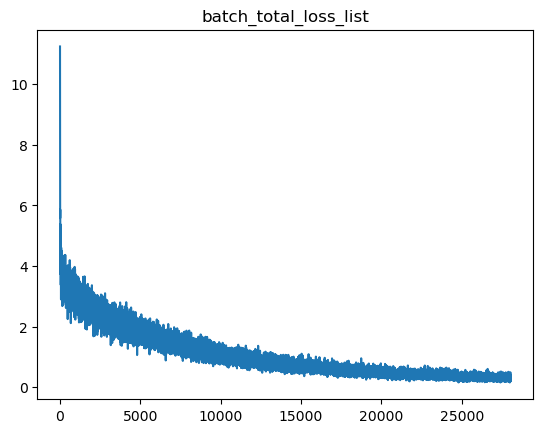

100%|███████████████████████████████████████| 4125/4125 [19:36<00:00,  3.51it/s]

============================== epoch: 6 loss: 1316.414632126689
train sample:
********************
 ['It', 'will', 'be', 'up', 'to', 'working', 'women', 'to', 'impose', 'equality', 'themselves', ',', 'joining', 'forces', 'with', 'the', 'workers', 'to', 'demand', 'a', 'living', 'wage', 'for', 'all', '<eos>'] 
->
 ['It', 'will', 'be', 'up', 'to', 'working', 'women', 'to', 'impose', 'institutions', 'themselves', ',', 'joining', 'faced', 'with', 'the', 'workers', 'to', 'demand', 'a', 'living', 'wage', 'for', 'all', '<eos>']
********************
 ['I', 'was', 'never', 'a', 'musical', 'person', 'or', 'anything', 'of', 'the', 'sort', ',', 'but', 'the', 'sound', 'of', 'a', 'piano', 'always', 'seemed', 'to', 'soothe', 'me', '<eos>', '<pad>'] 
->
 ['I', 'was', 'never', 'a', 'musical', 'person', 'or', 'anything', 'of', 'the', 'sort', ',', 'but', 'the', 'sound', 'of', 'a', 'mess', 'large', 'seemed', 'to', 'behave', 'me', '<eos>', '<pad>']
********************
 ['I', 'have', 'no', 'discipline', ','

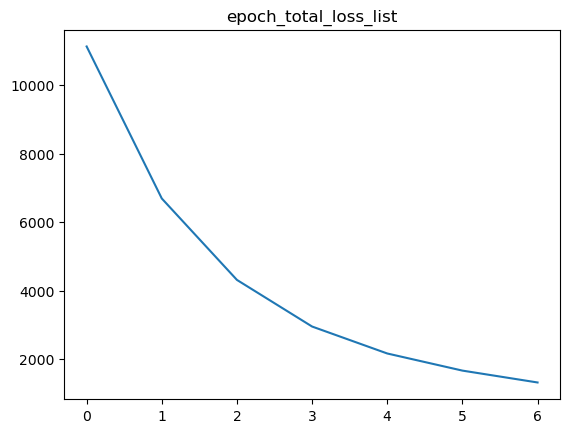

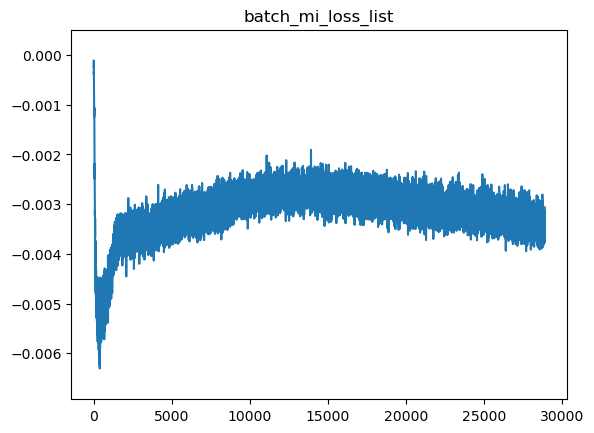

100%|█████████████████████████████████████████| 459/459 [02:25<00:00,  3.15it/s]

val sample:
********************
 ["I'd", 'say', "that's", 'a', 'fair', 'comparison', ',', "there's", 'a', 'lot', 'of', 'skill', 'involved', 'in', 'it', 'and', 'it', 'takes', 'a', 'while', 'to', 'get', 'good', 'but', 'once', 'you', 'do', 'it', 'feels', 'great', '<eos>'] 
->
 ["I'd", 'say', "that's", 'a', 'fair', 'comparison', ',', "there's", 'a', 'lot', 'of', 'skill', 'involved', 'in', 'it', 'and', 'it', 'takes', 'a', 'while', 'to', 'get', 'good', 'but', 'once', 'you', 'do', 'it', 'feels', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ['We', 'know', 'that', 'the', 'snow', 'cover', 'in', 'the', 'northern', 'hemisphere', 'has', 'decreased', 'by', '10', '%', 'since', 'the', 'end', 'of', 'the', '1960s', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->
 ['We', 'know', 'that', 'the', 'snow', 'cover', 'in', 'the', 'northern', 'Congress', 'has', 'chaired', 'by', '10', '%', 'since', 't

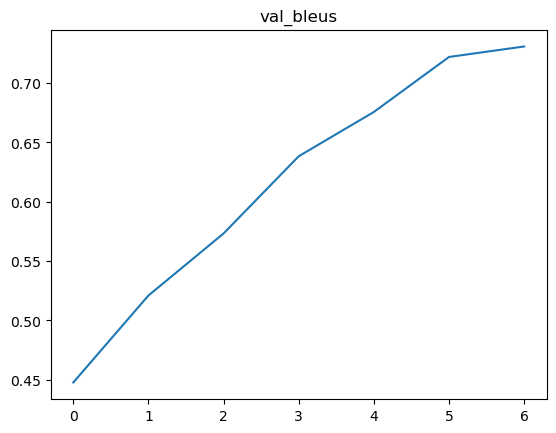

 20%|████████                                | 825/4125 [03:53<15:45,  3.49it/s]

now batch:825 in epoch 7


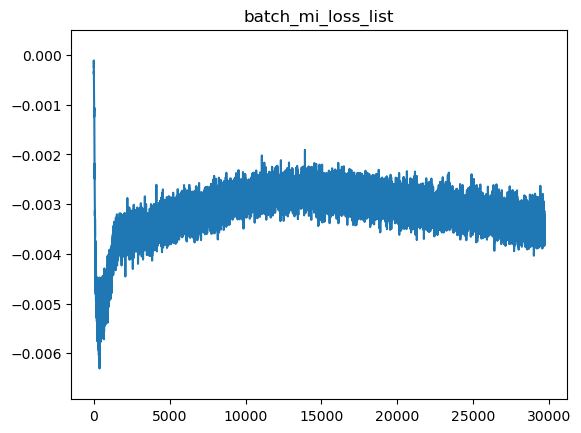

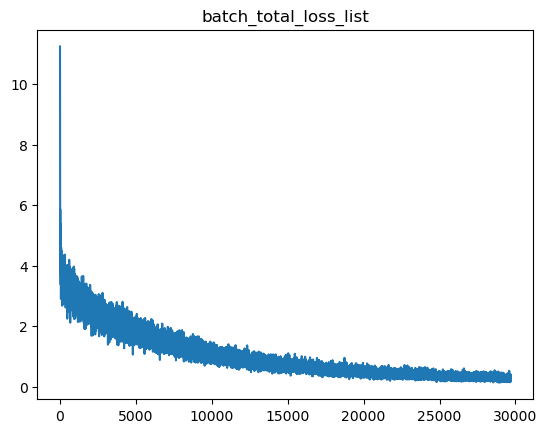

 40%|███████████████▌                       | 1651/4125 [07:55<11:21,  3.63it/s]

now batch:1651 in epoch 7


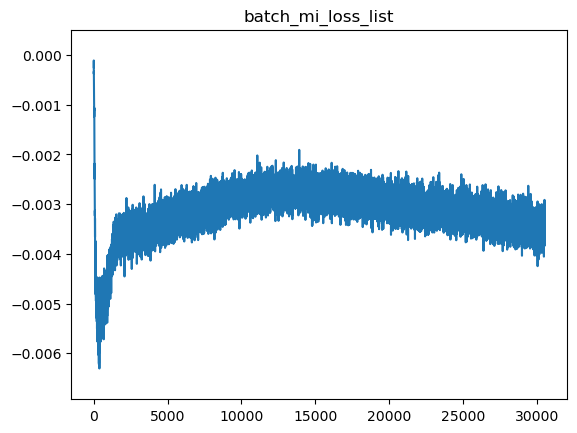

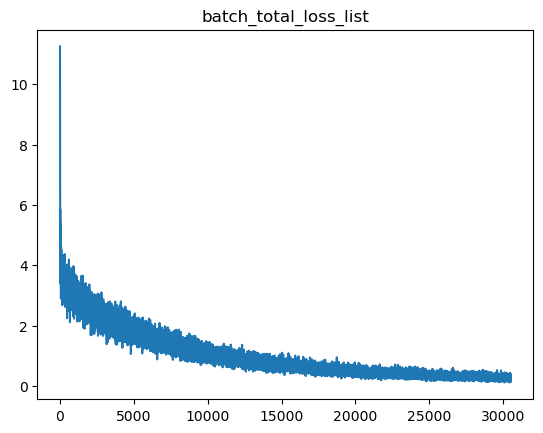

 60%|███████████████████████▍               | 2477/4125 [11:49<07:24,  3.70it/s]

now batch:2477 in epoch 7


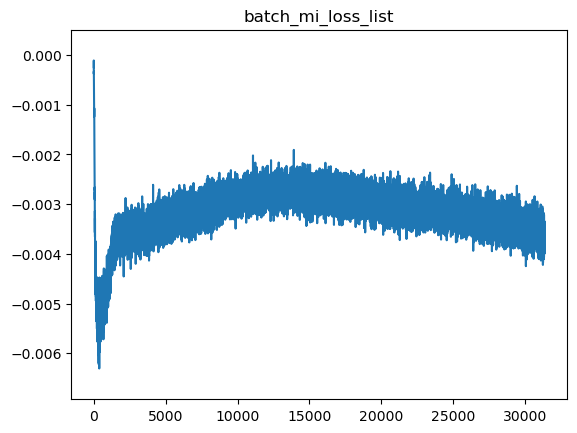

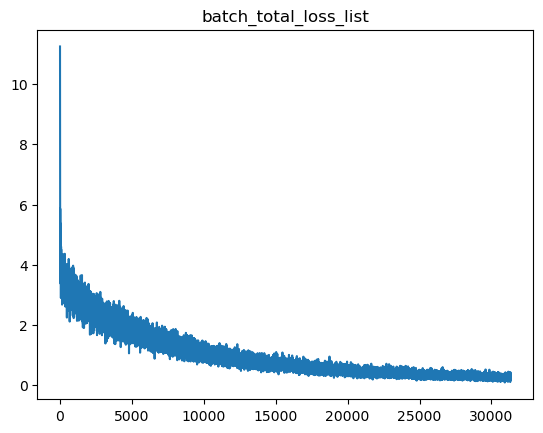

 80%|███████████████████████████████▏       | 3303/4125 [15:39<03:47,  3.62it/s]

now batch:3303 in epoch 7


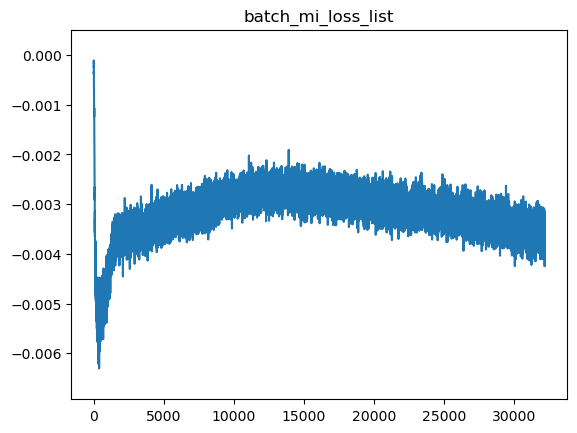

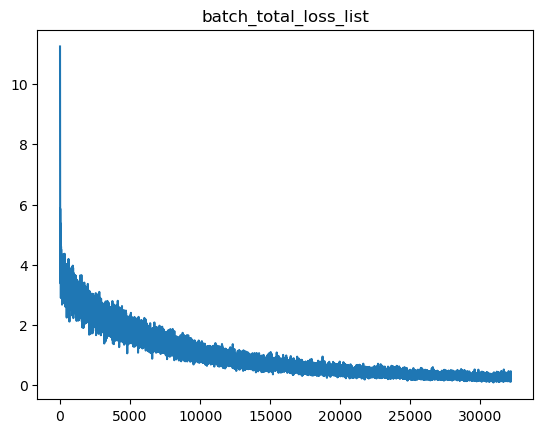

100%|███████████████████████████████████████| 4125/4125 [19:30<00:00,  3.52it/s]

============================== epoch: 7 loss: 1071.0979563742876
train sample:
********************
 ["I'm", '19', ',', 'just', 'got', 'a', 'job', 'at', 'a', 'relatively', 'large', 'retail', 'store', ',', 'made', 'so', 'many', 'new', 'friends', 'and', 'thought', 'I', 'would', 'be', 'really', 'happy', 'to', 'be', 'working', 'again', '<eos>'] 
->
 ["I'm", '19', ',', 'just', 'got', 'a', 'job', 'at', 'a', 'relatively', 'large', 'retail', 'store', ',', 'made', 'so', 'many', 'new', 'friends', 'and', 'thought', 'I', 'would', 'be', 'really', 'happy', 'to', 'be', 'working', 'again', '<eos>']
********************
 ['I', 'would', 'like', 'to', 'point', 'out', '-', 'although', 'you', 'already', 'know', '-', 'that', 'the', 'President', ',', 'together', 'with', 'her', 'office', ',', 'decides', 'on', 'the', 'order', 'of', 'questions', '<eos>', '<pad>', '<pad>', '<pad>'] 
->
 ['I', 'would', 'like', 'to', 'point', 'out', '-', 'although', 'you', 'already', 'know', '-', 'that', 'the', 'President', ',', '

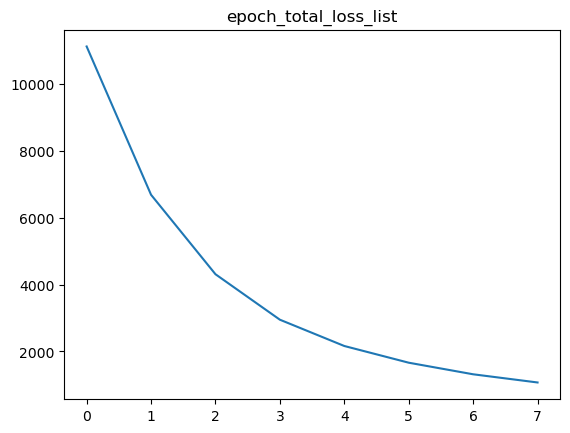

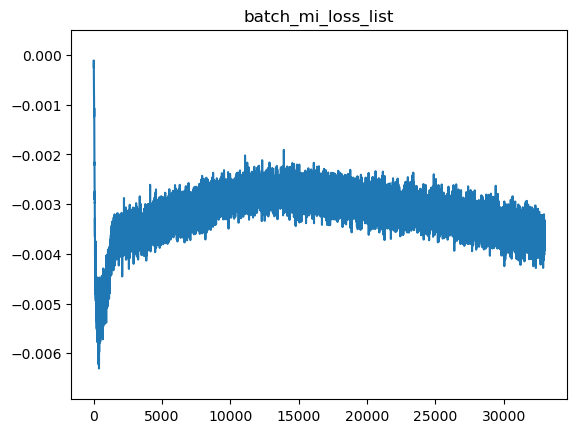

100%|█████████████████████████████████████████| 459/459 [02:23<00:00,  3.21it/s]

val sample:
********************
 ['Mrs', 'Banotti', 'will', 'give', 'you', 'an', 'answer', ',', 'but', 'if', 'the', 'regulations', 'have', 'already', 'been', 'drawn', 'up', ',', 'then', 'they', 'must', 'and', 'shall', 'be', 'applied', '<eos>'] 
->
 ['Mrs', 'Banotti', 'will', 'give', 'you', 'an', 'answer', ',', 'but', 'if', 'the', 'regulations', 'have', 'already', 'been', 'drawn', 'up', ',', 'then', 'they', 'must', 'and', 'shall', 'be', 'applied', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ['The', 'risk', 'of', 'fraud@@', 'ulent', 'use', 'of', 'confidential', 'information', 'increases', 'if', 'information', 'is', 'not', 'properly', 'dissem@@', 'inated', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->
 ['The', 'risk', 'of', 'vis@@', 'z-@@', 'use', 'of', 'confidential', 'information', 'colored', 'if', 'information', 'is', 'not', 'properly', 'porte@

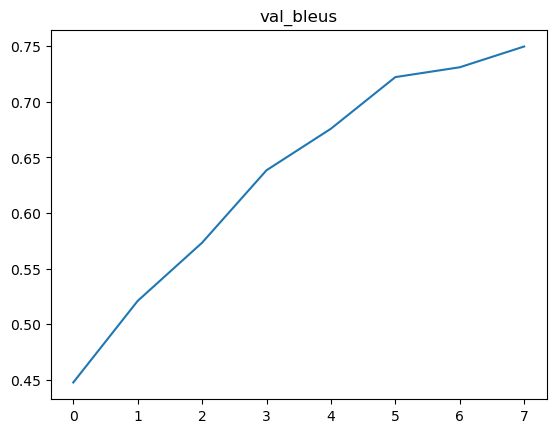

 20%|████████                                | 825/4125 [03:44<14:42,  3.74it/s]

now batch:825 in epoch 8


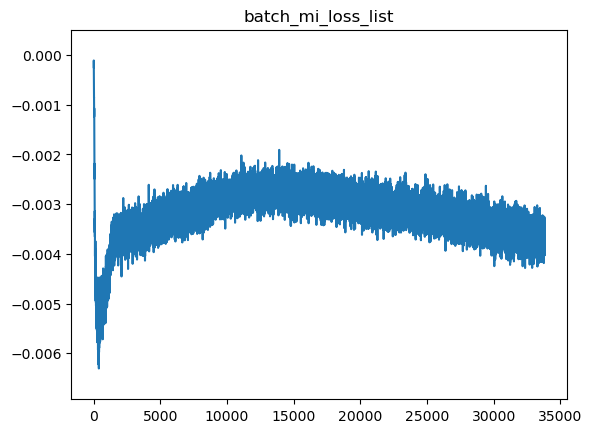

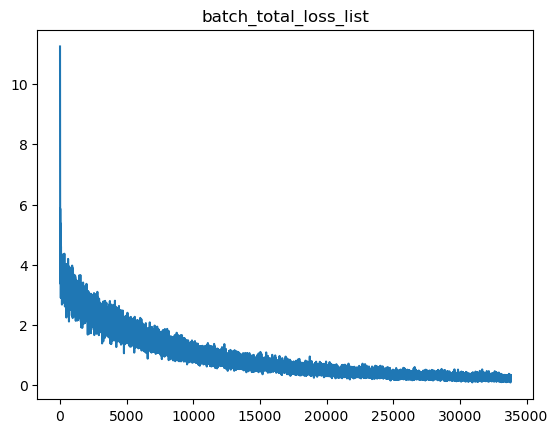

 40%|███████████████▌                       | 1651/4125 [07:30<11:12,  3.68it/s]

now batch:1651 in epoch 8


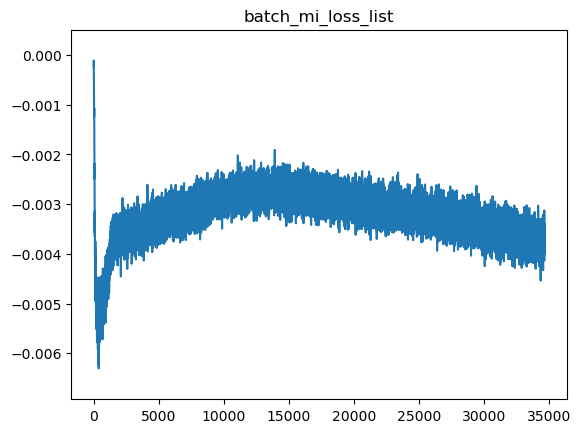

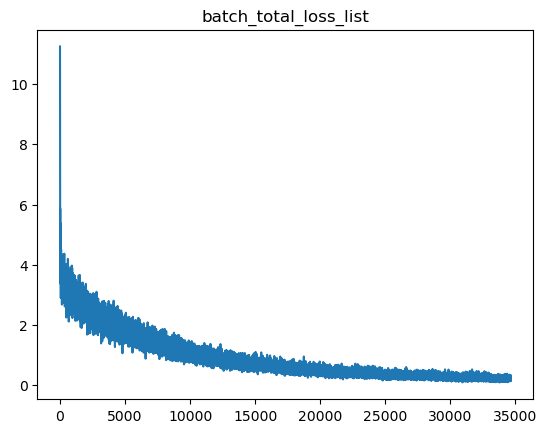

 60%|███████████████████████▍               | 2477/4125 [11:18<07:06,  3.87it/s]

now batch:2477 in epoch 8


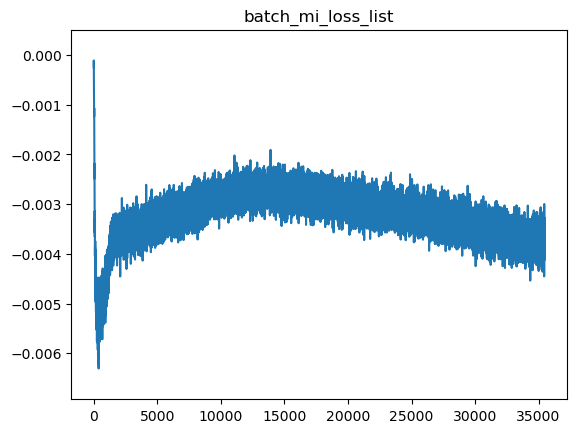

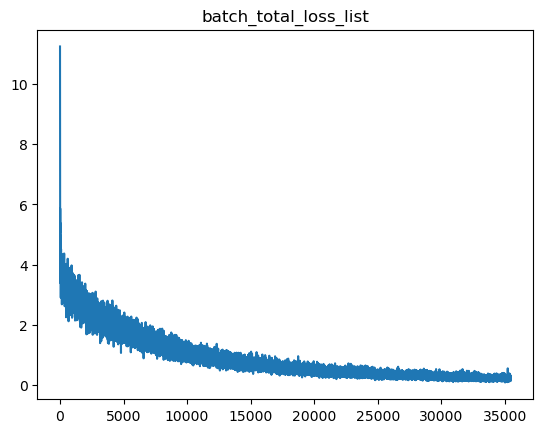

 80%|███████████████████████████████▏       | 3303/4125 [15:08<04:07,  3.32it/s]

now batch:3303 in epoch 8


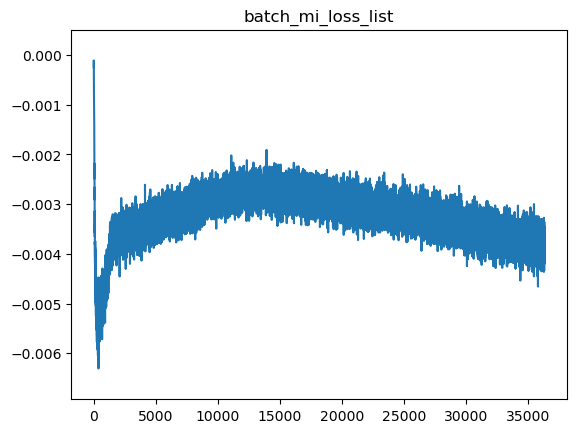

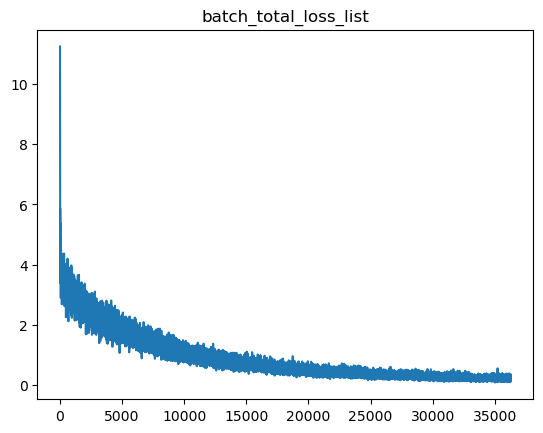

100%|███████████████████████████████████████| 4125/4125 [18:56<00:00,  3.63it/s]


============================== epoch: 8 loss: 883.8300553485751
train sample:
********************
 ['The', 'only', 'talk', 'is', 'of', 'how', 'best', 'to', 'manage', 'the', 'demographic', 'collapse', 'and', 'ageing', 'in', 'the', 'Member', 'States', ',', 'with', 'pension', 'funds', 'authorised', 'in', 'a', 'passing', 'nod', 'to', 'global', 'finance', '<eos>'] 
->
 ['The', 'only', 'talk', 'is', 'of', 'how', 'best', 'to', 'manage', 'the', 'sentiments', 'mergers', 'and', 'additives', 'in', 'the', 'Member', 'States', ',', 'with', 'pension', 'funds', 'authorised', 'in', 'a', 'direction', 'resulting', 'to', 'global', 'operators', '<eos>']
********************
 ['ATT@@', "'s", 'not', 'that', 'great', 'either', 'but', '6@@', '3%', 'dividend', 'payout', 'is', 'great', '(in', 'case', 'you', 'have', 'some', 'spare', 'money', 'lying', 'around', ':@@', 'p)', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->
 ['Violence', "'s", 'not', 'that', 'great', 'either', 'but', 'care@@', 'ce

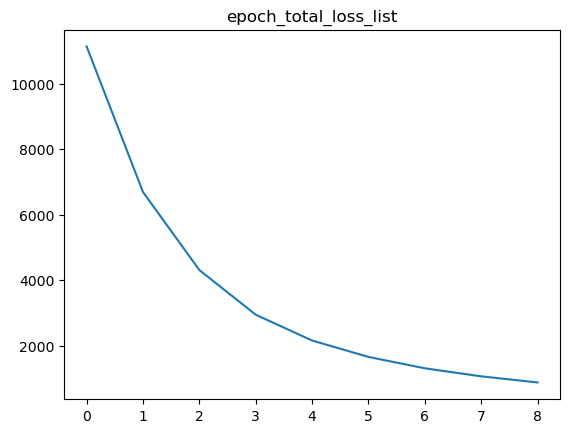

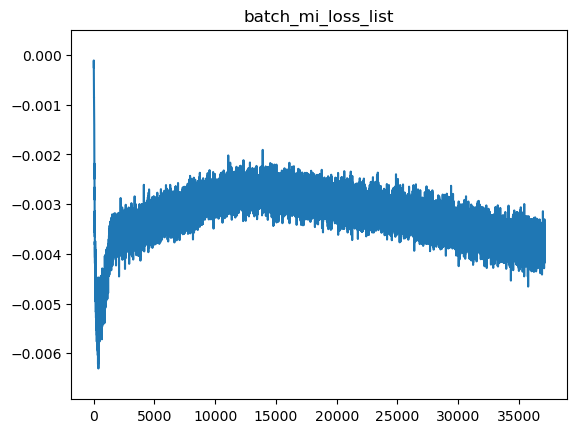

100%|█████████████████████████████████████████| 459/459 [02:30<00:00,  3.06it/s]

val sample:
********************
 ['In', 'that', 'connection', ',', 'I', 'would', 'thank', 'my', 'fellow', 'MEPs', 'here', 'in', 'Parliament', 'for', 'the', 'unity', 'and', 'pers@@', 'ever@@', 'ance', 'we', 'demonstrated', 'during', 'that', 'procedure', '<eos>'] 
->
 ['In', 'that', 'connection', ',', 'I', 'would', 'thank', 'my', 'fellow', 'MEPs', 'here', 'in', 'Parliament', 'for', 'the', 'unity', 'and', 'handic@@', 'lier', 'ance', 'we', 'demonstrated', 'during', 'that', 'procedure', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ['I', 'was', 'a', 'little', 'worried', 'about', 'her', 'being', 'picked', 'on', 'but', 'its', 'a', 'small', 'pack', 'and', 'they', 'seem', 'to', 'be', 'incredibly', 'kind', 'and', 'inclusive', '<eos>', '<pad>'] 
->
 ['I', 'was', 'a', 'little', 'worried', 'about', 'her', 'being', 'creeped', 'on', 'but', 'its', 'a', 'small', 'pack', 'and', 'they', 'seem', 'to', 'b

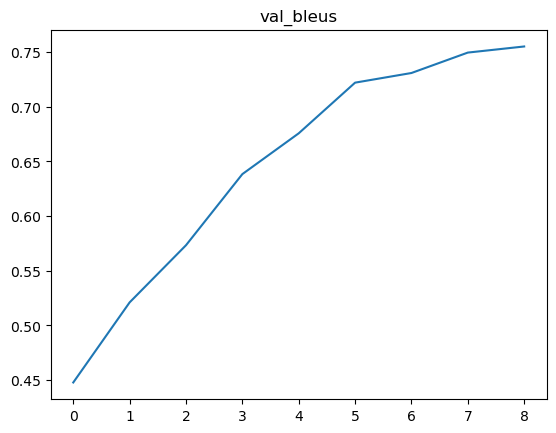

 20%|████████                                | 825/4125 [04:01<17:26,  3.15it/s]

now batch:825 in epoch 9


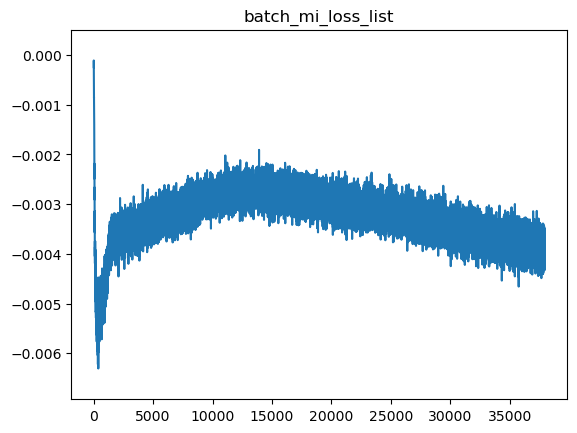

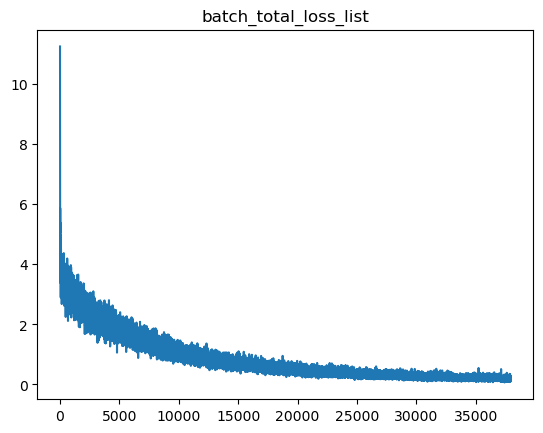

 40%|███████████████▌                       | 1651/4125 [08:04<11:18,  3.64it/s]

now batch:1651 in epoch 9


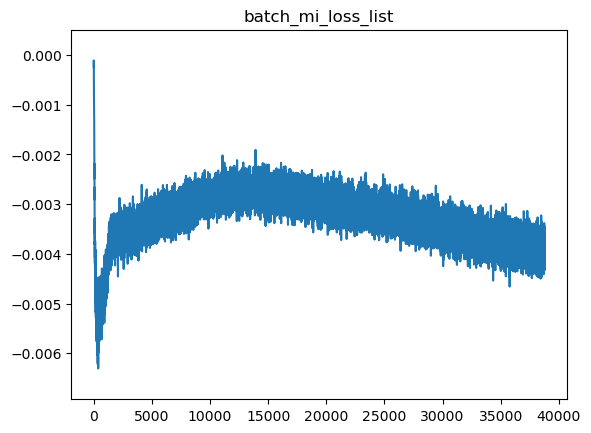

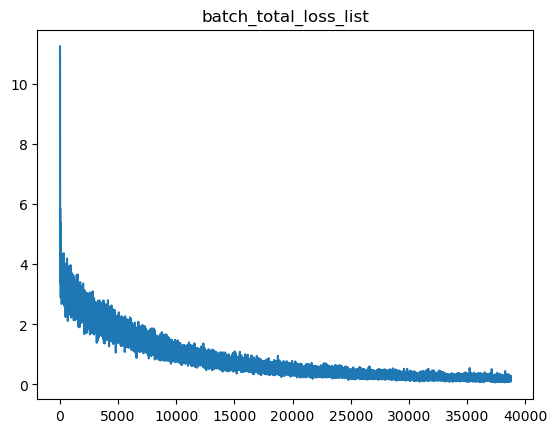

 60%|███████████████████████▍               | 2477/4125 [12:01<08:07,  3.38it/s]

now batch:2477 in epoch 9


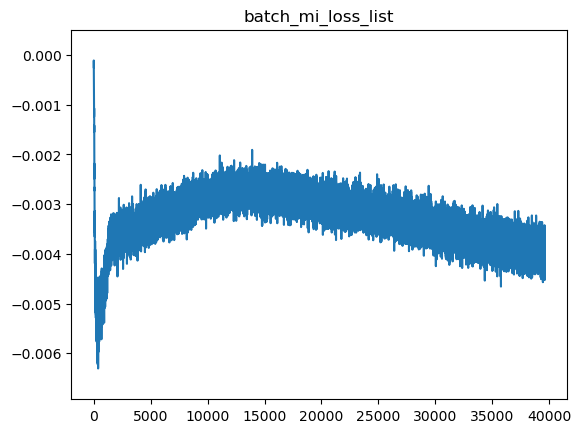

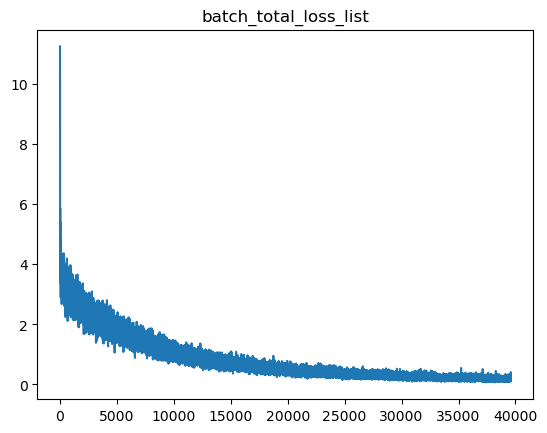

 80%|███████████████████████████████▏       | 3303/4125 [15:56<04:02,  3.39it/s]

now batch:3303 in epoch 9


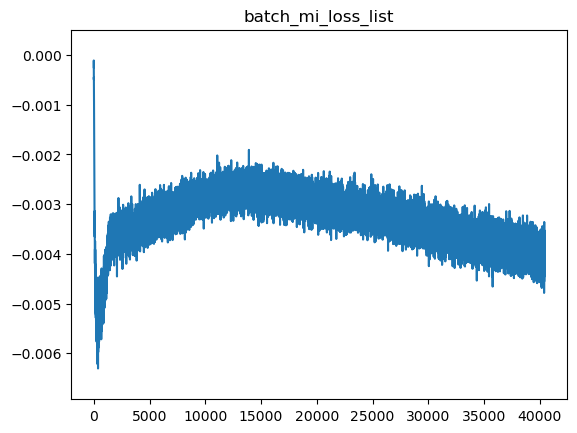

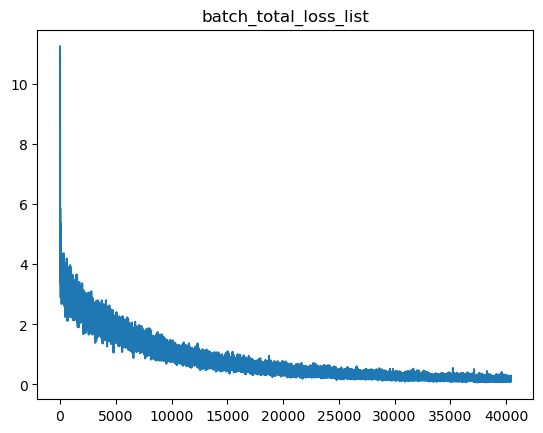

100%|███████████████████████████████████████| 4125/4125 [19:49<00:00,  3.47it/s]

============================== epoch: 9 loss: 737.1216406524181
train sample:
********************
 ['Every', 'territory', 'that', 'claims', 'to', 'be', 'independent', 'must', 'be', 'able', 'to', 'ensure', 'that', 'crime', 'and', 'terror', 'do', 'not', 'surge', 'across', 'its', 'borders', ',', 'threatening', 'its', 'neighbour', '<eos>'] 
->
 ['Every', 'guarantees', 'that', 'claims', 'to', 'be', 'independent', 'must', 'be', 'able', 'to', 'ensure', 'that', 'crime', 'and', 'auditing', 'do', 'not', 'entrust', 'across', 'its', 'borders', ',', 'Eritrea', 'its', 'assets', '<eos>']
********************
 ['I', 'would', 'like', 'to', 'know', ',', 'Mrs', 'Schreyer', ',', 'what', 'is', 'going', 'to', 'be', 'done', 'with', 'the', 'initial', 'proposal', 'for', 'revision', 'of', 'the', 'financial', 'perspective', '<eos>', '<pad>'] 
->
 ['I', 'would', 'like', 'to', 'know', ',', 'Mrs', 'Schreyer', ',', 'what', 'is', 'going', 'to', 'be', 'done', 'with', 'the', 'initial', 'proposal', 'for', 'thousands', 

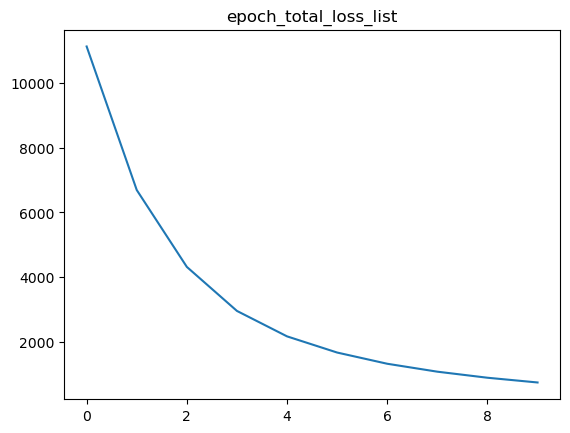

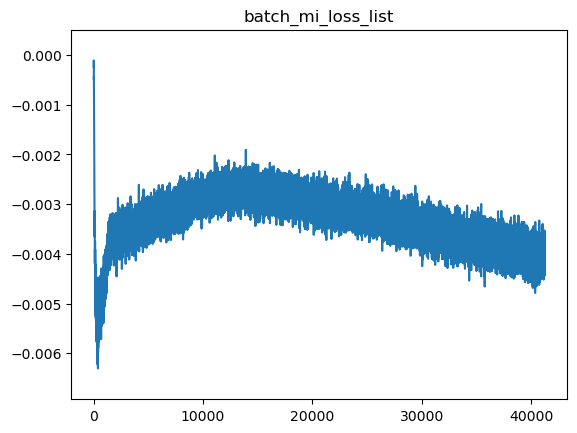

100%|█████████████████████████████████████████| 459/459 [02:27<00:00,  3.12it/s]

val sample:
********************
 ['The', 'smallest', 'breakdown', 'in', 'the', 'cool@@', 'ing', 'system', 'of', 'a', 'nuclear', 're@@', 'actor', 'can', 'never', 'be', 'considered', 'as', 'insignificant', ',', 'as', 'it', 'contains', 'heavy', 'water', 'with', 'radioactive', 'iso@@', 'top@@', 'es', '<eos>'] 
->
 ['The', 'smallest', 'Forum', 'in', 'the', 'Agriculture', 'ing', 'system', 'of', 'a', 'nuclear', 're@@', 'actor', 'can', 'never', 'be', 'considered', 'as', 'insignificant', ',', 'as', 'it', 'contains', 'heavy', 'water', 'with', 'radioactive', 'speci@@', 'emb@@', 'es', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ['&#x200B;', 'Also', 'most', 'times', 'guys', 'will', 'be', 'into', 'you', 'because', 'of', 'it', ',', 'it', 'may', 'not', 'work', 'out', 'in', 'the', 'end', 'but', 'the', 'interest', 'will', 'probably', 'be', 'there', '<eos>', '<pad>', '<pad>'] 
->
 ['&#x200B;', 'Also', 'most', 'times', 'guys', 'will', 'be', 'into

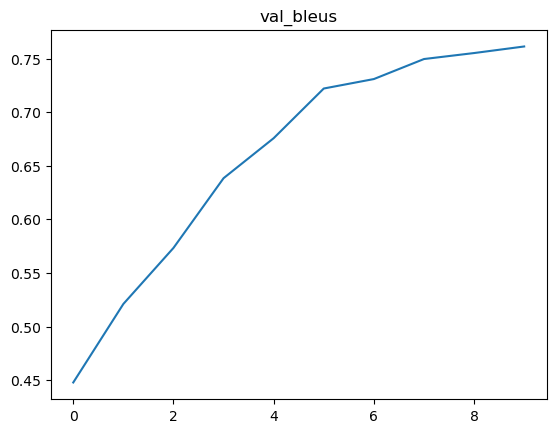

 20%|████████                                | 825/4125 [03:56<15:56,  3.45it/s]

now batch:825 in epoch 10


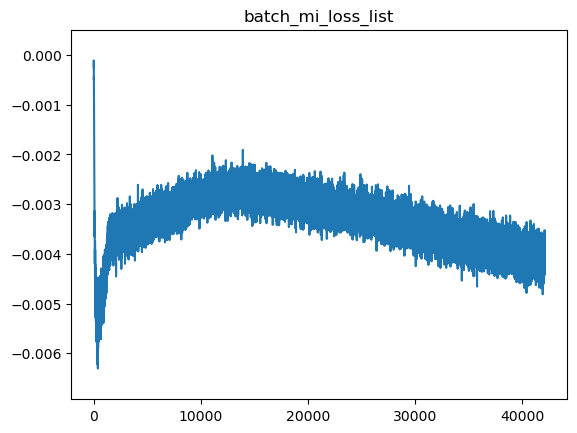

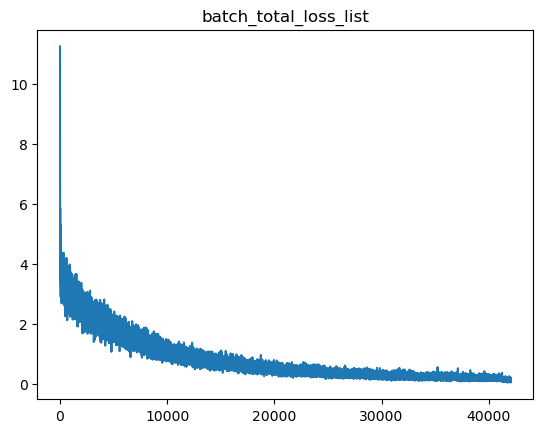

 40%|███████████████▌                       | 1651/4125 [07:51<12:17,  3.35it/s]

now batch:1651 in epoch 10


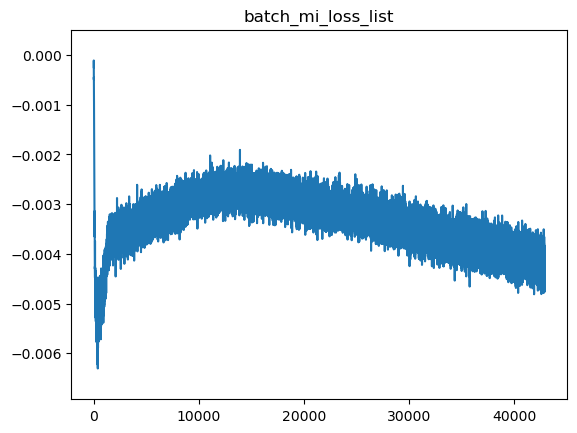

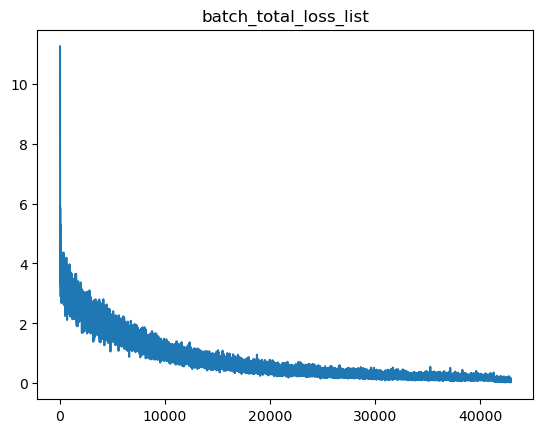

 60%|███████████████████████▍               | 2477/4125 [11:47<07:53,  3.48it/s]

now batch:2477 in epoch 10


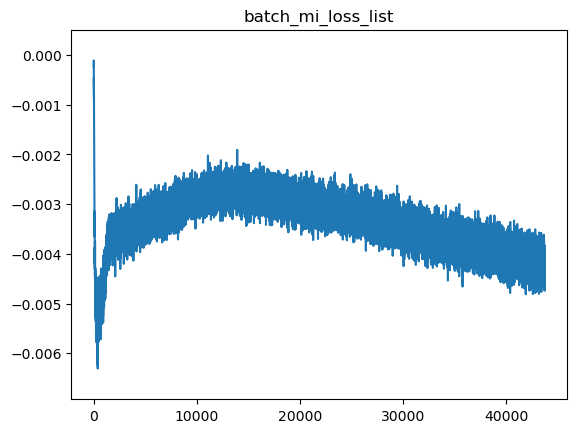

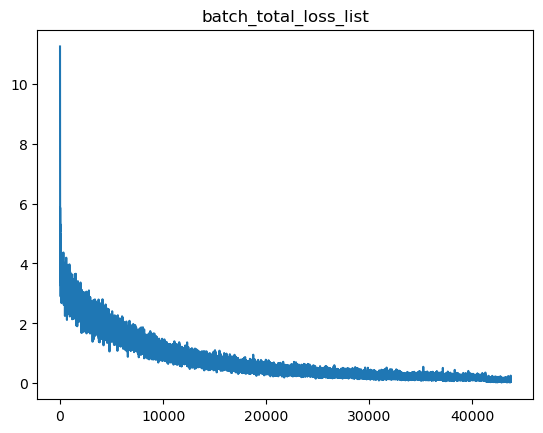

 80%|███████████████████████████████▏       | 3303/4125 [15:43<04:24,  3.11it/s]

now batch:3303 in epoch 10


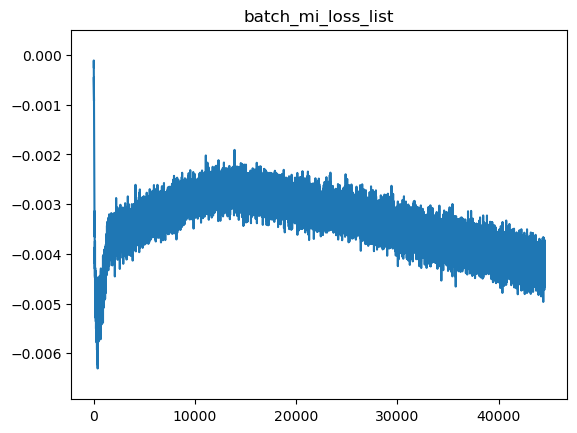

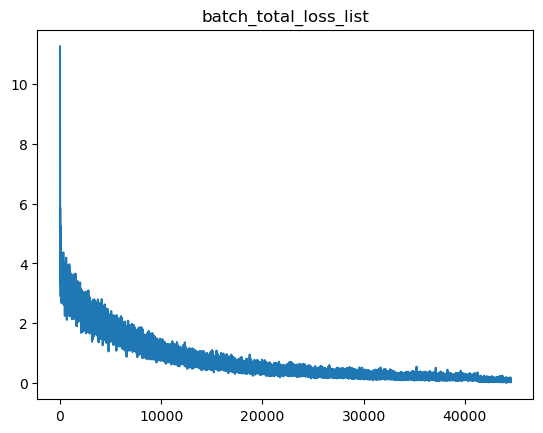

100%|███████████████████████████████████████| 4125/4125 [19:34<00:00,  3.51it/s]

============================== epoch: 10 loss: 403.1331935301423
train sample:
********************
 ['Of', 'course', ',', 'the', 'new', 'high-speed', 'train', 'infrastructures', 'offer', 'a', 'prime', 'area', 'for', 'the', 'introduction', 'of', 'interoperability', ',', 'since', 'they', 'are', 'new', 'or', 'recent', 'networks', 'devoted', 'to', 'very', 'similar', 'technology', '<eos>'] 
->
 ['Of', 'course', ',', 'the', 'new', 'high-speed', 'train', 'infrastructures', 'offer', 'a', 'moratorium', 'area', 'for', 'the', 'introduction', 'of', 'interoperability', ',', 'since', 'they', 'are', 'new', 'or', 'recent', 'networks', 'devoted', 'to', 'very', 'similar', 'technology', '<eos>']
********************
 ['We', 'all', 'know', 'that', 'European', 'participation', 'plays', 'a', 'substantial', 'role', 'in', 'supporting', 'developing', 'countries', 'and', 'that', 'we', 'provide', 'more', 'money', 'than', 'any', 'other', 'donor', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->

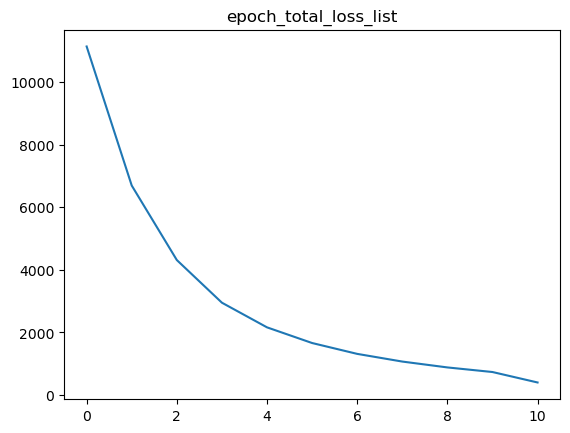

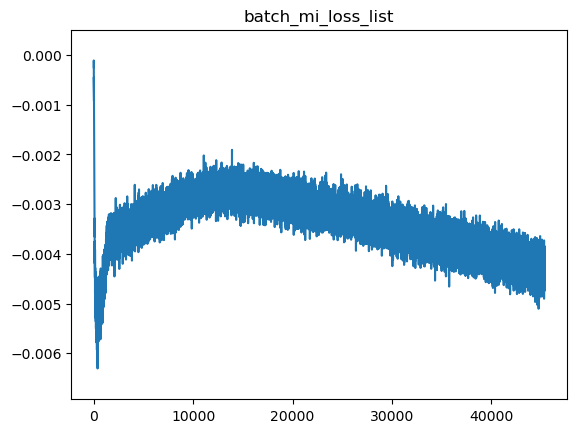

100%|█████████████████████████████████████████| 459/459 [02:24<00:00,  3.18it/s]

val sample:
********************
 ['Mr', 'President', ',', 'at', 'the', 'outset', 'I', 'want', 'to', 'take', 'the', 'opportunity', 'of', 'congratulating', 'Mr', 'G@@', 'as@@', 'òliba', 'i', 'Bö@@', 'hm', 'on', 'the', 'preparation', 'and', 'presentation', 'of', 'his', 'report', '<eos>'] 
->
 ['Mr', 'President', ',', 'at', 'the', 'outset', 'I', 'want', 'to', 'take', 'the', 'opportunity', 'of', 'congratulating', 'Mr', 'G@@', 'as@@', 'òliba', 'i', 'Bö@@', 'on', 'the', 'preparation', 'and', 'preparation', 'and', 'presentation', 'his', 'report', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ['You', 'need', 'to', 'actively', 'resist', 'that', 'compulsion', 'to', 'accumulate', 'emotional', 'baggage', 'based', 'on', 'the', 'percep@@', 'tions', 'of', 'others', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->
 ['You', 'need', 'to', 'actively', 'resist', 'that', 'compuls

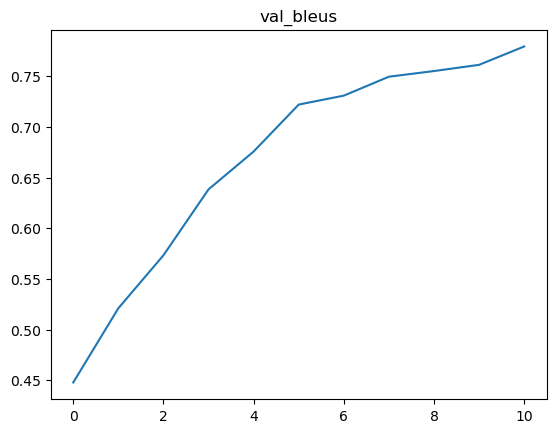

 20%|████████                                | 825/4125 [03:55<18:15,  3.01it/s]

now batch:825 in epoch 11


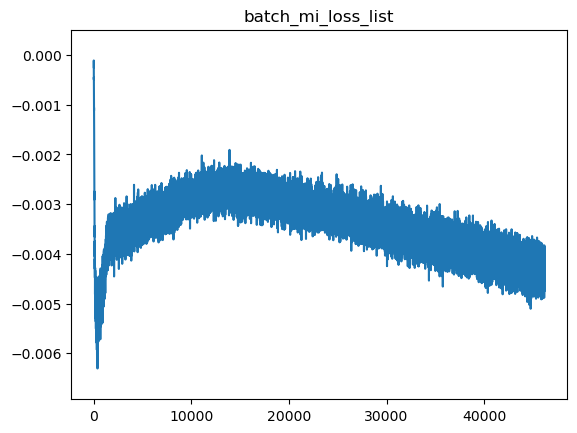

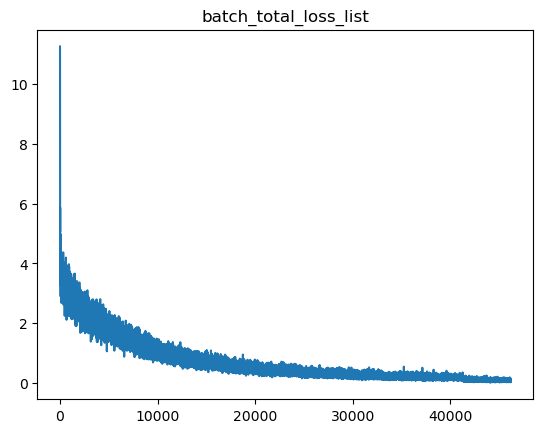

 40%|███████████████▌                       | 1651/4125 [07:50<11:38,  3.54it/s]

now batch:1651 in epoch 11


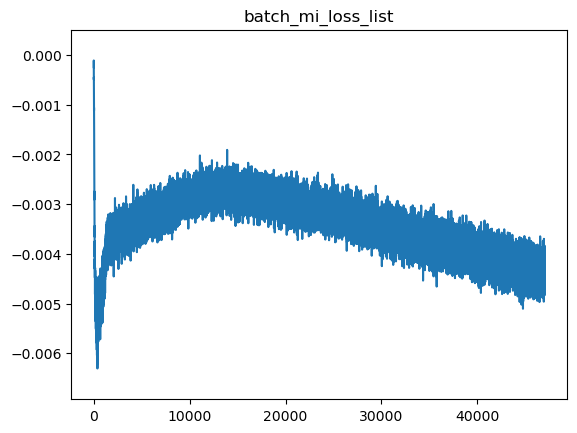

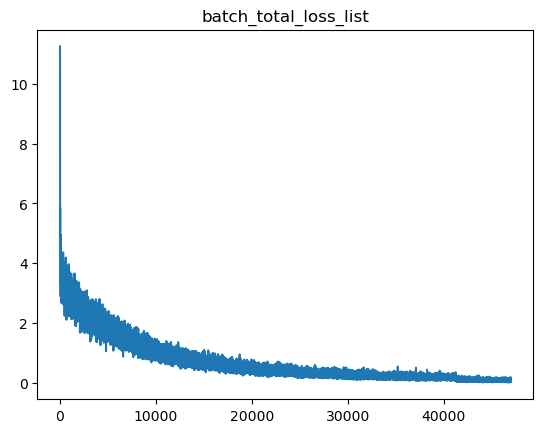

 60%|███████████████████████▍               | 2477/4125 [11:40<07:44,  3.55it/s]

now batch:2477 in epoch 11


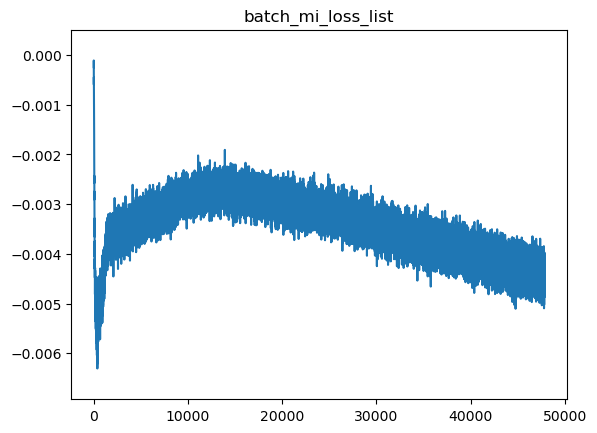

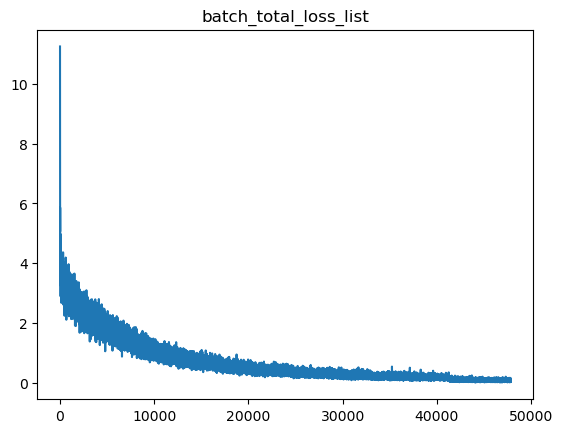

 80%|███████████████████████████████▏       | 3303/4125 [15:32<03:50,  3.56it/s]

now batch:3303 in epoch 11


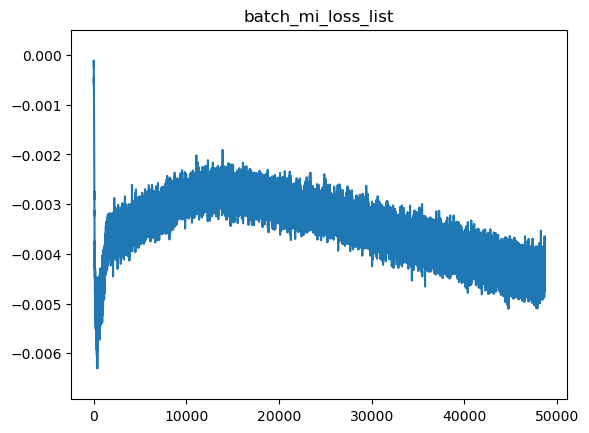

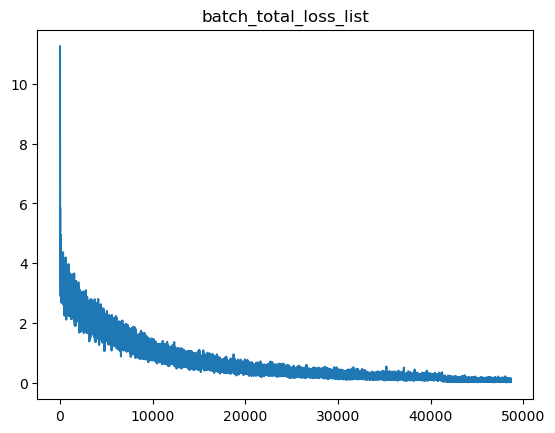

100%|███████████████████████████████████████| 4125/4125 [19:25<00:00,  3.54it/s]

============================== epoch: 11 loss: 323.6396071407944
train sample:
********************
 ['The', 'Commission', 'is', 'endeavouring', 'to', 'nip', 'breaches', 'of', 'Community', 'law', 'in', 'the', 'bud', 'and', 'is', 'therefore', 'constantly', 'updating', 'its', 'procedures', 'pertaining', 'to', 'the', 'monitoring', 'of', 'the', 'application', 'of', 'Community', 'law', '<eos>'] 
->
 ['The', 'Commission', 'is', 'endeavouring', 'to', 'equip', 'breaches', 'of', 'Community', 'law', 'in', 'the', 'Bible', 'and', 'is', 'therefore', 'gro@@', 'updating', 'its', 'procedures', 'pertaining', 'to', 'the', 'bases', 'of', 'the', 'application', 'of', 'Community', 'law', '<eos>']
********************
 ['Sounds', 'pretty', 'similar', 'to', 'me', ',', 'expect', "I'm", 'kind', 'of', 'an', 'anxious', 'wreck', 'at', 'times', ',', 'so', 'I', 'still', 'delete', 'comments', 'that', 'get', 'too', 'downvoted', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->
 ['Sounds', 'pretty', 'similar', 

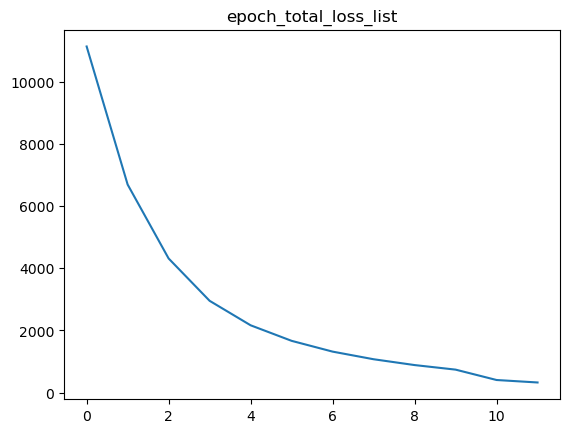

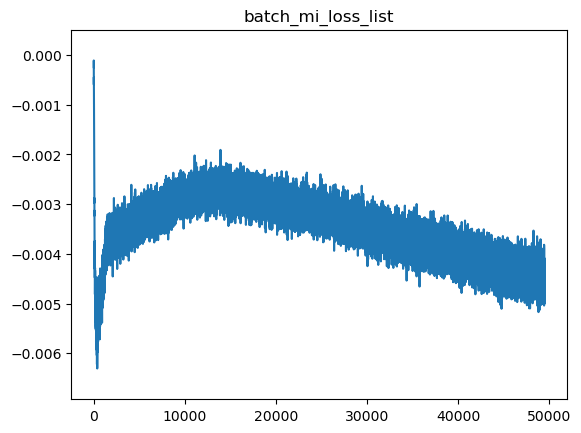

100%|█████████████████████████████████████████| 459/459 [02:25<00:00,  3.15it/s]

val sample:
********************
 ['To', 'put', 'it', 'in', 'another', 'way', ',', 'the', 'European', 'Parliament', 'does', 'not', 'wish', 'to', 'be', 'part', 'of', 'the', 'problem', ',', 'it', 'wishes', 'to', 'be', 'part', 'of', 'the', 'solution', '<eos>'] 
->
 ['To', 'put', 'it', 'in', 'another', 'way', ',', 'the', 'European', 'Parliament', 'does', 'not', 'wish', 'to', 'be', 'part', 'of', 'the', 'problem', ',', 'it', 'wishes', 'to', 'be', 'part', 'of', 'the', 'solution', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ['It', 'can', 'solve', 'al@@', 'ge@@', 'bra@@', 'ic', 'equations', 'and', 'if', 'they', 'let', 'you', 'use', 'it', 'on', 'tests', ',', "you'd", 'get', 'a', 'huge', 'leg', 'up', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->
 ['It', 'can', 'solve', 'al@@', 'ge@@', 'bra@@', 'ic', 'equations', 'and', 'if', 'they', 'let', 'you', 'use', 'it', 'on', 'tests', ',', 'overall', 'get', 'a', 'huge', 'leg', '

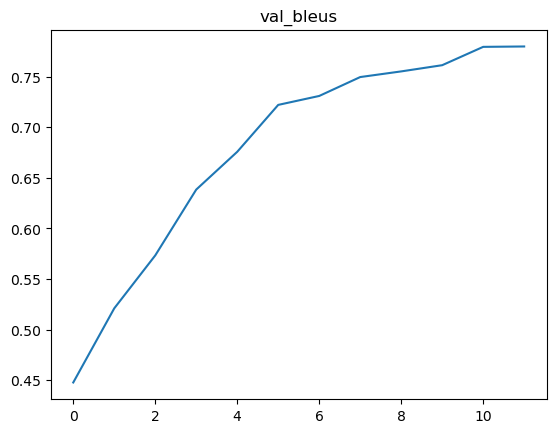

 20%|████████                                | 825/4125 [04:01<15:19,  3.59it/s]

now batch:825 in epoch 12


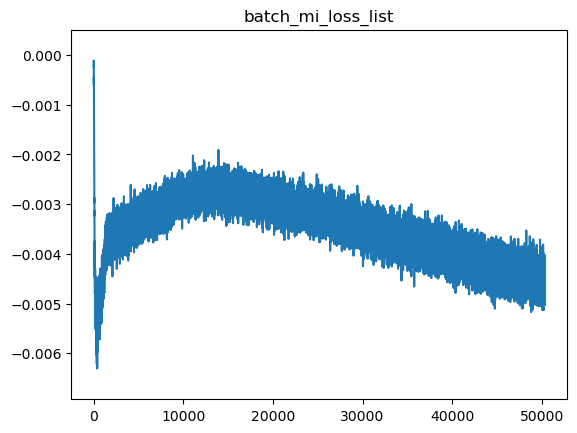

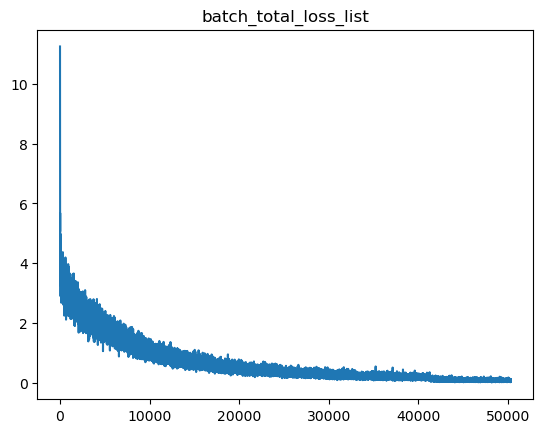

 40%|███████████████▌                       | 1651/4125 [08:06<12:02,  3.42it/s]

now batch:1651 in epoch 12


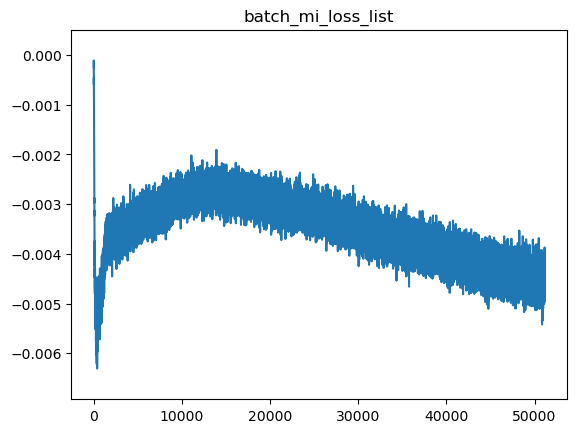

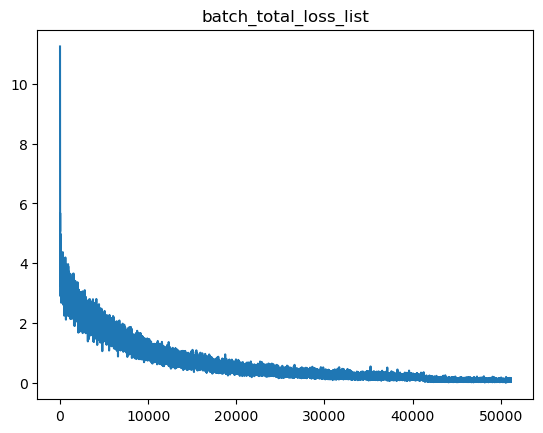

 60%|███████████████████████▍               | 2477/4125 [12:05<08:04,  3.40it/s]

now batch:2477 in epoch 12


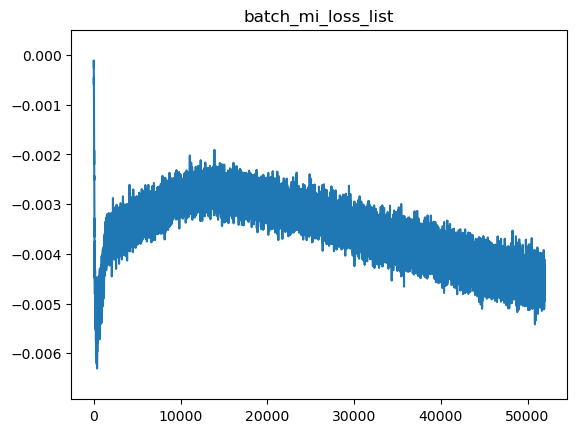

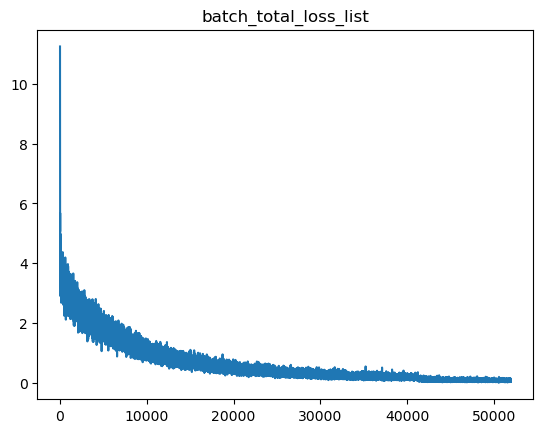

 80%|███████████████████████████████▏       | 3303/4125 [16:07<03:52,  3.54it/s]

now batch:3303 in epoch 12


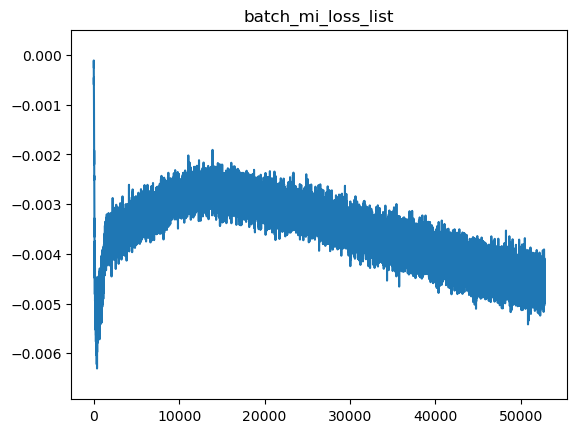

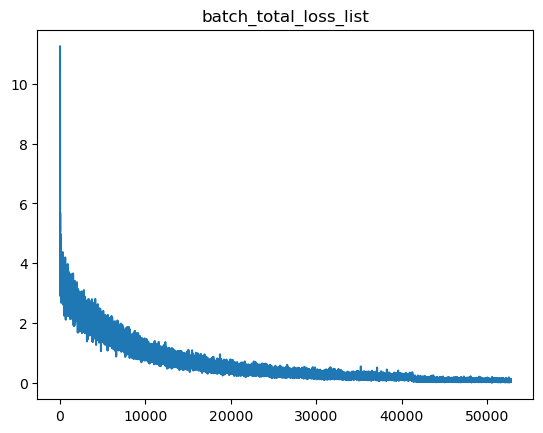

100%|███████████████████████████████████████| 4125/4125 [20:03<00:00,  3.43it/s]

============================== epoch: 12 loss: 287.5584623236209
train sample:
********************
 ['The', 'commitments', 'expressed', 'in', 'the', 'Millennium', 'Declaration', ',', 'which', 'complement', 'the', 'World', 'Summit', ',', 'should', 'also', 'be', 'taken', 'fully', 'into', 'account', '<eos>'] 
->
 ['The', 'review', 'expressed', 'in', 'the', 'Millennium', 'Declaration', ',', 'which', 'complement', 'the', 'World', 'Summit', ',', 'should', 'also', 'be', 'taken', 'voting', 'into', 'account', '<eos>']
********************
 ['>>*', "Don't", 'make', 'a', 'thread', 'if', 'you', 'are', 'going', 'to', 'be', 'away', 'and', 'not', 'able', 'to', 'participate', 'in', 'the', 'thread', '<eos>', '<pad>'] 
->
 ['>>*', "Don't", 'make', 'a', 'thread', 'if', 'you', 'are', 'going', 'to', 'be', 'away', 'and', 'not', 'able', 'to', 'participate', 'in', 'the', 'thread', '<eos>', '<pad>']
********************
 ['I', 'also', 'never', 'wash', 'my', 'face', 'aside', 'from', 'letting', 'water', 'hit', 

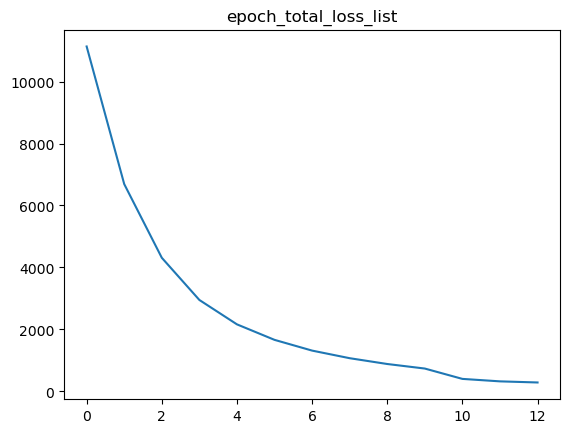

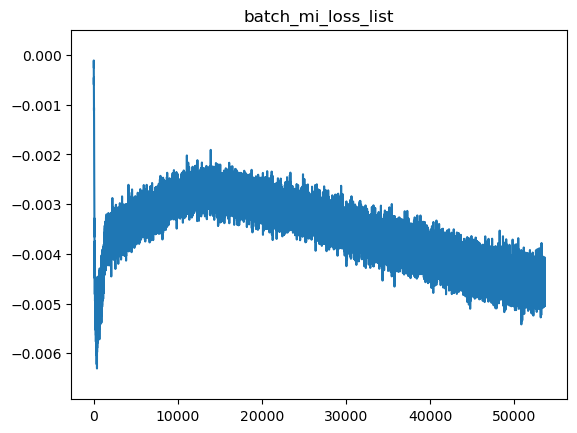

100%|█████████████████████████████████████████| 459/459 [02:30<00:00,  3.06it/s]

val sample:
********************
 ['THEN', 'Kid', 'A', 'came', 'out', 'and', 'it', 'was', 'totally', 'different', ',', 'very', 'experimental', 'elements', 'and', 'the', 'albums', 'afterwards', 'continued', 'on', 'a', 'similar', 'experimental', 'vein', '<eos>'] 
->
 ['THEN', 'Kid', 'A', 'came', 'out', 'and', 'it', 'was', 'totally', 'different', ',', 'very', 'experimental', 'elements', 'and', 'the', 'albums', 'afterwards', 'continued', 'on', 'a', 'similar', 'experimental', 'vein', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ['I', 'depends', 'on', 'which', 'country', 'you', 'are', 'from', ',', 'if', 'you', 'got', 'blood', 'in', 'my', 'country', 'you', 'are', 'never', 'allowed', 'to', 'donate', 'again', '<eos>', '<pad>'] 
->
 ['I', 'depends', 'on', 'which', 'country', 'you', 'are', 'from', ',', 'if', 'you', 'got', 'blood', 'in', 'my', 'country', 'you', 'are', 'never', 'allowed',

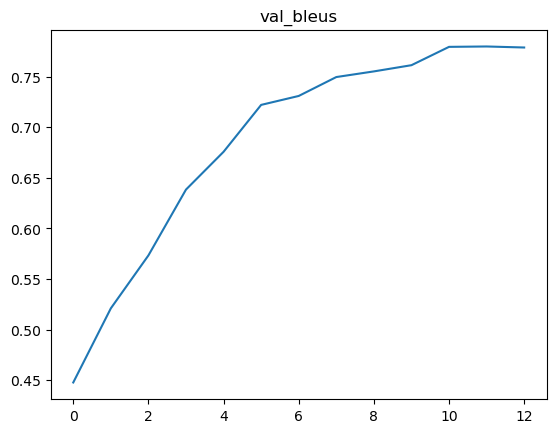

 20%|████████                                | 825/4125 [04:00<16:46,  3.28it/s]

now batch:825 in epoch 13


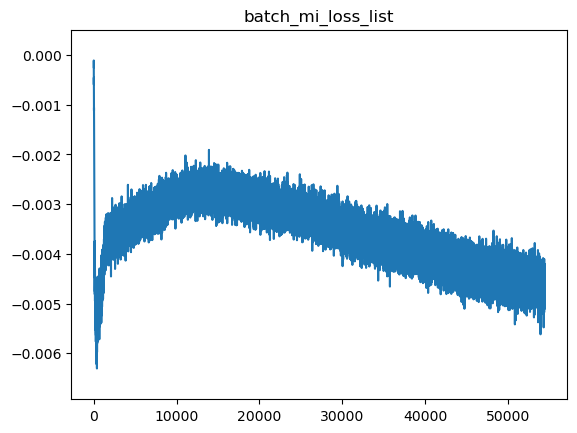

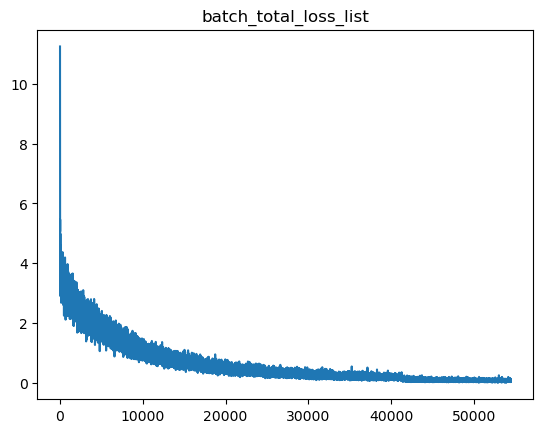

 40%|███████████████▌                       | 1651/4125 [08:01<12:30,  3.29it/s]

now batch:1651 in epoch 13


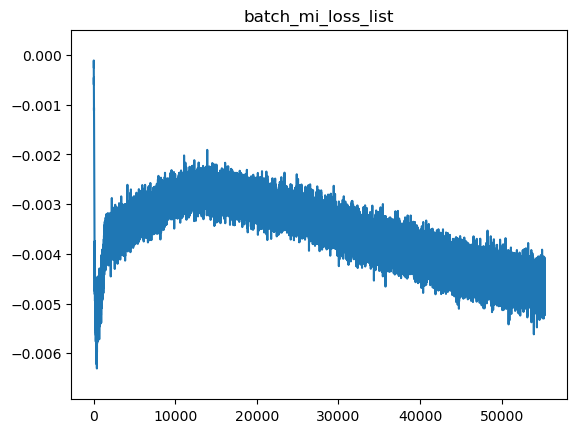

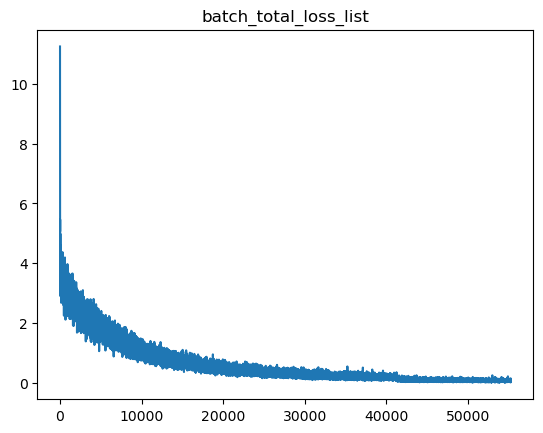

 60%|███████████████████████▍               | 2477/4125 [11:59<08:12,  3.35it/s]

now batch:2477 in epoch 13


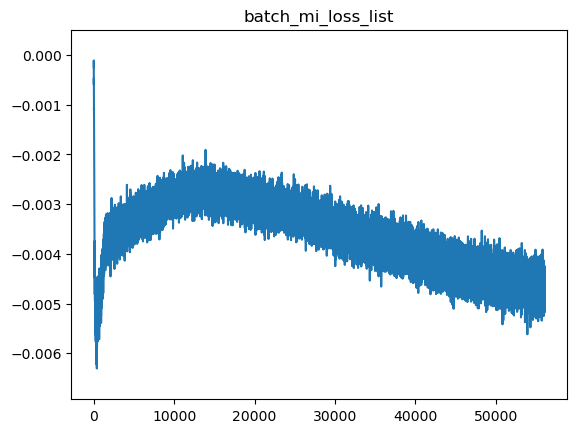

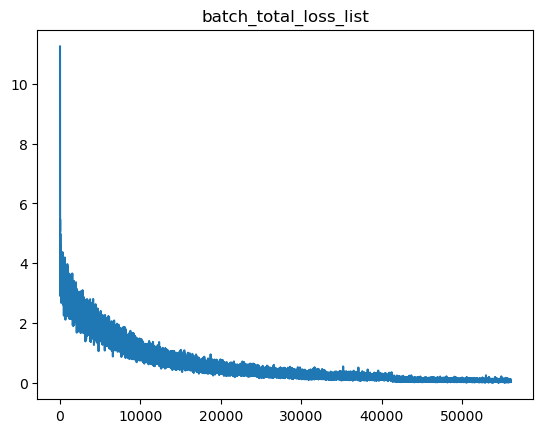

 80%|███████████████████████████████▏       | 3303/4125 [15:52<03:56,  3.47it/s]

now batch:3303 in epoch 13


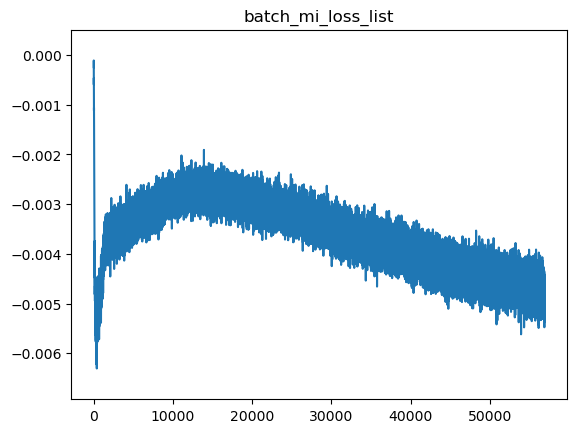

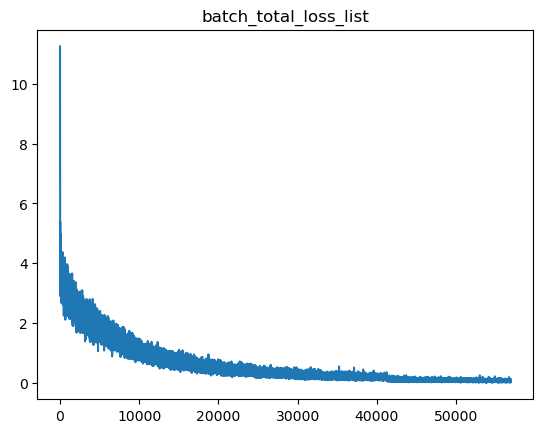

100%|███████████████████████████████████████| 4125/4125 [19:51<00:00,  3.46it/s]

============================== epoch: 13 loss: 262.18659720011055
train sample:
********************
 ['Its', 'to', 'see', 'if', 'people', 'die', 'less', 'if', 'hospitals', 'are', 'reimbursed', 'in', 'a', 'different', 'way', 'basically', ':p', 'But', 'the', 'outcome', 'is', 'basically', 'that', 'the', 'exact', 'effect', 'is', 'still', 'unclear', '<eos>'] 
->
 ['Its', 'to', 'see', 'if', 'people', 'die', 'less', 'if', 'hospitals', 'are', 'reimbursed', 'in', 'a', 'different', 'way', 'basically', ':p', ',', 'the', 'outcome', 'is', 'basically', 'that', 'the', 'exact', 'effect', 'is', 'still', 'unclear', '<eos>']
********************
 ['While', 'the', 'reform', 'strategy', 'White', 'Paper', 'will', 'clearly', 'outline', 'our', 'ideas', 'on', 'these', 'and', 'other', 'points', ',', 'detail', 'and', 'precision', 'are', 'obviously', 'essential', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->
 ['While', 'the', 'reform', 'strategy', 'White', 'Paper', 'will', 'clearly', 'outlin

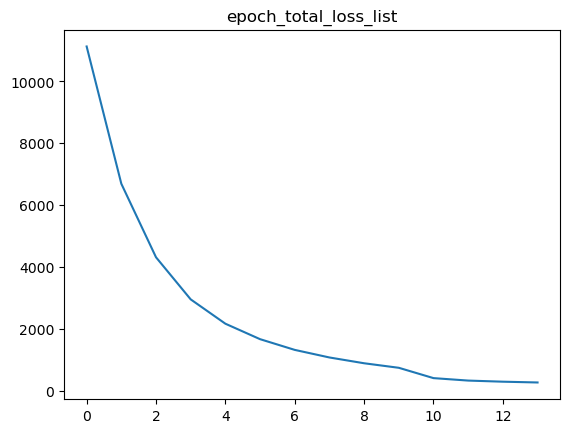

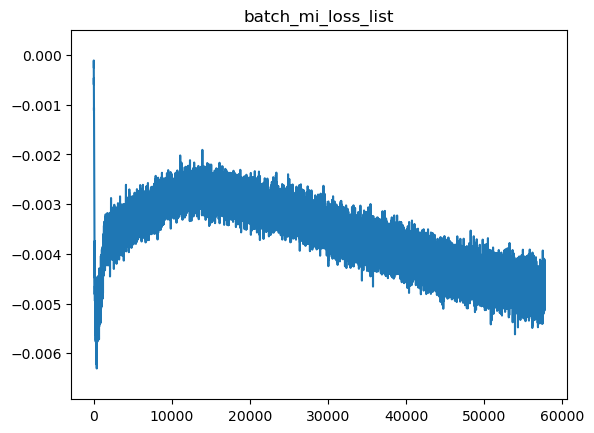

100%|█████████████████████████████████████████| 459/459 [02:23<00:00,  3.19it/s]

val sample:
********************
 ['Mr', 'President', ',', 'it', 'is', 'clear', 'on', 'reading', 'the', 'Seville', 'conclusions', 'on', 'the', 'reform', 'of', 'the', 'Council', 'that', 'Parliament', "'s", 'recommendations', 'have', 'only', 'been', 'followed', 'partially', '<eos>'] 
->
 ['Mr', 'President', ',', 'it', 'is', 'clear', 'on', 'reading', 'the', 'Seville', 'conclusions', 'on', 'the', 'reform', 'of', 'the', 'Council', 'that', 'Parliament', "'s", 'recommendations', 'have', 'only', 'been', 'followed', 'al', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ['Most', 'of', 'the', 'time', 'I', 'dont', 'even', 'realize', 'Im', 'doing', 'it', 'until', 'after@@', 'ward@@', 's@@', '(@@', 'weird', ',', 'I', 'know)', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->
 ['Most', 'of', 'the', 'time', 'I', 'dont', 'even', 'realize', 'Im', 'doing', 'it', 'until', 'after@@', 'ward@@', 's@@',

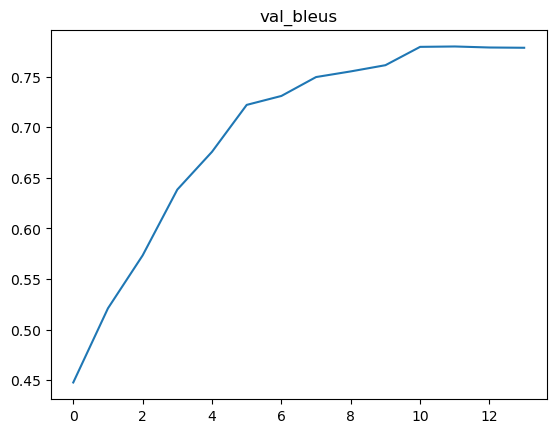

 20%|████████                                | 825/4125 [03:55<15:37,  3.52it/s]

now batch:825 in epoch 14


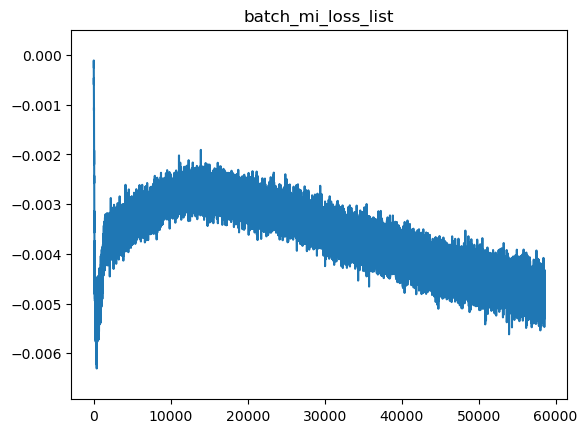

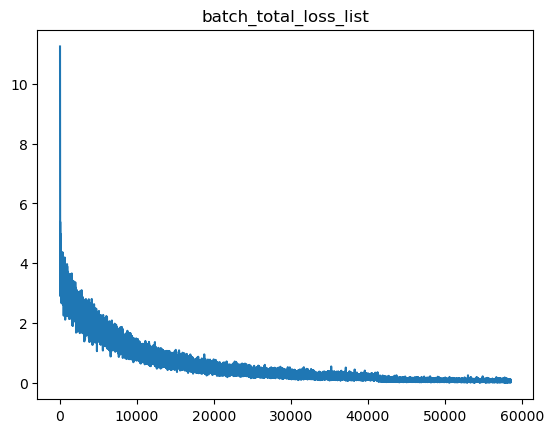

 40%|███████████████▌                       | 1651/4125 [07:46<10:45,  3.83it/s]

now batch:1651 in epoch 14


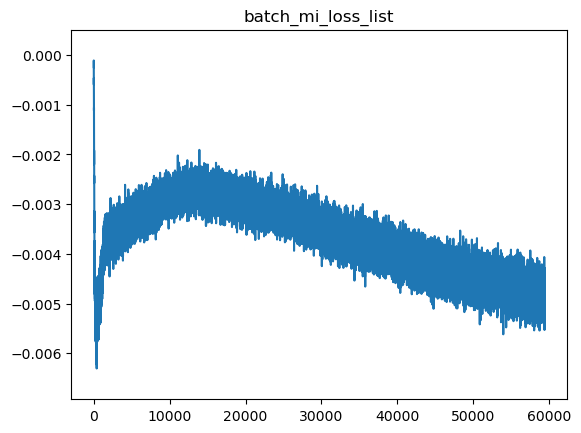

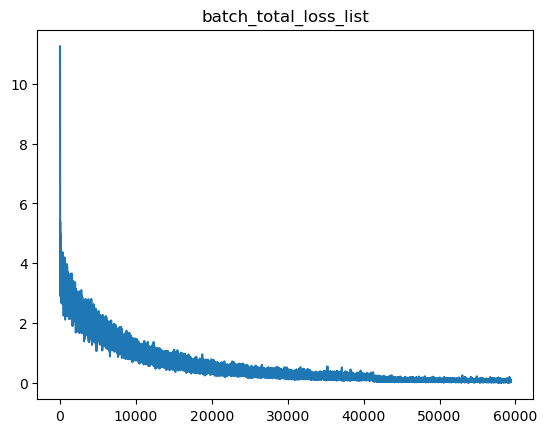

 60%|███████████████████████▍               | 2477/4125 [11:36<07:23,  3.72it/s]

now batch:2477 in epoch 14


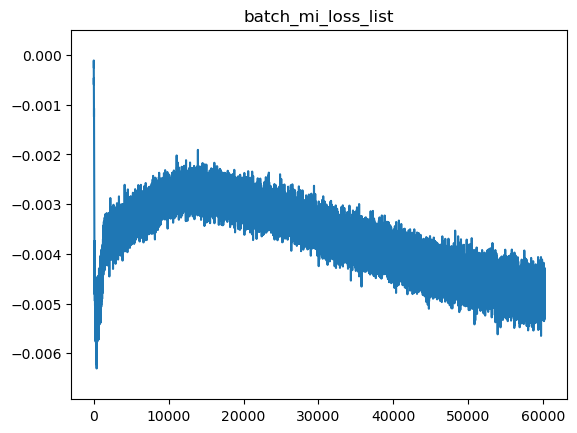

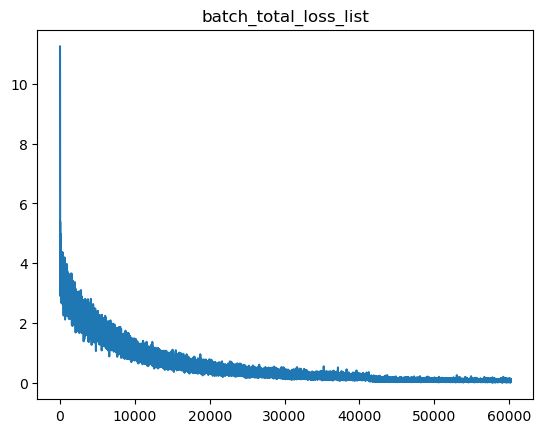

 80%|███████████████████████████████▏       | 3303/4125 [15:31<03:46,  3.63it/s]

now batch:3303 in epoch 14


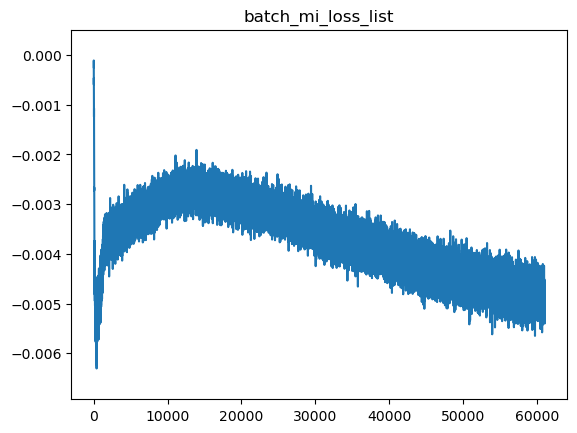

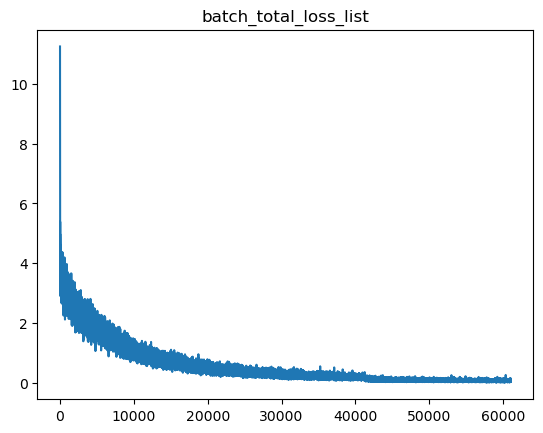

100%|███████████████████████████████████████| 4125/4125 [19:22<00:00,  3.55it/s]

============================== epoch: 14 loss: 239.64580131322145
train sample:
********************
 ['This', 'would', 'serve', 'to', 'lessen', 'the', 'yearly', 'conflict', 'that', 'has', 'tainted', 'the', 'preparation', 'of', 'the', 'EU', 'budget', 'in', 'the', 'last', 'couple', 'of', 'years', '<eos>'] 
->
 ['This', 'would', 'serve', 'to', 'lessen', 'the', 'subsequent', 'conflict', 'that', 'has', 'transformed', 'the', 'preparation', 'of', 'the', 'EU', 'budget', 'in', 'the', 'last', 'couple', 'of', 'years', '<eos>']
********************
 ['Th@@', 'u@@', 'g', 'Notes', 'is', 'my', 'go-to', 'whenever', 'I', "don't", 'read', 'a', 'book', 'for', 'class', 'but', 'have', 'a', 'test', 'on', 'it', '<eos>', '<pad>', '<pad>'] 
->
 ['Th@@', 'u@@', 'g', 'Notes', 'is', 'my', 'grandpa', 'whenever', 'I', "don't", 'read', 'a', 'book', 'for', 'class', 'but', 'have', 'a', 'test', 'on', 'it', '<eos>', '<pad>', '<pad>']
********************
 ['I', 'can', 'see', 'whatever', 'panel', ',', 'shop', 'as', 'lon

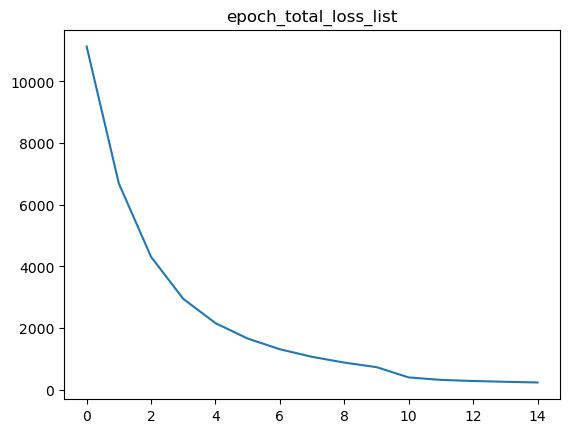

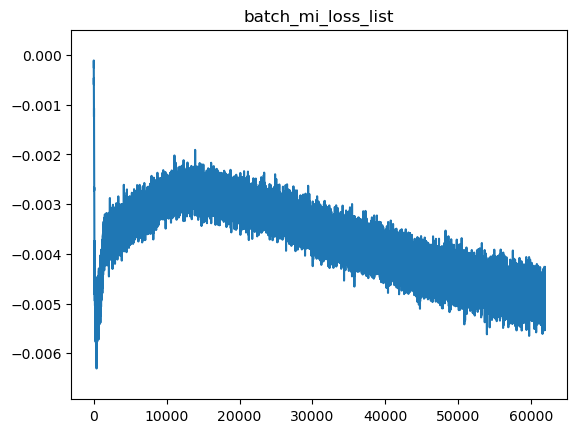

100%|█████████████████████████████████████████| 459/459 [02:23<00:00,  3.20it/s]

val sample:
********************
 ['My', 'handwriting', 'sucks', 'cause', 'I', "haven't", 'really', 'handwritten', 'anything', 'since', 'I', 'was', 'like', '10', '<eos>'] 
->
 ['My', 'handwriting', 'sucks', 'cause', 'I', "haven't", 'really', 'handwritten', 'anything', 'since', 'I', 'was', 'like', '10', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ['Thank', 'you', 'very', 'much', 'for', 'all', 'the', 'dossi@@', 'ers', 'you', 'have', 'addressed', 'this', 'week', '<eos>'] 
->
 ['Thank', 'you', 'very', 'much', 'for', 'all', 'the', 'wagon', 'ers', 'you', 'have', 'addressed', 'this', 'week', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'

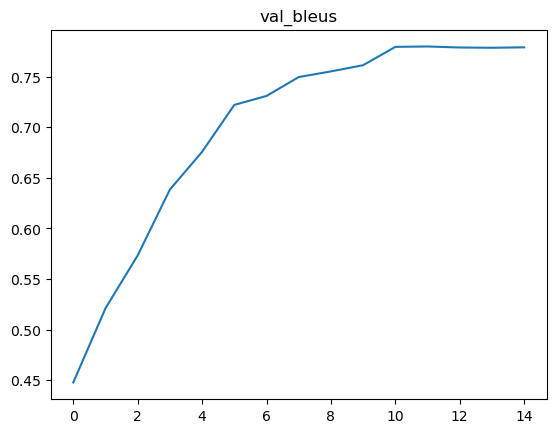

 20%|████████                                | 825/4125 [03:52<14:39,  3.75it/s]

now batch:825 in epoch 15


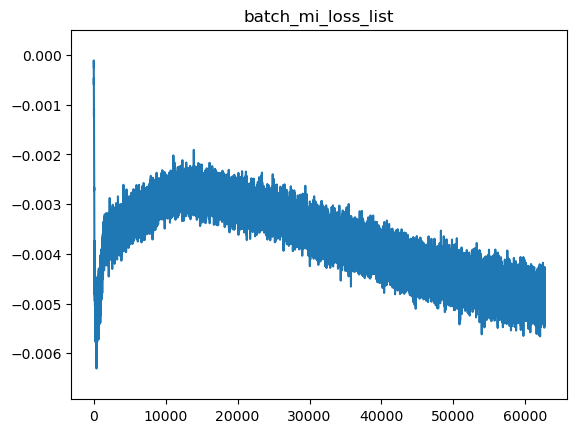

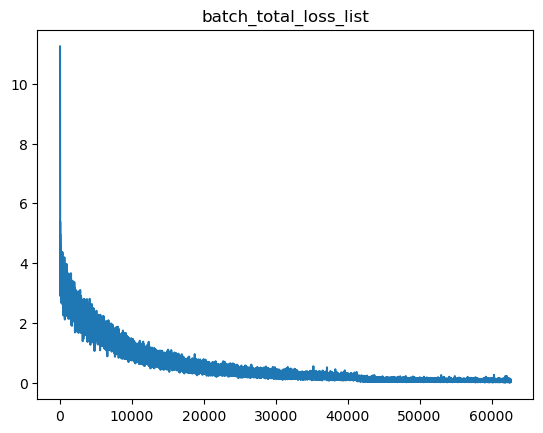

 40%|███████████████▌                       | 1651/4125 [07:41<11:18,  3.64it/s]

now batch:1651 in epoch 15


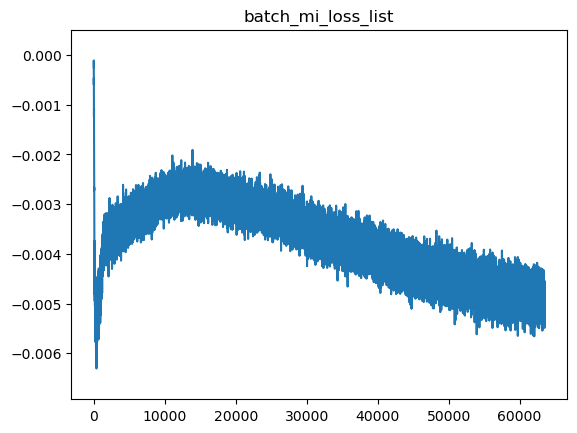

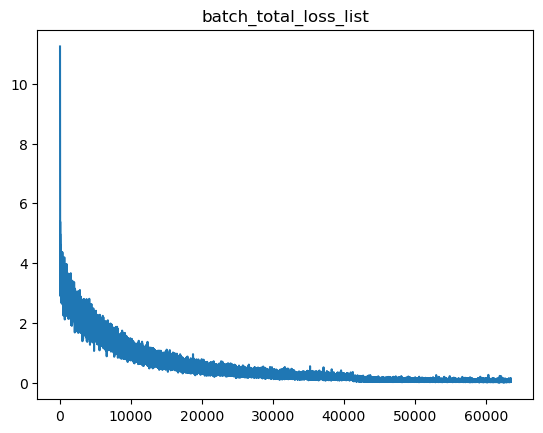

 60%|███████████████████████▍               | 2477/4125 [11:36<08:19,  3.30it/s]

now batch:2477 in epoch 15


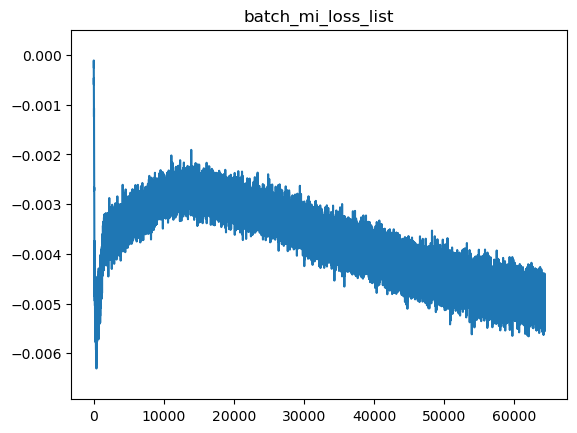

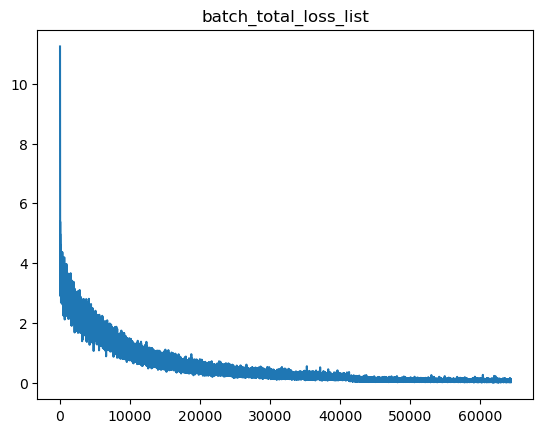

 80%|███████████████████████████████▏       | 3303/4125 [15:24<03:46,  3.62it/s]

now batch:3303 in epoch 15


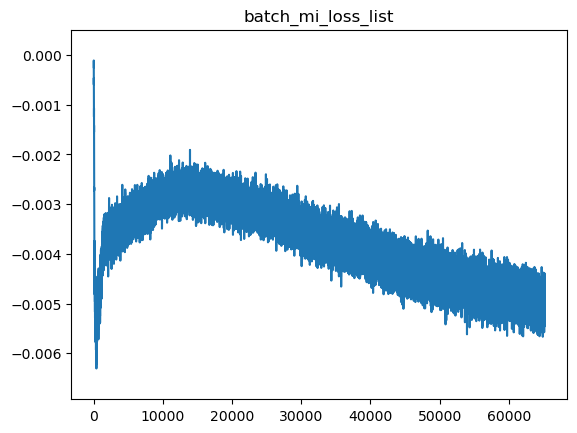

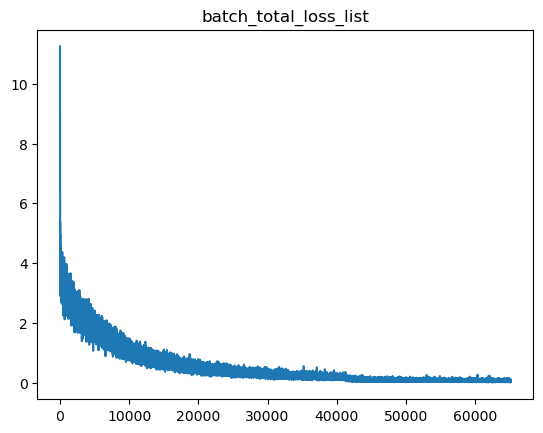

100%|███████████████████████████████████████| 4125/4125 [19:13<00:00,  3.58it/s]

============================== epoch: 15 loss: 221.64699820242822
train sample:
********************
 ['In', 'the', 'Persona', 'series', 'there', 'these', 'events', 'called', '"', 'social', 'links', '"', ',', 'which', 'has', 'your', 'player', 'character', 'bond', 'with', 'other', 'story', 'characters', '(@@', 'may', 'also', 'increase', 'character', 'stat@@', 's)', '<eos>'] 
->
 ['In', 'the', 'combination', 'series', 'there', 'these', 'events', 'called', 'I', 'social', 'links', '"', ',', 'which', 'has', 'your', 'willpower', 'character', 'bond', 'with', 'other', 'story', 'characters', '(@@', 'may', 'also', 'increase', 'character', 'comparing', 's)', '<eos>']
********************
 ['Consequently', ',', 'this', 'proposal', 'only', 'applies', 'to', 'drivers', 'who', 'are', 'employed', 'by', 'EU', 'businesses', 'and', 'who', 'drive', 'lorries', 'from', 'these', 'businesses', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->
 ['Consequently', ',', '

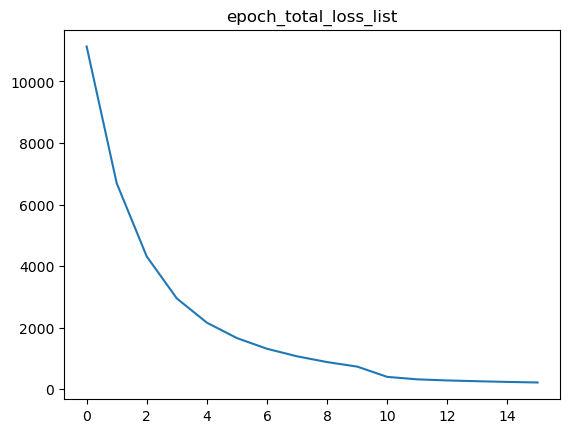

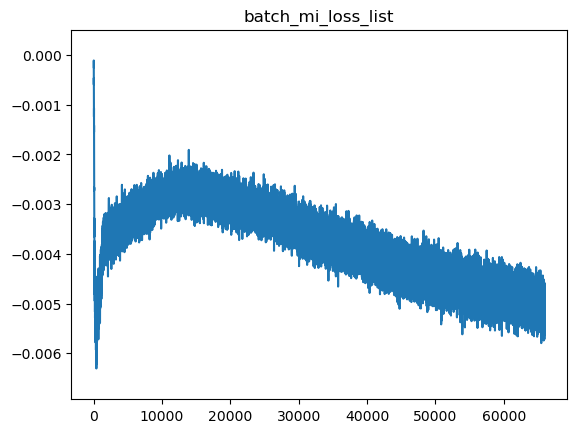

100%|█████████████████████████████████████████| 459/459 [02:25<00:00,  3.15it/s]

val sample:
********************
 ['It', 'has', 'repeatedly', 'referred', 'to', 'the', 'fact', 'that', 'it', 'should', 'like', 'to', 'be', 'treated', 'on', 'the', 'same', 'footing', 'as', 'the', 'other', 'accession', 'countries', '<eos>'] 
->
 ['It', 'has', 'repeatedly', 'referred', 'to', 'the', 'fact', 'that', 'it', 'should', 'like', 'to', 'be', 'treated', 'on', 'the', 'same', 'footing', 'as', 'the', 'other', 'accession', 'countries', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ['Mr', 'President', ',', 'international', 'trade', 'is', 'of', 'central', 'importance', 'if', 'conditions', 'for', 'growth', 'and', 'development', 'are', 'to', 'be', 'created', 'throughout', 'our', 'world', '<eos>', '<pad>'] 
->
 ['Mr', 'President', ',', 'international', 'trade', 'is', 'of', 'central', 'importance', 'if', 'conditions', 'for', 'growth', 'and', 'development', 'are', 'to', 'be'

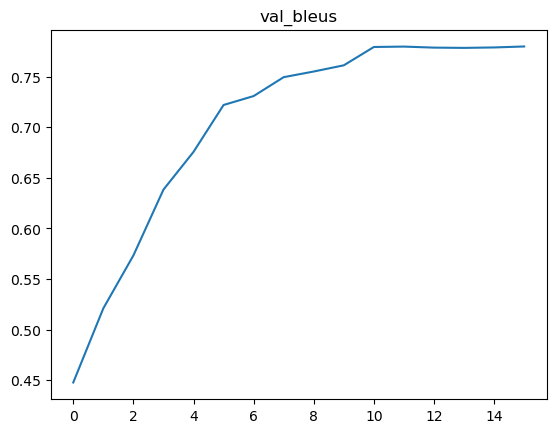

 20%|████████                                | 825/4125 [03:52<14:43,  3.74it/s]

now batch:825 in epoch 16


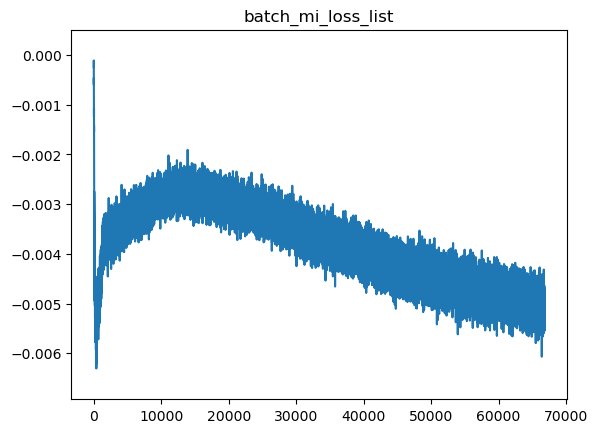

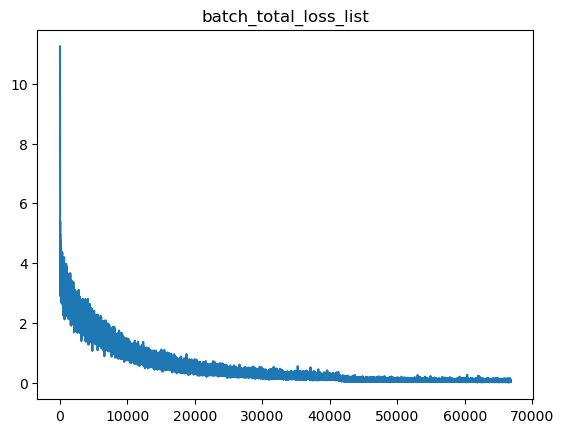

 40%|███████████████▌                       | 1651/4125 [07:51<11:51,  3.48it/s]

now batch:1651 in epoch 16


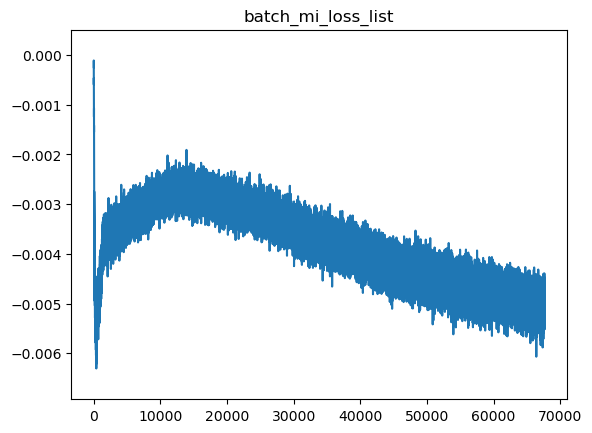

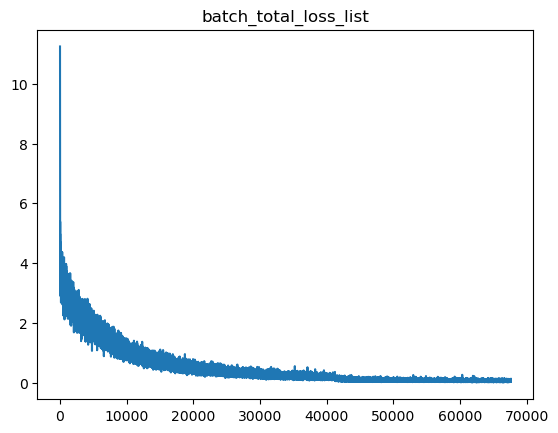

 60%|███████████████████████▍               | 2477/4125 [11:48<07:22,  3.72it/s]

now batch:2477 in epoch 16


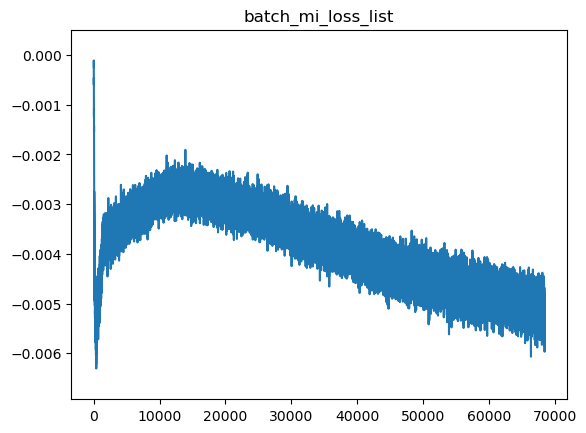

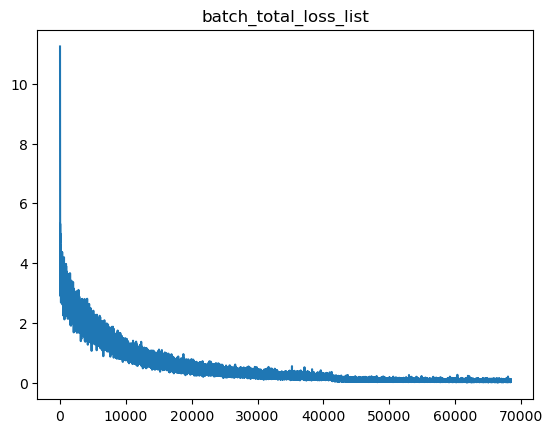

 80%|███████████████████████████████▏       | 3303/4125 [15:42<04:04,  3.36it/s]

now batch:3303 in epoch 16


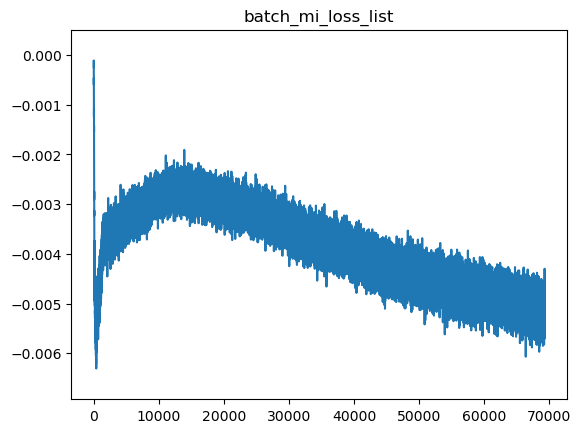

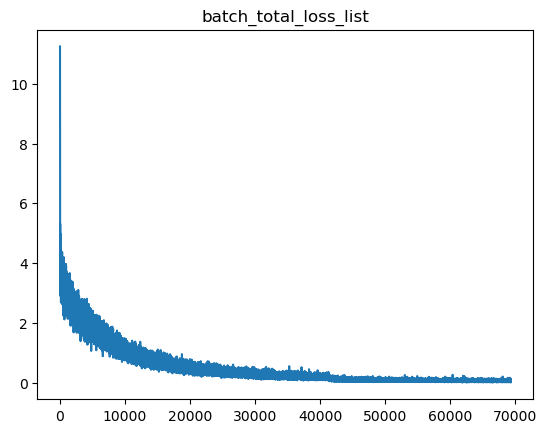

100%|███████████████████████████████████████| 4125/4125 [19:46<00:00,  3.48it/s]

============================== epoch: 16 loss: 204.1164207495749
train sample:
********************
 ['Then', 'I', 'thought', 'to', 'ask', 'them', 'if', 'they', 'could', 'accompany', 'me', 'to', 'the', 'animal', 'shelter', 'so', 'I', 'could', 'start', 'the', 'adoption', 'process', '<eos>'] 
->
 ['Then', 'I', 'thought', 'to', 'ask', 'them', 'if', 'they', 'could', 'accompany', 'me', 'to', 'the', 'animal', 'shelter', 'so', 'I', 'could', 'start', 'the', 'adoption', 'where', '<eos>']
********************
 ['Political', 'stability', 'and', 'respect', 'for', 'human', 'rights', 'and', 'the', 'constitutional', 'state', 'are', 'key', 'to', 'economic', 'recovery', 'following', 'the', 'Asia', 'crisis', '<eos>', '<pad>', '<pad>'] 
->
 ['Political', 'stability', 'and', 'respect', 'for', 'human', 'rights', 'and', 'the', 'constitutional', 'state', 'are', 'key', 'to', 'economic', 'recovery', 'following', 'the', 'Asia', 'crisis', '<eos>', '<pad>', '<pad>']
********************
 ['This', 'is', 'ground@@'

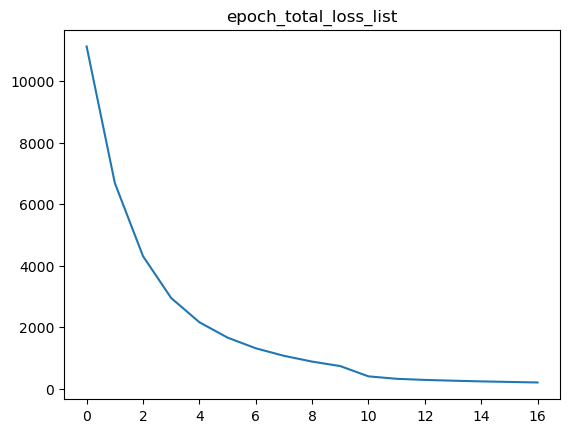

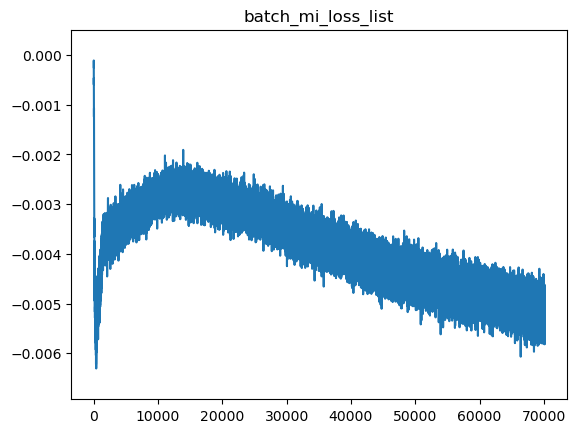

100%|█████████████████████████████████████████| 459/459 [02:33<00:00,  2.98it/s]

val sample:
********************
 ['In', 'its', 'statement', 'of', '9', 'June', ',', 'the', 'European', 'Union', 'stressed', 'that', 'it', 'would', 'support', 'the', 'O@@', 'AS', 'mission', 'to', 'Peru', '<eos>'] 
->
 ['In', 'its', 'statement', 'of', '9', 'June', ',', 'the', 'European', 'Union', 'stressed', 'that', 'it', 'would', 'support', 'the', 'O@@', 'artificially', 'mission', 'to', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ["It's", 'so', 'loud', 'I', "can't", 'even', 'sleep', 'with', 'one', 'hand', 'over', 'my', 'ear', 'because', 'I', 'can', 'still', 'hear', 'it', '<eos>', '<pad>', '<pad>'] 
->
 ["It's", 'so', 'loud', 'I', "can't", 'even', 'sleep', 'with', 'one', 'hand', 'over', 'my', 'ear', 'because', 'I', 'can', 'still', 'hear', 'it', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'

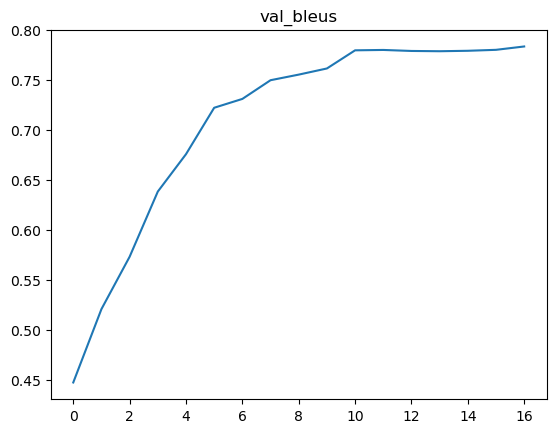

 20%|████████                                | 825/4125 [04:01<16:07,  3.41it/s]

now batch:825 in epoch 17


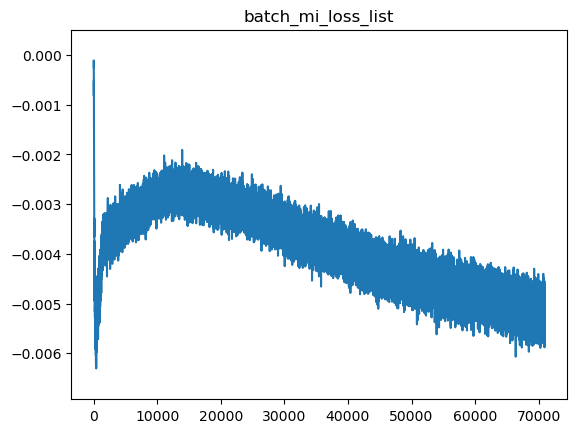

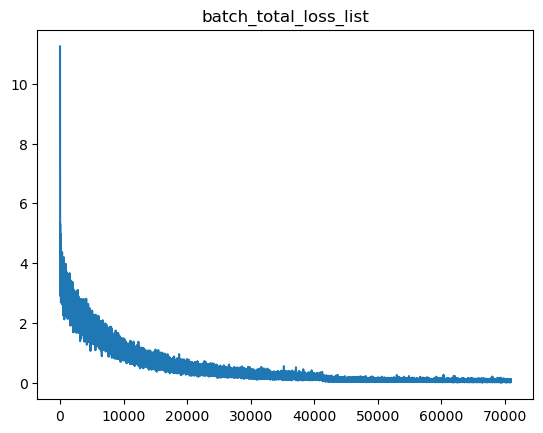

 40%|███████████████▌                       | 1651/4125 [07:57<12:28,  3.30it/s]

now batch:1651 in epoch 17


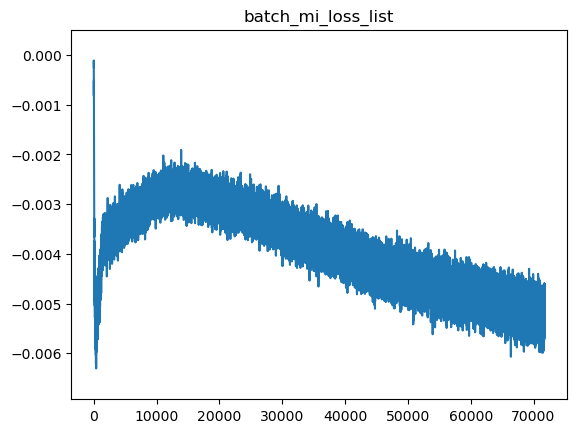

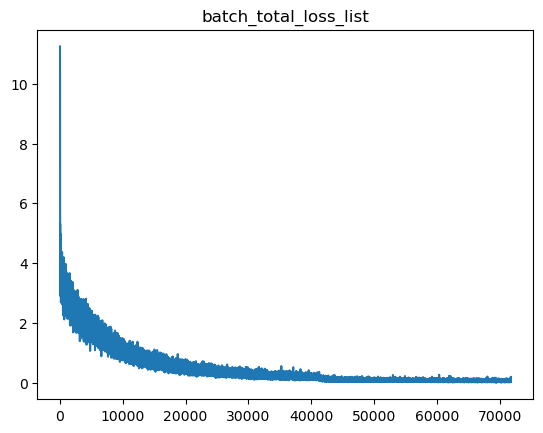

 60%|███████████████████████▍               | 2477/4125 [11:53<07:41,  3.57it/s]

now batch:2477 in epoch 17


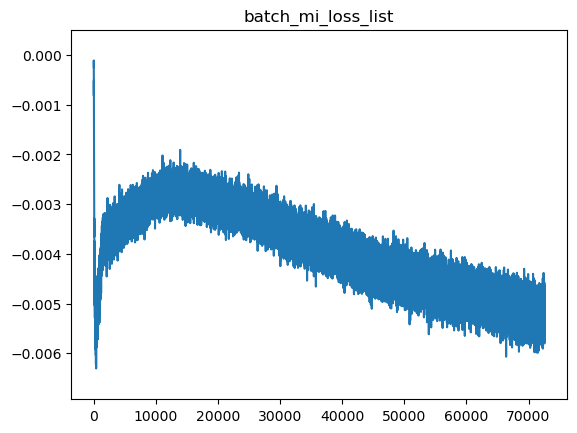

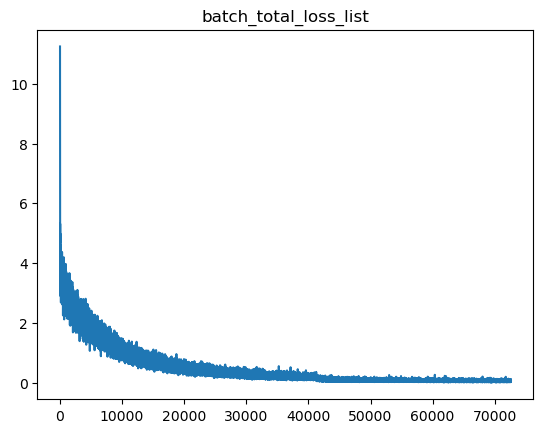

 80%|███████████████████████████████▏       | 3303/4125 [15:48<03:57,  3.46it/s]

now batch:3303 in epoch 17


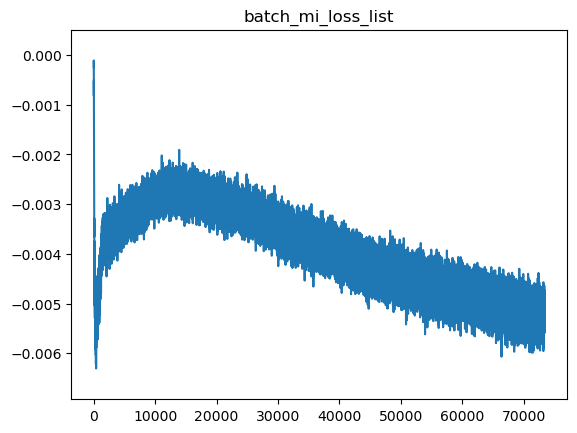

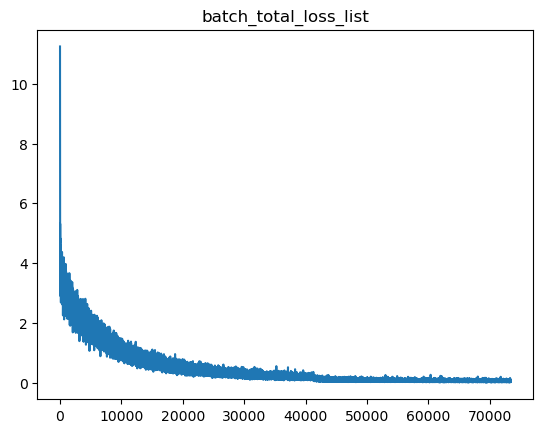

100%|███████████████████████████████████████| 4125/4125 [19:36<00:00,  3.51it/s]

============================== epoch: 17 loss: 191.4697041325271
train sample:
********************
 ['The', 'taxpayer', 'expects', 'us', 'to', 'take', 'a', 'prudent', 'approach', 'not', 'only', 'when', 'we', 'draw', 'up', 'the', 'budget', ',', 'but', 'also', 'when', 'we', 'implement', 'and', 'carry', 'it', 'out', '<eos>'] 
->
 ['The', 'taxpayer', 'expects', 'us', 'to', 'take', 'a', 'prudent', 'approach', 'not', 'only', 'when', 'we', 'draw', 'up', 'the', 'budget', ',', 'but', 'also', 'when', 'we', 'implement', 'and', 'carry', 'it', 'out', '<eos>']
********************
 ['All', 'four', 'of', 'them', 'must', 'look', 'carefully', 'at', 'their', 'past', ',', 'come', 'clean', 'and', 'show', 'this', 'new', 'Commission', 'where', 'reform', 'is', 'needed', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->
 ['All', 'four', 'of', 'them', 'must', 'look', 'carefully', 'at', 'their', 'past', ',', 'come', 'clean', 'and', 'show', 'this', 'new', 'Commission', 'where', 'reform', 'is', 'needed',

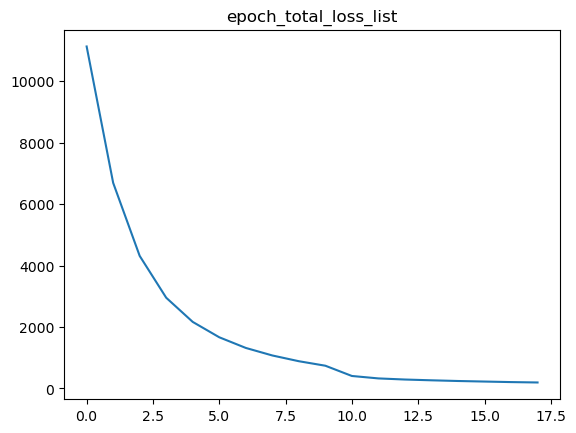

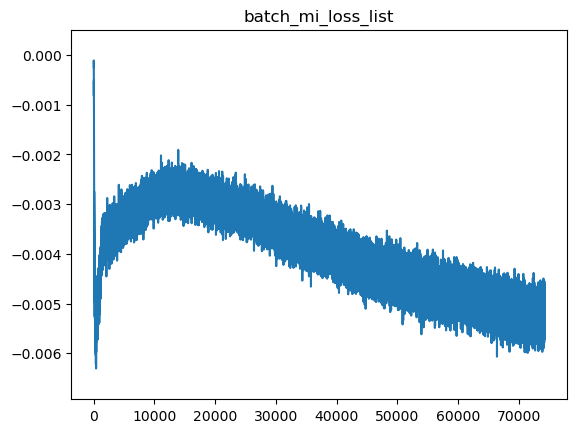

100%|█████████████████████████████████████████| 459/459 [02:32<00:00,  3.01it/s]

val sample:
********************
 ['In', 'the', 'candidate', 'countries', 'where', 'referen@@', 'dum@@', 's', 'are', 'to', 'be', 'held', ',', 'a', 'lot', 'of', 'people', 'are', 'probably', 'wondering', 'what', 'they', 'are', 'getting', 'themselves', 'into', '<eos>'] 
->
 ['In', 'the', 'candidate', 'countries', 'where', 'referen@@', 'dum@@', 's', 'are', 'to', 'be', 'held', ',', 'a', 'lot', 'of', 'people', 'are', 'probably', 'wondering', 'what', 'they', 'are', 'getting', 'themselves', 'into', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ['This', 'sort', 'of', 'practice', 'has', 'fortunately', 'been', 'unknown', 'in', 'the', 'animal', 'feedingstuffs', 'industry', 'up', 'till', 'now', 'in', 'many', 'Member', 'States', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->
 ['This', 'sort', 'of', 'practice', 'has', 'fortunately', 'been', 'unknown', 'in', 'the', 'animal', 'feedingstuffs'

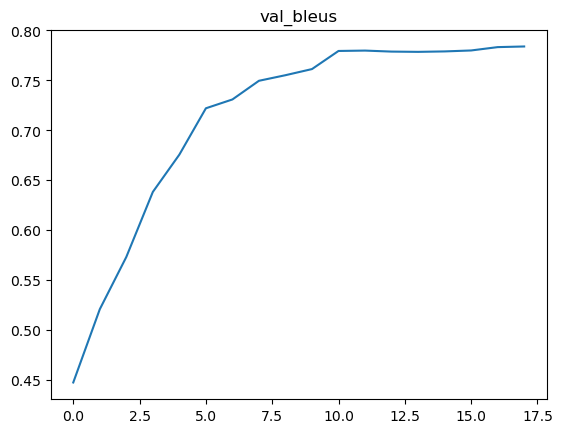

 20%|████████                                | 825/4125 [03:54<15:17,  3.60it/s]

now batch:825 in epoch 18


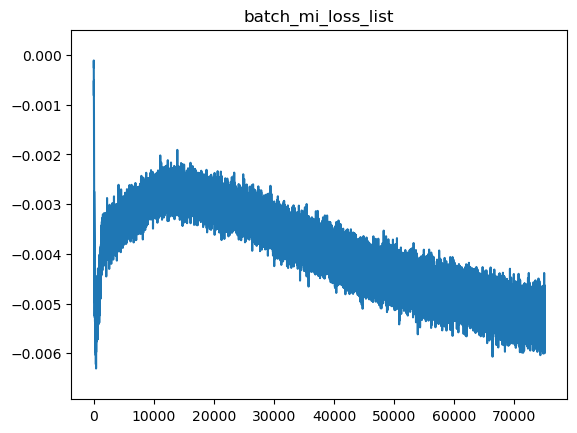

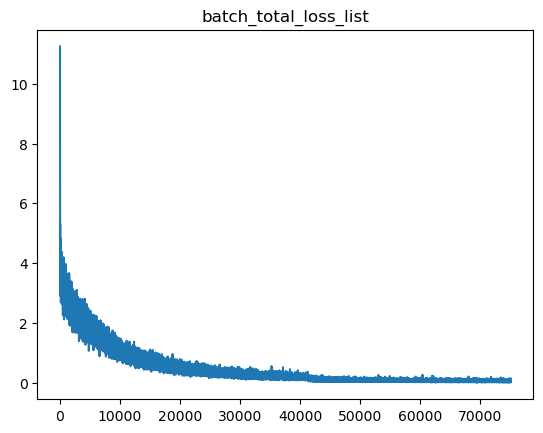

 40%|███████████████▌                       | 1651/4125 [07:53<10:51,  3.80it/s]

now batch:1651 in epoch 18


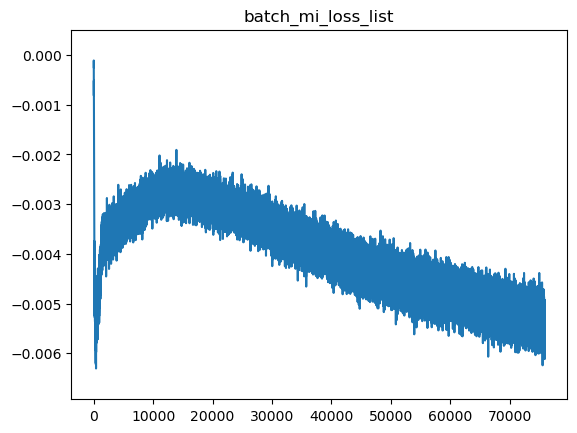

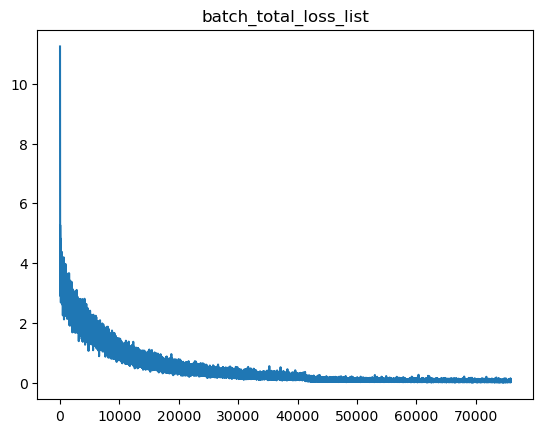

 60%|███████████████████████▍               | 2477/4125 [11:48<07:08,  3.85it/s]

now batch:2477 in epoch 18


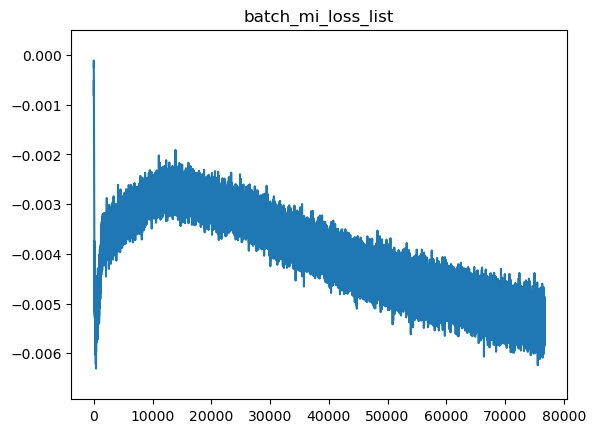

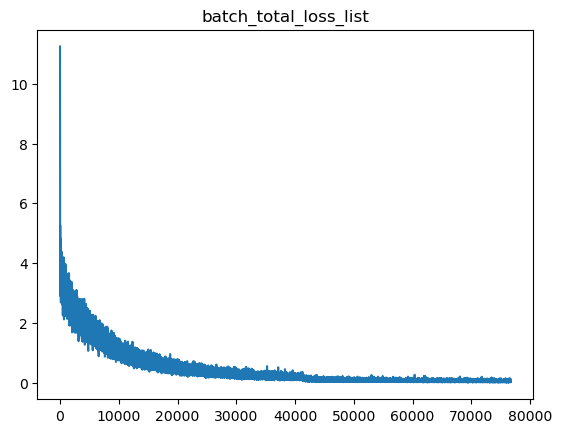

 80%|███████████████████████████████▏       | 3303/4125 [15:44<03:57,  3.46it/s]

now batch:3303 in epoch 18


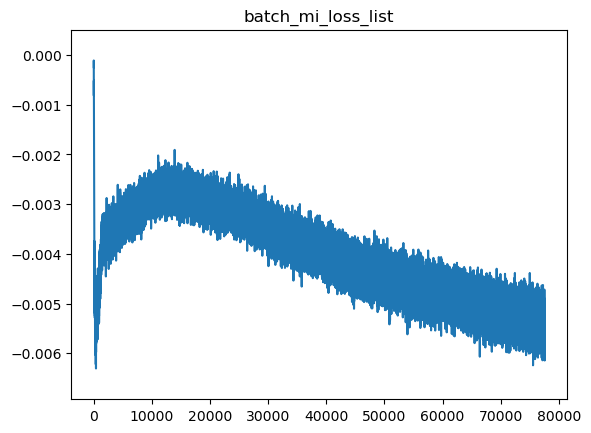

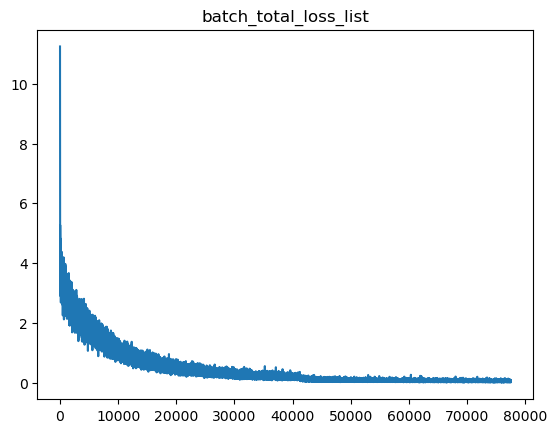

100%|███████████████████████████████████████| 4125/4125 [19:42<00:00,  3.49it/s]

============================== epoch: 18 loss: 177.06877489108592
train sample:
********************
 ['These', 'bodies', 'do', 'not', 'in', 'themselves', 'present', 'any', 'problems', ',', 'but', 'they', 'create', 'problems', 'in', 'terms', 'of', 'budgeting', 'and', 'the', 'ability', 'to', 'obtain', 'an', 'overview', 'of', 'the', 'EU', "'s", 'costs', '<eos>'] 
->
 ['These', 'bodies', 'do', 'not', 'in', 'themselves', 'present', 'any', 'problems', ',', 'but', 'they', 'create', 'problems', 'in', 'terms', 'of', 'evaluations', 'and', 'the', 'ability', 'to', 'obtain', 'an', 'overview', 'of', 'the', 'EU', "'s", 'costs', '<eos>']
********************
 ['On', 'a', 'technical', 'point', ',', 'I', 'look', 'forward', 'to', 'hearing', 'the', 'Commission', "'s", 'response', 'on', 'the', 'amendments', 'which', 'have', 'been', 'moved', 'about', 'the', 'legal', 'basis', 'for', 'this', 'directive', '<eos>', '<pad>', '<pad>'] 
->
 ['On', 'a', 'technical', 'point', ',', 'I', 'look', 'forward', 'to', 'hea

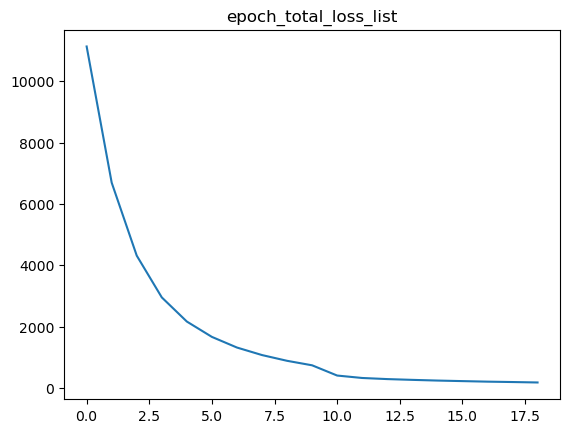

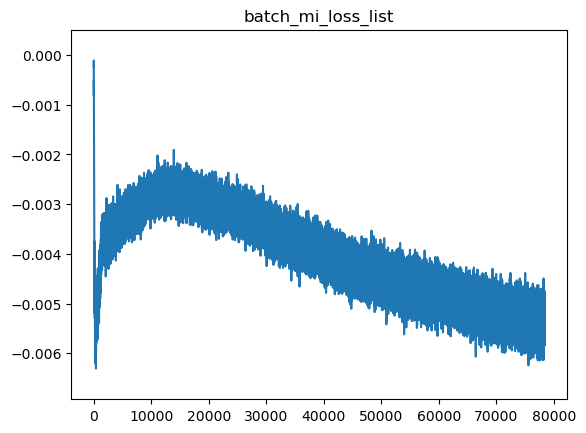

100%|█████████████████████████████████████████| 459/459 [02:27<00:00,  3.11it/s]

val sample:
********************
 ['Now', 'the', 'Member', 'States', 'which', 'fight', 'hardest', 'and', 'most', 'vo@@', 'ci@@', 'fer@@', 'ously', 'against', 'increasing', 'that', 'budget', 'are', 'the', 'ones', 'that', 'take', '4@@', '7-@@', '50', '%', 'and', 'spend', 'it', 'themselves', '<eos>'] 
->
 ['Now', 'the', 'Member', 'States', 'which', 'fight', 'hardest', 'and', 'most', 'vo@@', 'ci@@', 'fer@@', 'ously', 'against', 'increasing', 'that', 'budget', 'are', 'the', 'ones', 'that', 'take', '4@@', 'incur@@', '50', '%', 'and', 'spend', 'it', 'themselves', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ['What', 'has', 'happened', 'to', 'this', 'investigation', ',', 'why', 'has', 'it', 'not', 'got', 'under', 'way', ',', 'and', 'what', 'is', 'going', 'to', 'be', 'done', 'about', 'it', '?', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->
 ['What', 'has', 'happened', 'to', 'this', 'investigation', ',', 'why', 'has', 'it', 'n

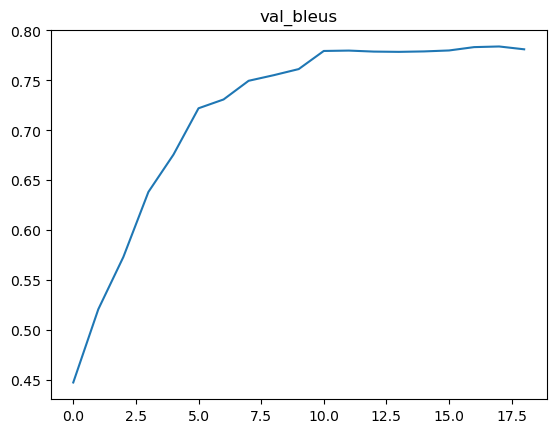

 20%|████████                                | 825/4125 [04:57<17:37,  3.12it/s]

now batch:825 in epoch 19


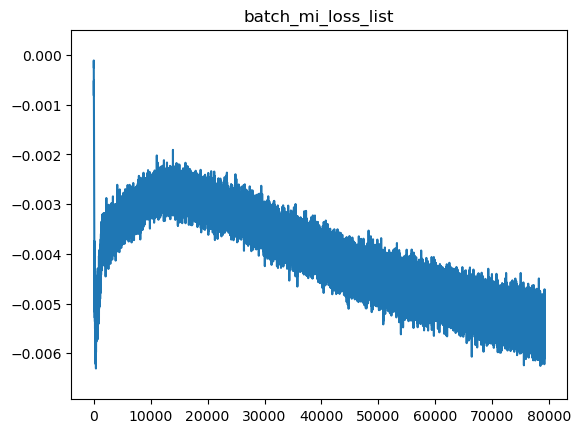

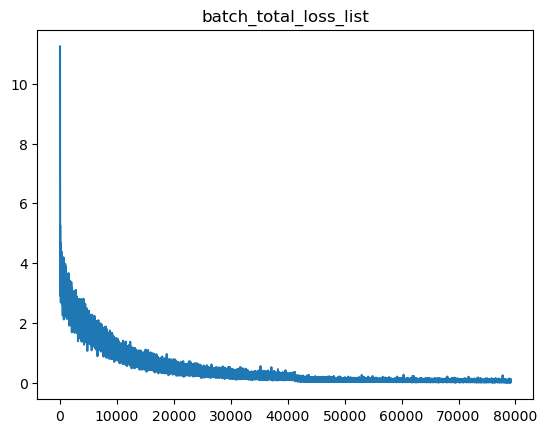

 40%|██████████████▊                      | 1651/4125 [1:02:56<11:13,  3.67it/s]

now batch:1651 in epoch 19


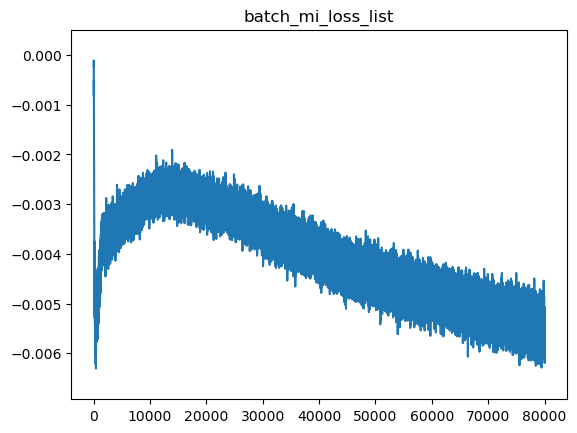

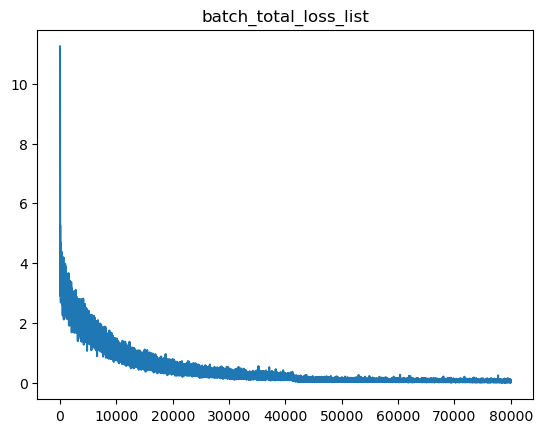

 60%|██████████████████████▏              | 2477/4125 [1:13:36<08:07,  3.38it/s]

now batch:2477 in epoch 19


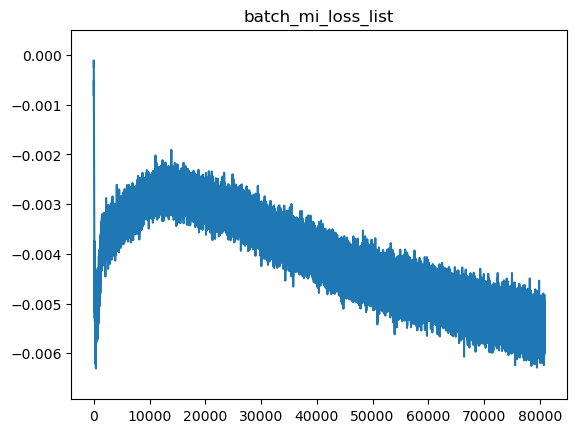

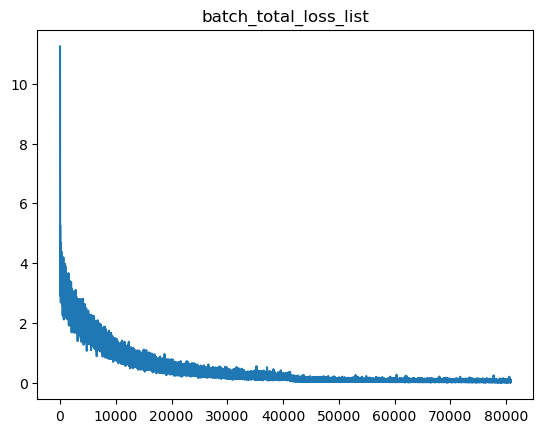

 80%|█████████████████████████████▋       | 3303/4125 [1:17:36<04:32,  3.02it/s]

now batch:3303 in epoch 19


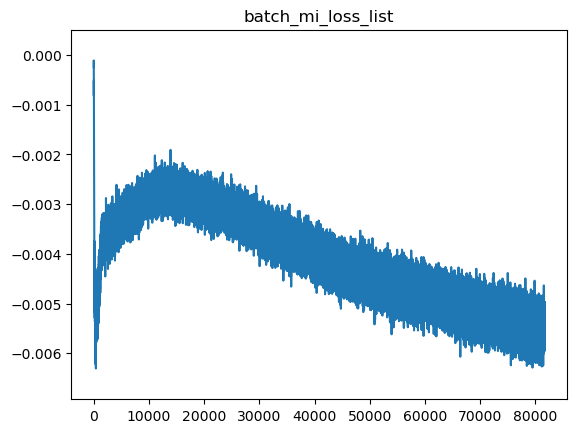

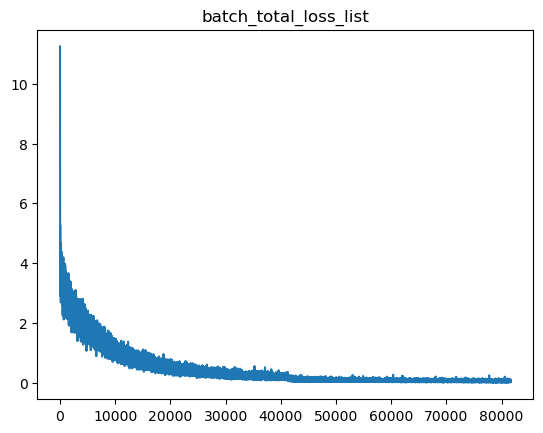

100%|█████████████████████████████████████| 4125/4125 [1:21:37<00:00,  1.19s/it]


============================== epoch: 19 loss: 164.42497138306499
train sample:
********************
 ['Some', 'Asian', 'communities', 'are', 'known', 'to', 'be', '*@@', 'very@@', '*', 'tight', 'nit', 'in', 'the', 'United', 'States', ',', 'and', 'are', 'known', 'for', 'only', 'going', 'to', 'Specific', 'Asian', 'denti@@', 'sts', ',', 'in@@', 'su@@', 'rers', ',', 'grocery', 'stores', 'etc', '<eos>'] 
->
 ['Some', 'Asian', 'communities', 'are', 'known', 'to', 'be', '*@@', 'very@@', '*', 'ast@@', 'nit', 'in', 'the', 'United', 'States', ',', 'and', 'are', 'known', 'for', 'only', 'going', 'to', 'Specific', 'Asian', 'oot@@', 'cu@@', ',', 'in@@', 'su@@', 'rers', ',', 'etc', 'stores', 'etc', '<eos>']
********************
 ['Under', 'the', 'usual', 'complaints', 'procedure', ',', 'we', 'are', 'not', 'entitled', 'to', 'make', 'this', 'reply', 'public', ',', 'although', 'we', 'can', 'say', 'broadly', 'what', 'it', 'says', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<p

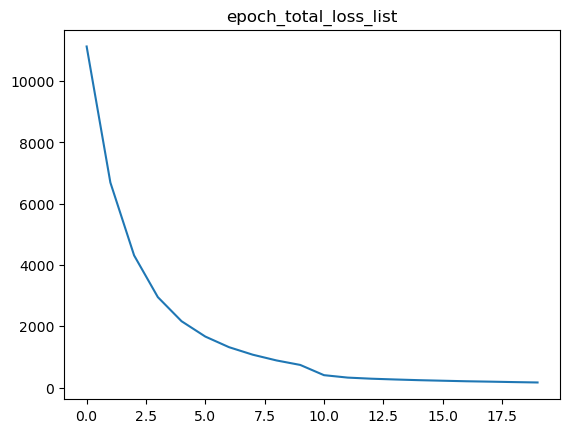

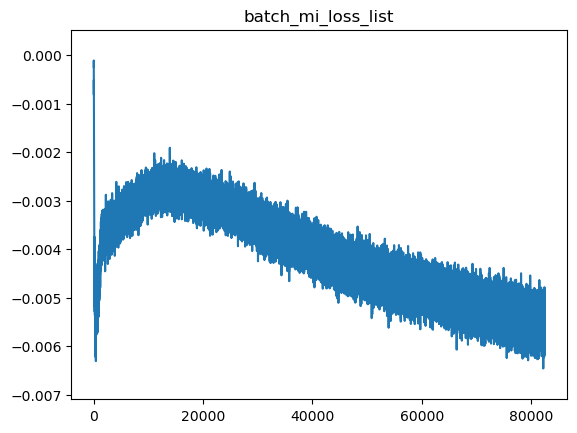

100%|████████████████████████████████████████| 459/459 [02:24<00:00,  3.18it/s]

val sample:
********************
 ['I', 'voted', 'for', 'the', 'Brok', 'report', 'and', ',', 'as', 'representative', 'of', 'the', 'Delegation', 'to', 'the', 'EU-@@', 'Bulgaria', 'Joint', 'Parliamentary', 'Committee', ',', 'I', 'would', 'like', 'to', 'point', 'something', 'out', '<eos>'] 
->
 ['I', 'voted', 'for', 'the', 'Brok', 'report', 'and', ',', 'as', 'representative', 'of', 'the', 'revenue', 'to', 'the', 'EU-@@', 'Bulgaria', 'ing-@@', 'Parliamentary', 'Committee', ',', 'I', 'would', 'like', 'to', 'point', 'something', 'out', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
********************
 ['A', 'few', 'months', 'later', ',', 'we', 'found', 'out', 'a', 'game', 'that', 'I', 'was', 'exactly', 'thinking', 'was', 'being', 'develop@@', 'ed:', 'PubG', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>'] 
->
 ['A', 'few', 'months', 'later', ',', 'we', 'found', 'out', 'a', 'game', 'that', 'I', 'was', 'exact

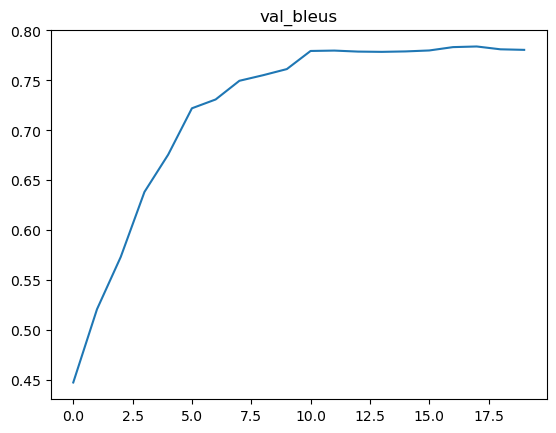

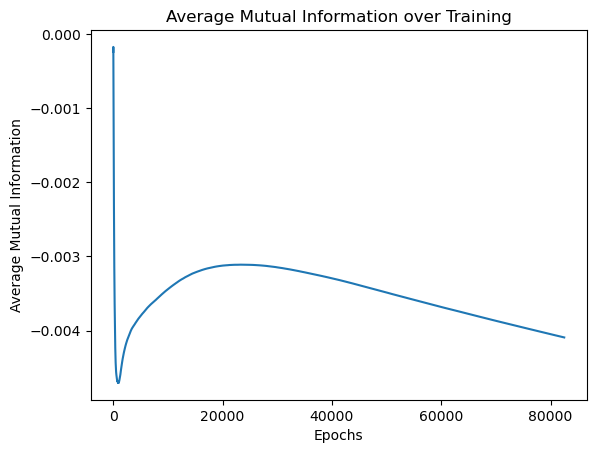

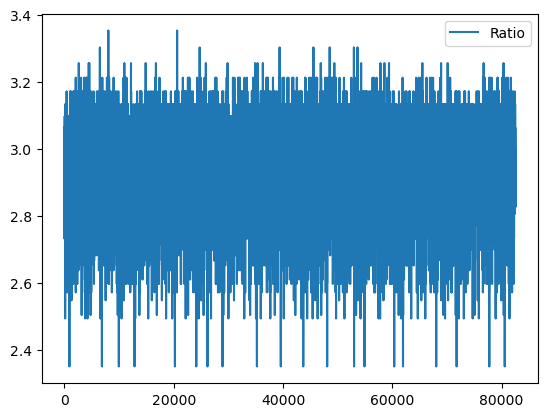

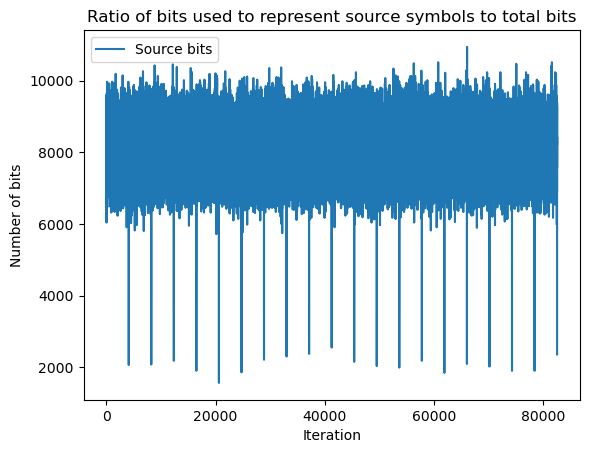

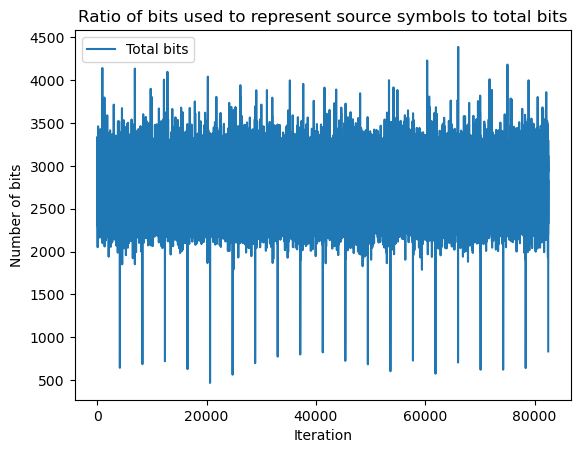

Average source bits: 8074.600077678148
Average total bits: 2735.4543733982896


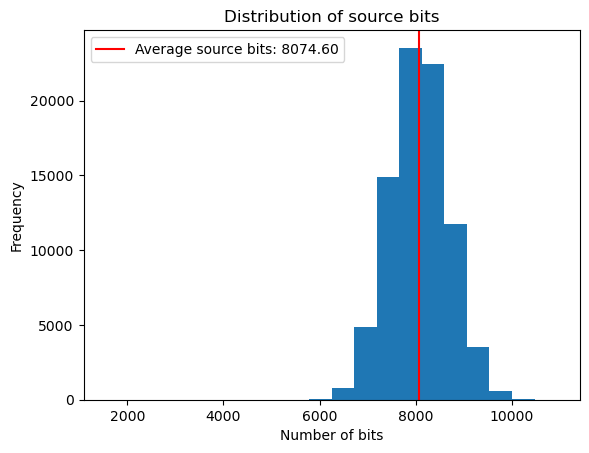

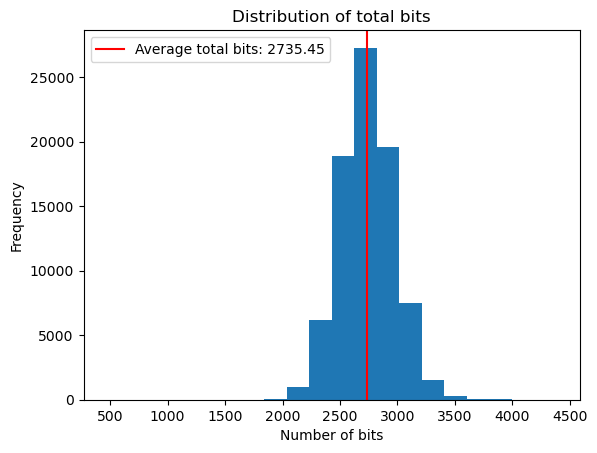

In [13]:
train()

In [14]:
####
#
# Run the model
#
###

num_steps = 40
val_bleus = []

with torch.no_grad():
    model.eval()
    bleus = []
    val_corpus = open('./test.txt', 'r').readlines()
    val_data_loader = torch.utils.data.DataLoader(dataset=EuroParlDataset(corpus=val_corpus), batch_size=32, shuffle=True, collate_fn=collate_fn)

    for index, data in enumerate(tqdm(val_data_loader), 0):
        inputs, valid_lens = data
        inputs, valid_lens = inputs.to(device), valid_lens.to(device)
        emb_inputs = embedding(inputs)
        _, channel_outputs = model(emb_inputs, valid_lens)
        # decoder's first element is <bos>
        outputs = torch.cat([torch.full([inputs.shape[0], 1], source_vocab['<bos>'], dtype=torch.long, device=device),
                             torch.full([inputs.shape[0], num_steps - 1], source_vocab['<pad>'], dtype=torch.long, device=device)],
                            dim=1).to(device)
        # continue_idxtest which sentence can continuously generate
        continue_idx = torch.arange(inputs.shape[0], device=device)
        num_step = 0
        while not len(continue_idx) == 0 and num_step < num_steps - 1:
            emb_outputs = embedding(outputs[continue_idx, :num_step + 1])
            pred_words = model.decoder(emb_outputs, channel_outputs[continue_idx], valid_lens[continue_idx], mode='validate').argmax(dim=2)[:, -1:]
            outputs[continue_idx, num_step + 1] = pred_words.squeeze(1)
            continue_idx = continue_idx[(pred_words != source_vocab['<eos>']).squeeze(1)]
            num_step += 1

        # Postprocess the output sentence and print input/output pairs
        for i in range(inputs.shape[0]):
            input_sentence = source_vocab.to_tokens(list(inputs[i].cpu().numpy()))
            input_sentence = [t for t in input_sentence if t not in ['<pad>', '<bos>', '<eos>']]
            input_sentence = ' '.join(input_sentence)

            output_sentence = source_vocab.to_tokens(list(outputs[i, 1:].cpu().numpy()))
            output_sentence = [t for t in output_sentence if t not in ['<pad>', '<eos>']]
            output_sentence = ' '.join(output_sentence)
            print(f"Input: {input_sentence}")
            print(f"Output: {output_sentence}\n")

            # Compute the BLEU score
            bleus.append(sentence_bleu([input_sentence.split()], output_sentence.split(), smoothing_function=SmoothingFunction().method1))

        if index == 2:
            break

    print(f'BLEU score mean: {sum(bleus) / len(bleus)}')

100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  7.37it/s]

Input: As far as the question of disposal costs is concerned , the fact is that very different systems are currently being applied here
Output: As far as the question of disposal costs is concerned , the fact is as very different systems are being adopted here

Input: If you stop talking to them and don't keep them as a FB <unk> what's to worry about ?
Output: If you stop talking to them and don't keep them as a FB someday what's to worry about ?

Input: I'm lucky I'm in a field where I can be curious for a living !
Output: I'm lucky I'm in a field where I can be curious for a living !

Input: My target demographic is specific but it is very <unk> women who like women
Output: My target demographic is specific but it is very emphatically women who like women

Input: It can be hard to trust that people <unk> but many really do
Output: It can be hard to trust that people but but many really do

Input: We must not throw the baby out with the bath water
Output: We must not throw the baby ou